In [1]:
import os
import django
from IPython.display import display, HTML
from django.contrib.auth.models import User
from sequence_db.models import TrimmerEntry
from sequence_db.models import TrimmerSequence
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
import operator
os.environ.setdefault('DJANGO_SETTINGS_MODULE', '/Users/keithmitchell/Desktop/Repositories/NeuroMabSeq/trimmer/trimmer/settings.py')
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
django.setup()
    

In [3]:
#!pip install numpy==1.22


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


# Categorization function:
    
## Duplicates
### -1: These did not work in the code
- likely due to some having subclone in one but not another (TODO write new rule for this)
- also occurs when no / in the ID
- often positive control ones


### 0 CATEGORY: These are ok. No sublone in them
- check if all entries have no dots.. do not include in subsequent analysis

### 1 CATEGORY: These are ok as well. All IDs match.
- check if all the same

### 2 CATEGORY: just the subclone
- check if all same up to the subclone type (up to the first dot) (projects and parents all the same but cant be all same)


### 3 CATEGORY: likely typos with groups more then 2    
- check if project is the same but parent is different and subclone is the same (indicates typo in parent)
- 3

- check if project is different but parent is same and subclone is the same (indicates typo in project)
- 3.5

- check if project is different and parent is different and subclone is the same (indicates typo in parent and subclone)
- 3.6

### 4 CATEGORY: same as 3 but should only be for 2 entry groups
- check if project is the same but parent is different and subclone is the same (indicates typo in parent)
- 4

- check if project is different but parent is same and subclone is the same (indicates typo in project)
- 4.5

- check if project is different and parent is different and subclone is the same (indicates typo in parent and subclone)
- 4.6


### 5 CATEGORY: bad?

In [2]:
def cat_from_mabidlist(mab_id_list):
    #print(mab_id_list)
    mab_id_list = mab_id_list.split(',')
    # samples with % are just noise, might want to filter these out in the future.
    mab_id_list = [i for i in mab_id_list if "%" not in i and "R" not in i]
    mycatlist = []
    myparentlist = []
    mysubclonelist = []
    myprojectslist = []
    myscore_list_final = []
    
    try:
        projects = [i.split('/')[0].replace(' ','') for i in mab_id_list]
        parents = [i.split('.')[0].replace(' ', '') for i in mab_id_list]
        subclones = [i.split('/')[1].split('.')[1].replace(' ', '') for i in mab_id_list]
        myparentlist.append(parents)
        mysubclonelist.append(mab_id_list)
        myprojectslist.append(projects)
        parents_dict = {}
        mabid_dict = {}
        
        # first count and remove subclones
        for mab_id in mab_id_list:
            if mab_id in mabid_dict.keys():
                mabid_dict[mab_id] += 1
            else:
                mabid_dict[mab_id] = 1
        
        # lets get a count of the parents observed
        for parent in parents:
            if parent in parents_dict.keys():
                parents_dict[parent] += 1
            else:
                parents_dict[parent] = 1
        
        myscore_list = []
        for mab_id, parent in zip(mab_id_list,parents):
            score = 0
            if mabid_dict[mab_id] > 1:
                score += (parents_dict[parent] - mabid_dict[mab_id]) + (0.75 * mabid_dict[mab_id])
            else: 
                score += parents_dict[parent]
            # penalize some points for the proportion of sequences that are unrelated but show as match
            score += - (len(mab_id_list) - parents_dict[parent])/(len(mab_id_list))
            myscore_list.append(score)
        myscore_list_final.append(myscore_list)
            
            

        # 0 CATEGORY: These are ok. No sublone in them
        # check if all entries have no dots.. do not include in subsequent analysis
        if sum([1 for i in mab_id_list if '.' in i])<1:
            mycatlist.append((0, "No dots in all IDs", 0))

        # 1 CATEGORY: These are ok as well. All IDs match.
        # check if all the same
        elif len(set(mab_id_list))==1 and len(mab_id_list)>2:
            mycatlist.append((1, "IDs Match", 100))

        # 2 CATEGORY: just the subclone
        # check if all same up to the subclone type (up to the first dot) (projects and parents all 
        # the same but cant be all same)
        elif len(set(projects))==1 and len(set(parents))==1 and len(mab_id_list)>2:
            mycatlist.append((2, "Parents and Projects Match ", 100))


        # 3 CATEGORY: likely typos with groups more then 2    
        # check if project is the same but parent is different and subclone is the same (indicates typo in parent)
        elif len(set(projects))==1 and len(set(parents))==2 and len(set(subclones))==1 and len(mab_id_list)>2:
            mycatlist.append((3, "Project is same but Parent is different and Subclone is the same (typo in parent?)", 100))

        # check if project is different but parent is same and subclone is the same (indicates typo in parent)
        elif len(set(projects))==2 and len(set(parents))==1 and len(set(subclones))==1 and len(mab_id_list)>2:
            mycatlist.append((4, "Project is different but Parent is same and Subclone is the same (typo in project?)", 50))

        # check if project is different and parent is different and subclone is the same (indicates typo in parent and subclone)
        elif len(set(projects))==1 and len(set(parents))==2 and len(set(subclones))==2 and len(mab_id_list)>2:
            mycatlist.append((5, "Project is same but Parent is different and Subclone is different (typo in parent and subclone?)", 50))


        # 4 CATEGORY: same as 3 but no requirement for more then 2 entries
        # check if project is the same but parent is different and subclone is the same (indicates typo in parent)
        elif len(set(projects))==1 and len(set(parents))==2 and len(set(subclones))==1 and len(mab_id_list)>1:
            mycatlist.append((6, "Only two entries. Project is same but Parent is different and Subclone is the same (typo in parent?)", 70))

        # check if project is different but parent is same and subclone is the same (indicates typo in parent)
        elif len(set(projects))==2 and len(set(parents))==1 and len(set(subclones))==1 and len(mab_id_list)>1:
            mycatlist.append((7, "Only two entries. Project is different but Parent is same and Subclone is the same (typo in project?)", 30))


        # check if project is different and parent is different and subclone is the same (indicates typo in parent and subclone)
        elif len(set(projects))==1 and len(set(parents))==2 and len(set(subclones))==2 and len(mab_id_list)>1:
            mycatlist.append((8, "Only two entries. Project is same but Parent is different and Subclone is the same (typo in parent?)", 30))


        # 5 CATEGORY: bad?
        else:
            mycatlist.append((9, "Bad", 0))


    except Exception as error:
        traceback.print_exc()
        if 'parents' in locals():
            myparentlist.append(parents)
            myprojectslist.append(projects)

        else:
            myparentlist.append(mab_id_list)
            myprojectslist.append(mab_id_list)
        if 'myscore_list' not in locals():
            myscore_list_final = []
            myscore_list_final.append([0 for i in mab_id_list])
            
        mysubclonelist.append(mab_id_list)
        # 0 CATEGORY: These are ok. No sublone in them
        # check if all entries have no dots.. do not include in subsequence analysis
        if sum([1 for i in mab_id_list if '.' in i])<1:
            mycatlist.append((0,"Another 0 category no sublcone", 0))    

        # 1 CATEGORY: These are ok as well. All IDs match.
        # check if all the same
        elif len(set(mab_id_list))==1:
            mycatlist.append((1, "IDs Match", 100))

        # -1 make my own category for failed ones
        else:
            mycatlist.append((-11, "Failed Categorization", 0))
    return mycatlist[0], myparentlist[0], mysubclonelist[0], myprojectslist[0], myscore_list_final[0]


# Lets get a break down of of sequence groupby as well as chain counts per parent.
- Generate some images of the amino acid distribution for each chain
- TODO use this code to run more germline analysis
- TODO need to align these sequences to the germline sequences

In [83]:
def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>")))

    
# turn this in to a function
def get_dflh_dataframe():
    df_lh = TrimmerSequence.objects.filter(entry__clonality="Monoclonal", 
                                        entry__show_on_web=True, anarci_duplicate=False, 
                                        anarci_bad=False, bad_support=False)
    #.values('seq','chain', 'entry__mabid','entry__clonality', 'entry__category', '
    # pk', 'asv_support', 'total_reads', 'domain', 'plate')
    final_list = []
    for item in df_lh:
        appdict = {}
        for value in ('seq','chain', 'entry__mabid','entry__clonality', 'entry__category', 'pk', 'asv_support', 'total_reads', 'domain', 'plate', 'vector_sequence','stars'):
            if "__" in value:
                appdict[value] = getattr(getattr(item, value.split("__")[0]), value.split("__")[1])
            else: 
                appdict[value] = getattr(item, value)

        final_list.append(appdict)
    df_lh = pd.DataFrame.from_records(final_list)
    return df_lh

# create a function for getting the clone status and the RmAb gBlocks
def get_clone_status():
    priority = pd.read_csv("jupyter/RmAb cloning status year 5.xlsx - General status.csv", keep_default_na=False)[["Priority", "Clone", "Status 081623", "Year completed", "R-mAb gBlocks"]]
    priority.Clone = [i.strip("VL").strip("VH") for i in priority.Clone]
    priority["StatusDate"] = priority["Status 081623"]
    priority["Complete based on Year Completed being blank"] = True
    priority["Year completed"] = priority["Year completed"].replace("NA", "")
    priority["Complete based on Year Completed being blank"] = np.where(priority["Year completed"]!="", True, False)
    # if word failed or negative in the Status column, then it is not complete
    priority["Complete based on Status"] = np.where(priority["StatusDate"].str.contains("failed|negative|Failed"), False, True)
    priority["Complete based on Year Completed being blank"] = np.where(priority["Year completed"]!="", True, False)


    return priority


def get_gblocks():
    conf = pd.read_csv("jupyter/RmAb_compiled.tsv", sep="\t", header=None)
    conf[2] = [i.strip("VL").strip("VH").\
     replace("(1)", "").replace("(2)", "").replace("(3)", "").replace("(4)", "").replace("(5)", "") for i in conf[2]]
    conf = conf.pivot(index=[0,2], columns=1, values=3).reset_index()
    conf.columns = ["session", "mabid", "VL", "VH"]    
    return conf


# set the entries to all false for contains_verified and contains_failed
def reset_failed_sequences():
    for dbentry in TrimmerEntry.objects.all():
        setattr(dbentry, "contains_failed", False)
        dbentry.save()

# set the entries to all false for contains_verified and contains_failed
def reset_verified_sequences():
    for dbentry in TrimmerEntry.objects.all():
        setattr(dbentry, "contains_verified", False)
        dbentry.save()





def update_verified_sequences(conf, df_lh, dbfield="verified", entry_dbfield="contains_verified"):
    df_lh[dbfield] = False    
    # see which new_aber sequences are contained in any of the conf sequences which is the 3rd column
    for index, row in df_lh.iterrows():
        # reset the db to false for everything before running this
        result = False
        dbseq = TrimmerSequence.objects.get(pk=row["pk"])
        setattr(dbseq, dbfield, False)
        # save the entry as contains a verified sequence     
        dbseq.save()

        
        # as we check out each item in the db, we check if it is in the conf seqs
        for value, mabid in zip(conf[3].values, conf[1].values):
            if isinstance(mabid, str):
                # first do some cleaning
                mabid_clean = mabid.split(".")[0].replace("VL1", "").\
                    replace("VH1", "").replace("VL2", "").replace("VH2", "").replace("VL3", "").replace("VH3", "").\
                    replace("(1)", "").replace("(2)", "").replace("(3)", "").replace("(4)", "").replace("(5)", "").\
                    replace("VL", "").replace("VH", "")
                
                # if the sequence is in the conf, then we set the verified to true and save the entry as contains a verified sequence
                if (str(row["vector_sequence"]) in str(value)):
                    # not only make sure the sequence is in the conf, but also make sure the mabid is the same
                    # print(row["entry__mabid"].split(".")[0], mabid_clean, mabid)
                    # also check for the ones that are missing the L or N or K at the front of the mabid_clean
                    if (row["entry__mabid"].split(".")[0] == mabid_clean or 
                            row["entry__mabid"].split(".")[0] == "L"+mabid_clean or 
                            row["entry__mabid"].split(".")[0] == "N"+mabid_clean or 
                            row["entry__mabid"].split(".")[0] == "K"+mabid_clean):
                        # TODO only want to verify the sequences that have both a heavy and light chain verified since those are the only proper ones
                        result = True
                        # save the verified sequences based on the pk in the database
                        dbseq = TrimmerSequence.objects.get(pk=row["pk"])
                        setattr(dbseq, dbfield, True)
                        # save the entry as contains a verified sequence            
                        dbseq.save()
                        # for some given pk of a seq in the dataabase, we get the entry, then get all the sequences for that entry
                        dbentry = TrimmerEntry.objects.get(pk=dbseq.entry.pk)
                        setattr(dbentry, entry_dbfield, False)
                        # at some point iterating both seqs should be labeled verified so then we will have light and heavy and we can set contains_verified to True
                        if dbfield == "verified":
                            trimmer_seqs = TrimmerSequence.objects.filter(entry=dbentry, verified=True)
                        else:
                            trimmer_seqs = TrimmerSequence.objects.filter(entry=dbentry, failed=True)
                        # some entry may have only one chain verified, so we check both
                        if len(trimmer_seqs) > 1 and any([i.chain == "Heavy" for i in trimmer_seqs]) and any([i.chain == "Light" for i in trimmer_seqs]):
                            setattr(dbentry, entry_dbfield, True)
                        dbentry.save()


        df_lh.loc[df_lh.index == index, dbfield] = result 
    return df_lh

In [ ]:
reset_verified_sequences()

In [84]:
reset_failed_sequences()

In [4]:
df_lh = get_dflh_dataframe()
df_lh["pk"] = df_lh["pk"].values.astype("str")
priority = get_clone_status()
gblocks = get_gblocks()
priority = priority.merge(gblocks, left_on="Clone", right_on="mabid", how="outer")#.to_csv("jupyter/DatabaseNotebook.csv", index=False)
priority
#.reset_index().droplevel('0', axis=1)
# mabid_clean = mabid.split(".")[0].replace("VL1", "").\
#     replace("VH1", "").replace("VL2", "").replace("VH2", "").replace("VL3", "").replace("VH3", "").\
#     replace("(1)", "").replace("(2)", "").replace("(3)", "").replace("(4)", "").replace("(5)", "").\
#     replace("VL", "").replace("VH", "")


/opt/anaconda3/envs/trimmer_lab/lib/python3.8/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/opt/anaconda3/envs/trimmer_lab/lib/python3.8/site-packages/IPython/core/formatters.py:343: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,Priority,Clone,Status 081623,Year completed,R-mAb gBlocks,StatusDate,Complete based on Year Completed being blank,Complete based on Status,session,mabid,VL,VH
0,127,K73/20,"Passed validation via COS-IF 6/25/21, shipped ...",2,Set 2,"Passed validation via COS-IF 6/25/21, shipped ...",True,True,2.0,K73/20,CTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTCCAGCCTCAAG...,AGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGTCTGGTGCGGC...
1,133,N125/10,"Passed validation via IB 5/13/21, shipped to A...",2,Set 2,"Passed validation via IB 5/13/21, shipped to A...",True,True,2.0,N125/10,CTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTCCAGCCTCAAG...,AGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGTCTGGTGCGGC...
2,289,N345/51,"Passed validation via IB 5/20/22, shipped to A...",3,Set 8,"Passed validation via IB 5/20/22, shipped to A...",True,True,8.0,N345/51,TGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTCCAGCCTCAAGC...,AGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGTCTGGTGCGGC...
3,105,K66/38,At Addgene 6/2/19,,NA,At Addgene 6/2/19,False,True,NaN,NaN,NaN,NaN
4,342,N341/12,"Passed validation via IB 3/9/23, shipped to Ad...",4,Set 9,"Passed validation via IB 3/9/23, shipped to Ad...",True,True,9.0,N341/12,TGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTCCAGCCTCAAGC...,AGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGTCTGGTGCGGC...
...,...,...,...,...,...,...,...,...,...,...,...,...
737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,N444/63.2.2,TGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTCCAGCCTCAAGC...,AGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGTCTGGTGCGGC...
738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,N424/48,CTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTCCAGCCTCAAG...,AGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGTCTGGTGCGGC...
739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,N424/48VL2,NaN,AGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGTCTGGTGCGGC...
740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,N463/52,CTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTCCAGCCTCAAG...,AGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGTCTGGTGCGGC...


In [5]:
priority_failed = priority[((priority['Complete based on Year Completed being blank'] == False) | \
                    (priority['Complete based on Status'] == False))]
# filter completed based on year completed as true
priority_successwseq = priority[((priority['Complete based on Year Completed being blank'] == True) & \
                    (priority['Complete based on Status'] == True) & 
                    (priority["VL"].notnull()) & \
                    (priority["VH"].notnull()))]

priority_successnoseq = priority[((priority['Complete based on Year Completed being blank'] == True) & \
                    (priority['Complete based on Status'] == True) & 
                    (priority["VL"].isna()) & \
                    (priority["VH"].isna()))]

# create priority_failedwseq and only the filter for the complete based on status
priority_failedwseq = priority[((priority['Complete based on Status'] == False) & \
                    (priority["VL"].notnull()) & \
                    (priority["VH"].notnull()))]
                    

# Missing some of the L parts why just numbers for some of the L parts?


In [6]:
priority_failedwseq

,Priority,Clone,Status 081623,Year completed,R-mAb gBlocks,StatusDate,Complete based on Year Completed being blank,Complete based on Status,session,mabid,VL,VH
6,31,N103/39,"TC Supes collected 18-Jan-22, negative via IB ...",3,Set 1,"TC Supes collected 18-Jan-22, negative via IB ...",True,False,1.0,N103/39,CTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTCCAGCCTCAAG...,AGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGTCTGGTGCGGC...
7,228,86A/37,"TC Supes collected 29-Nov-21, negative via IB ...",3,Set 2,"TC Supes collected 29-Nov-21, negative via IB ...",True,False,2.0,86A/37,CTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTCCAGCCTCAAG...,AGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGTCTGGTGCGGC...
8,,111/118,"TC Supes collected 4-Feb-22, negative via IHC ...",3,Set 3,"TC Supes collected 4-Feb-22, negative via IHC ...",True,False,3.0,111/118,CTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTCCAGCCTCAAG...,AGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGTCTGGTGCGGC...
9,,128/43,"TC Supes collected 10-Nov-21, negative via COS...",3,Set 3,"TC Supes collected 10-Nov-21, negative via COS...",True,False,3.0,128/43,CTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTCCAGCCTCAAG...,AGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGTCTGGTGCGGC...
10,428,118/66,"Passed seq check, transfected, failed COS-IF 6...",3,Set 3,"Passed seq check, transfected, failed COS-IF 6...",True,False,3.0,118/66,CTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTCCAGCCTCAAG...,AGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGTCTGGTGCGGC...
11,,D4/27,"TC Supes collected, failed validation via COS-...",3,Set 6,"TC Supes collected, failed validation via COS-...",True,False,6.0,D4/27,CTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTCCAGCCTCAAG...,AGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGTCTGGTGCGGC...
12,,61C/7,"TC Supes collected, failed validation via COS-...",3,Set 6,"TC Supes collected, failed validation via COS-...",True,False,6.0,61C/7,CTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTCCAGCCTCAAG...,AGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGTCTGGTGCGGC...
15,,K65/36,"TC Supes collected 16-May-22, failed validatio...",4,Set 6,"TC Supes collected 16-May-22, failed validatio...",True,False,6.0,K65/36,CTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTCCAGCCTCAAG...,AGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGTCTGGTGCGGC...
16,,120/86,"TC Supes collected, failed validation via IB 3...",3,Set 6,"TC Supes collected, failed validation via IB 3...",True,False,6.0,120/86,CTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTCCAGCCTCAAG...,AGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGTCTGGTGCGGC...
17,,106/94,"TC Supes collected 26-Jan-22, failed validatio...",3,Set 6,"TC Supes collected 26-Jan-22, failed validatio...",True,False,6.0,106/94,CTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTCCAGCCTCAAG...,AGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGTCTGGTGCGGC...


# Missing the the Sequence though supposedly verified
- meeting
- make sure not ones from Andrews method

In [7]:
priority["Clone"] = priority["Clone"].fillna("")
print(priority["StatusDate"].unique())

['Passed validation via COS-IF 6/25/21, shipped to Addgene 9/27/21'
 'Passed validation via IB 5/13/21, shipped to Addgene 9/27/21'
 'Passed validation via IB 5/20/22, shipped to Addgene 8/11/22'
 'At Addgene 6/2/19'
 'Passed validation via IB 3/9/23, shipped to Addgene 7/27/23'
 'do not pursue in set 11, passed as R-368'
 'TC Supes collected 18-Jan-22, negative via IB 2/22/22'
 'TC Supes collected 29-Nov-21, negative via IB 2/8/22'
 'TC Supes collected 4-Feb-22, negative via IHC 3/17/22'
 'TC Supes collected 10-Nov-21, negative via COS-IF 2/4/22'
 'Passed seq check, transfected, failed COS-IF 6/28/22'
 'TC Supes collected, failed validation via COS-IF 3/15/22'
 'TC Supes collected, failed validation via COS-IF 4/7/22'
 'TC Supes collected, failed validation via COS-IF '
 'TC Supes collected 2/16/22, COS-IF negative 3/9/22'
 'TC Supes collected 16-May-22, failed validation via COS-IF 12/16/22'
 'TC Supes collected, failed validation via IB 3/18/22'
 'TC Supes collected 26-Jan-22, faile

In [8]:
priority_successnoseq["StatusDate"].unique()

array(['Passed validation via IHC 4/22/21, shipped to Addgene 8/11/22',
       'Passed validation via IB 5/28/21, shipped to Addgene 9/27/21',
       'Passed validation via COS-IF 06/18/21, shipped to Addgene 9/27/21',
       'Passed validation via IB 5/11/21, shipped to Addgene 9/27/21',
       'Passed validation via CCN CHN-IF 6/25/21, shipped to Addgene 9/27/21',
       'Passed validation via IB 4/27/21, shipped to Addgene 9/27/21',
       'Passed validation via IB 6/25/21, shipped to Addgene 9/27/21',
       'Passed validation via COS-IF 6/25/21, shipped to Addgene 9/27/21',
       'Passed validation via IHC 5/26/21, shipped to Addgene 9/27/21',
       'Passed validation via COS-IF 06/19/21, shipped to Addgene 9/27/21',
       'Passed validation via IB 10/22/21, shipped to Addgene 01/27/2022',
       'Passed validation via IHC 6/26/22, shipped to Addgene 8/11/22',
       'TC Supes collected 07-Mar-22, Protein ELISA positive 6/27/23,  shipped to Addgene 7/27/23',
       'Passed vali

In [9]:
priority_successnoseq

,Priority,Clone,Status 081623,Year completed,R-mAb gBlocks,StatusDate,Complete based on Year Completed being blank,Complete based on Status,session,mabid,VL,VH
43,299,94/54,"Passed validation via IHC 4/22/21, shipped to ...",2,,"Passed validation via IHC 4/22/21, shipped to ...",True,True,NaN,NaN,NaN,NaN
50,,131/20,"Passed validation via IB 5/28/21, shipped to A...",2,Set 3,"Passed validation via IB 5/28/21, shipped to A...",True,True,NaN,NaN,NaN,NaN
142,195,N408/79v2,"Passed validation via COS-IF 06/18/21, shipped...",2,Set 2,"Passed validation via COS-IF 06/18/21, shipped...",True,True,NaN,NaN,NaN,NaN
159,241,109/57,"Passed validation via IB 5/11/21, shipped to A...",2,Set 3,"Passed validation via IB 5/11/21, shipped to A...",True,True,NaN,NaN,NaN,NaN
161,322,115/13,"Passed validation via CCN CHN-IF 6/25/21, ship...",2,Set 3,"Passed validation via CCN CHN-IF 6/25/21, ship...",True,True,NaN,NaN,NaN,NaN
162,337,117/1,"Passed validation via IB 4/27/21, shipped to A...",2,Set 3,"Passed validation via IB 4/27/21, shipped to A...",True,True,NaN,NaN,NaN,NaN
163,268,118/80,"Passed validation via IB 6/25/21, shipped to A...",2,Set 3,"Passed validation via IB 6/25/21, shipped to A...",True,True,NaN,NaN,NaN,NaN
164,401,121/25,"Passed validation via COS-IF 6/25/21, shipped ...",2,Set 3,"Passed validation via COS-IF 6/25/21, shipped ...",True,True,NaN,NaN,NaN,NaN
165,309,124/59,"Passed validation via IHC 5/26/21, shipped to ...",2,Set 3,"Passed validation via IHC 5/26/21, shipped to ...",True,True,NaN,NaN,NaN,NaN
215,338,83/11,"Passed validation via COS-IF 06/19/21, shipped...",2,Set 3,"Passed validation via COS-IF 06/19/21, shipped...",True,True,NaN,NaN,NaN,NaN


In [24]:
conf_cleaned = priority_successwseq[["session", "mabid", "VL", "VH"]].melt(id_vars=["session", "mabid"])
conf_cleaned.columns = [0,1,2,3]
#conf = pd.read_csv("jupyter/RmAb_compiled.tsv", sep="\t", header=None)
conf = conf_cleaned
df_lh = update_verified_sequences(conf, df_lh)

,0,1,2,3
0,2.0,K73/20,VL,CTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTCCAGCCTCAAG...
1,2.0,N125/10,VL,CTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTCCAGCCTCAAG...
2,8.0,N345/51,VL,TGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTCCAGCCTCAAGC...
3,9.0,N341/12,VL,TGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTCCAGCCTCAAGC...
4,12.0,N180/41,VL,CTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTCCAGCCTCAAG...
...,...,...,...,...
697,12.0,N56/9,VH,AGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGTCTGGTGCGGC...
698,12.0,N245/44,VH,AGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGTCTGGTGCGGC...
699,12.0,N250/21,VH,AGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGTCTGGTGCGGC...
700,12.0,N251/14,VH,AGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGTCTGGTGCGGC...


In [85]:
# now do the same for the priority_failed with seq
conf_cleaned = priority_failedwseq[["session", "mabid", "VL", "VH"]].melt(id_vars=["session", "mabid"])
conf_cleaned.columns = [0,1,2,3]
#conf = pd.read_csv("jupyter/RmAb_compiled.tsv", sep="\t", header=None)
conf = conf_cleaned
conf

df_lh = update_verified_sequences(conf, df_lh, dbfield="failed", entry_dbfield="contains_failed")


{'_state': <django.db.models.base.ModelState object at 0x7fac0dd22d90>, 'id': 5413, 'SMARTindex': '50-SMARTindex', 'pct_support': Decimal('73.70000'), 'asv_support': Decimal('768.00000'), 'total_reads': 1042, 'seq_platform': 'Illumina', 'plate': 'TRIMMER0036_P20', 'seq': 'AACATATGTCCAATGTCCTCTCCACAGACACTGAACACACTGACTCTAACCATGGGATGGAGCTGGATCTTTCTCTTCCTCCTGTCAGGAACTGCAGGCGTCCACTCTGAGGTCCAGCTTCAACAGTCAGGACCTGAGCTGGTGAAACCTCGGGCCTCAGTGAAGATATCCTGCAAGGCTTCTGGATACACATTCACTGACTACAACATGCACTGGGTGAAGCAGAGCCATGGAAAGACCCTTGAGTGGATTGGATATATTTATCCTTACAATGGTGGTACTGGCTACAACCAGAAGTTCAAGAGCAAGGCCACATTGACTGTAGACAATTCCTCCAGCACAGCCTACATGGAGCTCCGCAGCCTGACATCTGAGGACTCTGCAGTCTTTTACTGTGCAATGGGGGCTACGGTCCCCTTTGCTTACTGGGGCCAAGGGACTCTGGTCACTGTCTCTGCAG', 'e_value': '3.2e-56', 'score': Decimal('179.90'), 'seq_start_index': 36, 'seq_stop_index': 152, 'scheme': 'imgt', 'frame': 0, 'aa': 'NICPMSSPQTLNTLTLTMGWSWIFLFLLSGTAGVHS`EVQLQQSGPELVKPRASVKISCKASGYTFTDYNMHWVKQSHGKTLEWIGYIYPYNGGTGYNQKFKSKATLTVDNSSSTAYMELRSLTSEDSAVF

In [87]:
# for each of the values in df_lh where failed is true grab the entry and see what the contains_failed is
both_true = []
failed_false = []
failed_falsefull = []
only_verified = []
for index, row in df_lh[df_lh["failed"]==True].iterrows():
    mabid = TrimmerSequence.objects.get(pk=row["pk"])
    mabid_failedcount = len([i for i in mabid.entry.trimmersequence_set.all() if i.failed])
    dbentry = TrimmerEntry.objects.get(pk=mabid.entry.pk)
    # also if just dbentry.contains_failed is false print it

    if dbentry.contains_verified and dbentry.contains_failed:
        both_true.append(dbentry.mabid.split(".")[0])
    if not dbentry.contains_failed:# and mabid_failedcount>1:
        failed_false.append(dbentry.mabid.split(".")[0])
        # also make a list without stripping the .1 or .2
        failed_falsefull.append(dbentry.mabid)
    if dbentry.contains_verified and not dbentry.contains_failed:
        only_verified.append(dbentry.mabid.split(".")[0])


print("----------------------------------------------")
print("Both are true")
print("----------------------------------------------")
print(set(both_true))
print("----------------------------------------------")
print("Contains Failed but is False")
print("----------------------------------------------")
print(set(failed_false))
print(failed_falsefull)
print("----------------------------------------------")
print("Contains But only verified is true")
print("----------------------------------------------")
print(set(only_verified))

print("----------------------------------------------")
print("Looks like L118/66 has a sequence from gblocks that matches L120/12.1 for the heavy chain")
print("Ones that make sense since just one seq matched from different attempt: K88/64")

----------------------------------------------
Both are true
----------------------------------------------
{'L131/17', 'N405/74', 'L64/32', 'N180/41'}
----------------------------------------------
Contains Failed but is False
----------------------------------------------
{'N103/39', 'L106/94', 'D4/49', 'K88/64', 'L118/66', 'L107/24', 'L128/43'}
['N103/39.1', 'L106/94.1.2.4', 'L106/94.5', 'L106/94.1.2.5', 'L106/94.1.3', 'L106/94.1', 'L106/94.2', 'L106/94.3', 'L106/94.1.2.2', 'L118/66.3', 'L107/24.1', 'D4/49.1', 'K88/64.3', 'L128/43.1.5', 'D4/49.2', 'D4/49.3', 'N103/39.1', 'L118/66.2', 'L118/66.1', 'L118/66.4', 'L118/66.3', 'N103/39.2', 'L118/66.1', 'N103/39.3', 'N103/39.4', 'L128/43.1.3']
----------------------------------------------
Contains But only verified is true
----------------------------------------------
set()
----------------------------------------------
Looks like L118/66 has a sequence from gblocks that matches L120/12.1 for the heavy chain
Ones that make sense since j

In [14]:
# iterate trhough entrys and see if any contain only one verified sequence or not a heavy and light as verified (sanity check)
for entry in TrimmerEntry.objects.all():
    trimmer_seqs = TrimmerSequence.objects.filter(entry=entry, verified=True)
    if len(trimmer_seqs) > 1 and any([i.chain == "Heavy" for i in trimmer_seqs]) and any([i.chain == "Light" for i in trimmer_seqs]):
        continue
    elif len(trimmer_seqs) > 0:
        print(entry.mabid)

In [66]:
# filter df_lh for L118/66.3
# increase the width of the columns 
pd.set_option('display.max_colwidth', 1000)
for value in set(failed_false):
    print("----------------------------------------------")
    print(value)
    print(df_lh[(df_lh["failed"]==True) & (df_lh["entry__mabid"].str.contains(value))])
    print(value)
    # also remove L , K , N from value and try
    print(conf[conf[1].str.contains(value.replace("L", "").replace("K", "").replace("N", ""))])

    

----------------------------------------------
K69/3
                                                                                                                                                                                                                                                                                                                                                                                                                                                                            seq  \
5105  ATAAGATCACTGTTCTCTCTACAGTTACTGAGCACACAGGACCTCACCATGGGATGGAGCTGTATCATCCTCTTCTTGGTAGCAACAGCTACAGGTGTCCACTCCCAGGTCCAACTGCAGCAGCCTGGGGCTGAGCTGGTGAGGCCTGGGGCTTCAGTGAAGCTGTCCTGCAAGGCTTCTGGCTACACCTTCACCAGCTACTGGATGAACTGGGTGAAGCTGAGGCCTGGACAAGGCCTTGAATGGATTGGTATGATTGATCCTTCAGACAGTGAAACTCACTACAATCAAATGTTCAAGGACAAGGCCACATTGACTGTAGACAAATCCTCCAGCACAGCCTACATGCAGCTCAGCAGCCTGACATCTGAGGACTCTGCGGTCTATTACTGTGCAAGAGCCTATAATTACTGGTTTACTTACTGGGGCCAAGGGACTCTGGTCACTGTCTCTGCAG   
5106         

In [52]:
df_lh[df_lh["entry__mabid"].str.contains("L118/66.3")]

,seq,chain,entry__mabid,entry__clonality,entry__category,pk,asv_support,total_reads,domain,plate,vector_sequence,stars,verified,failed
2246,AGCTCTGACAGAGGAGGCCGGTCCTGGATTCGATTCCCAGTTCCTCACATTCAGTCAGCACTGAACACGGACCCCTCACCATGAACTTCGGGCTCAGCTTGATTTTCCTTGCCCTCATTTTAAAAGGTGTCCAGTGTGAGGTGCAGCTGGTGGAGTCTGGGGGAGACTTAGTGAAGCCTGGAGGGTCCCTGAAACTCTCCTGTGCAGCCTCTGGATTCACTTTCAGTAGCTATGGCATGTCTTGGGTTCGCCAGACTCCAGACAAGAGGCTGGAGTGGGTCGCAACCATTAGTAGTGGTGGTACTTACACCTACTATCCAGACAGTGTGAAGGGGCGATTCACCATCTCCAGAGACAATGCCAAGAACACCCTGTACCTGCAAATGAGCAGTCTGAAGTCTGAGGACACAGCCATGTATTACTGTGCACTCGAGGATGCTTACGAGGGGTTTGCTTACTGGGGCCAAGGGACTCTGGTCACTGTCTCTGCAG,Heavy,L118/66.3,Monoclonal,3.0,3439,1068.00000,1074,"E,V,Q,L,V,E,S,G,G,-,D,L,V,K,P,G,G,S,L,K,L,S,C,A,A,S,G,F,T,F,-,-,-,-,S,S,Y,G,M,S,W,V,R,Q,T,P,D,K,R,L,E,W,V,A,T,I,S,S,G,-,-,G,T,Y,T,Y,Y,P,D,S,V,K,-,G,R,F,T,I,S,R,D,N,A,K,N,T,L,Y,L,Q,M,S,S,L,K,S,E,D,T,A,M,Y,Y,C,A,L,E,D,A,Y,-,-,E,G,F,A,Y,W,G,Q,G,T,L,V,T,V,S,A",TRIMMER0023_P13,GAGGTGCAGCTGGTGGAGTCTGGGGGAGACTTAGTGAAGCCTGGAGGGTCCCTGAAACTCTCCTGTGCAGCCTCTGGATTCACTTTCAGTAGCTATGGCATGTCTTGGGTTCGCCAGACTCCAGACAAGAGGCTGGAGTGGGTCGCAACCATTAGTAGTGGTGGTACTTACACCTACTATCCAGACAGTGTGAAGGGGCGATTCACCATCTCCAGAGACAATGCCAAGAACACCCTGTACCTGCAAATGAGCAGTCTGAAGTCTGAGGACACAGCCATGTATTACTGTGCACTCGAGGATGCTTACGAGGGGTTTGCTTACTGGGGCCAAGGGACTCTGGTCACTGTCTCTGCA,4.99,False,False
2247,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAATGAAGTTGCCTGTTAGGCTGTTGGTGCTGATGTTCTGGATTCCTGCTTCCAGAAGTGATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTGGAGATCAAGCCTCCATCTCTTGCAGATCTAGTCAGAGCATTGTACATAGTAATGGAAACACCTATTTAGAATGGTACCTGCAGAAACCAGGCCAGTCTCCAAAGCTCCTGATCTACAAAGTTTCCAACCGATTTTCTGGGGTCCCAGACAGGTTCAGTGGCAGTGGATCAGGGACAGATTTCACACTCAAGATCAGCAGAGTGGAGGCTGAGGATCTGGGAGTTTATTACTGCTTTCAAGGTTCACATGTTCCTCTCACGTTCGGTGCTGGGACCAAGCTGGAGCTGAAACGGGCT,Light,L118/66.3,Monoclonal,3.0,3533,2873.00000,3097,"D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,R,S,S,Q,S,I,V,H,S,-,N,G,N,T,Y,L,E,W,Y,L,Q,K,P,G,Q,S,P,K,L,L,I,Y,K,V,-,-,-,-,-,-,-,S,N,R,F,S,G,V,P,-,D,R,F,S,G,S,G,-,-,S,G,T,D,F,T,L,K,I,S,R,V,E,A,E,D,L,G,V,Y,Y,C,F,Q,G,S,H,-,-,-,-,V,P,L,T,F,G,A,G,T,K,L,E,L,K",TRIMMER0023_P13,GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTGGAGATCAAGCCTCCATCTCTTGCAGATCTAGTCAGAGCATTGTACATAGTAATGGAAACACCTATTTAGAATGGTACCTGCAGAAACCAGGCCAGTCTCCAAAGCTCCTGATCTACAAAGTTTCCAACCGATTTTCTGGGGTCCCAGACAGGTTCAGTGGCAGTGGATCAGGGACAGATTTCACACTCAAGATCAGCAGAGTGGAGGCTGAGGATCTGGGAGTTTATTACTGCTTTCAAGGTTCACATGTTCCTCTCACGTTCGGTGCTGGGACCAAGCTGGAGCTGAAA,4.86,False,True
9613,AGCTCTGACAGAGGAGGCCGGTCCTGGATTCGATTCCCAGTTCCTCACATTCAGTCAGCACTGAACACGGACCCCTCACCATGAACTTCGGGCTCAGCTTGATTTTCCTTGCCCTCATTTTAAAAGGTGTCCAGTGTGAGGTGCAGCTGGTGGAGTCTGGGGGAGACTTAGTGAAGCCTGGAGGGTCCCTGAAACTCTCCTGTGCAGCCTCTGGATTCACTTTCAGTAGCTATGGCATGTCTTGGGTTCGCCAGACTCCAGACAAGAGGCTGGAGTGGGTCGCAACCATTAGTAGTGGTGGTACTTACACCTACTATCCAGACAGTGTGAAGGGGCGATTCACCATCTCCAGAGACAATGCCAAGAACACCCTGTACCTGCAAATGAGCAGTCTGAAGTCTGAGGACACAGCCATGTATTACTGTGCACTCGAGGATGCTTACGAGGGGTTTGCTTACTGGGGCCAAGGGACTCTGGTCACTGTCTCTGCAG,Heavy,L118/66.3,Monoclonal,3.0,20976,51.00000,56,"E,V,Q,L,V,E,S,G,G,-,D,L,V,K,P,G,G,S,L,K,L,S,C,A,A,S,G,F,T,F,-,-,-,-,S,S,Y,G,M,S,W,V,R,Q,T,P,D,K,R,L,E,W,V,A,T,I,S,S,G,-,-,G,T,Y,T,Y,Y,P,D,S,V,K,-,G,R,F,T,I,S,R,D,N,A,K,N,T,L,Y,L,Q,M,S,S,L,K,S,E,D,T,A,M,Y,Y,C,A,L,E,D,A,Y,-,-,E,G,F,A,Y,W,G,Q,G,T,L,V,T,V,S,A",TRIMMER0090_P79,GAGGTGCAGCTGGTGGAGTCTGGGGGAGACTTAGTGAAGCCTGGAGGGTCCCTGAAACTCTCCTGTGCAGCCTCTGGATTCACTTTCAGTAGCTATGGCATGTCTTGGGTTCGCCAGACTCCAGACAAGAGGCTGGAGTGGGTCGCAACCATTAGTAGTGGTGGTACTTACACCTACTATCCAGACAGTGTGAAGGGGCGATTCACCATCTCCAGAGACAATGCCAAGAACACCCTGTACCTGCAAATGAGCAGTCTGAAGTCTGAGGACACAGCCATGTATTACTGTGCACTCGAGGATGCTTACGAGGGGTTTGCTTACTGGGGCCAAGGGACTCTGGTCACTGTCTCTGCA,4.82,False,False
9614,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAATGAAGTTGCCTGTTAGGCTGTTGGTGCTGATGTTCTGGATTCCTGCTTCCAGAAGTGATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTGGAGATCAAGCCTCCATCTCTTGCAGATCTAGTCAGAGCATTGTACATAGTAATGGAAACACCTATTTAGAATGGTACCTGCAGAAACCAGGCCAGTCTCCAAAGCTCCTGATCTACAAAGTTTCCAACCGATTTTCTGGGGTCCCAGACAGGTTCAGTGGCAGTGGATCAGGGACAGATTTCACACTCAAGATCAG

In [51]:
# filter conf for L118/66.3
conf[conf[1]=="L118/66"]


,0,1,2,3


In [11]:
# see if there is a statistical difference between the verified and unverified sequences star scores distributions
from scipy.stats import mannwhitneyu
verified = df_lh[df_lh["verified"]==True]["stars"].values
unverified = df_lh[df_lh["verified"]==False]["stars"].values
mannwhitneyu(verified, unverified)

MannwhitneyuResult(statistic=9216108.5, pvalue=0.0)

In [12]:
# filter samples with a verfied sequence but two light sequences for the same well and plate
df_lh_ver = df_lh[(df_lh["chain"]=="Light")]
# filter samples with more than one plate and well entry
df_lh_ver = df_lh_ver.groupby(["plate", "entry__mabid"]).filter(lambda x: len(x) > 1)
df_lh_ver

,seq,chain,entry__mabid,entry__clonality,entry__category,pk,asv_support,total_reads,domain,plate,vector_sequence,stars,verified
39,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...,Light,N408/79.9,Monoclonal,1.0,110,1206.00000,2181,"D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...",TRIMMER0002_P2,GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...,3.20,True
40,AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...,Light,N408/79.9,Monoclonal,1.0,111,944.00000,2181,"Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...",TRIMMER0002_P2,CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...,2.96,True
42,GAGCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACCTC...,Light,K69/3.2,Monoclonal,1.0,112,1000.00000,1995,"D,F,V,L,T,Q,S,P,A,T,L,S,V,T,P,G,D,S,V,S,L,S,C,...",TRIMMER0002_P2,GATTTTGTGCTGACTCAGTCTCCTGCCACCCTGTCTGTGACTCCAG...,4.00,True
43,ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...,Light,K69/3.2,Monoclonal,1.0,113,977.00000,1995,"D,V,V,M,T,Q,A,A,P,S,V,T,V,T,P,G,E,S,V,S,I,S,C,...",TRIMMER0002_P2,GATGTTGTGATGACTCAGGCTGCACCCTCTGTAACTGTCACTCCTG...,3.98,True
146,AGCATCACACTGAAAACACACAGACATGAGTGTGCCCACTCAGGTC...,Light,N106/36.1,Monoclonal,1.0,173,1803.00000,2380,"D,I,Q,M,T,Q,S,P,A,S,L,S,A,S,V,G,E,T,V,T,I,T,C,...",TRIMMER0002_P2,GACATCCAGATGACTCAGTCTCCAGCCTCCCTATCTGCATCTGTGG...,2.68,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13038,ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...,Light,N174B/8.3,Monoclonal,2.0,24874,1435.00000,6979,"D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...",TRIMMER00112_P100,GATGTTGTGATGACCCAGACTCCACTCACGTTGTCGGTTACCATTG...,3.11,False
13050,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...,Light,N294A/21.4,Monoclonal,2.0,24888,1731.00000,2312,"D,V,L,M,T,Q,T,P,L,S,L,S,V,S,L,G,D,Q,A,S,-,I,S,...",TRIMMER00112_P100,GATGTTTTGATGACCCAAACTCCACTCTCCCTGTCTGTCAGTCTTG...,3.14,False
13051,ATGGTCCACACAAACTCAGGGAAAGTTTGAAGATGGTCTCCACACC...,Light,N294A/21.4,Monoclonal,2.0,24889,417.00000,2312,"D,I,L,L,T,Q,S,P,A,I,L,S,V,S,P,G,E,R,V,S,F,S,C,...",TRIMMER00112_P100,GACATCTTGCTGACTCAGTCTCCAGCCATCCTGTCTGTGAGTCCAG...,2.20,False
13340,ATGGATTCACAGGCCCAGGTTCTTATGTTACTGCTGCTATGGGTAT...,Light,N263/31.1C,Monoclonal,7.0,25187,1.00000,1,"D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...",Psanger,GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...,3.16,True


/opt/anaconda3/envs/trimmer_lab/lib/python3.8/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


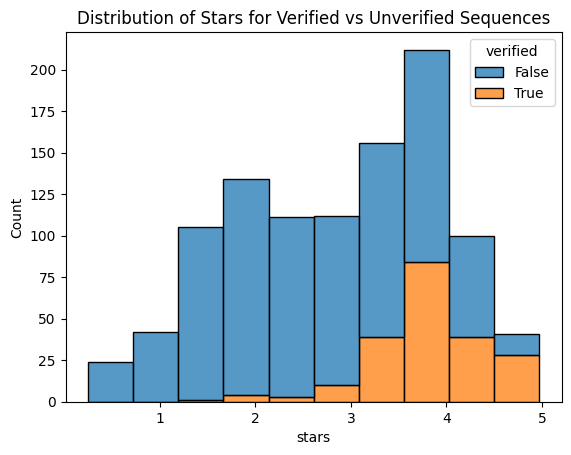

In [13]:
# now make the same graph as above but only for the df_lh_ver dataframe
sns.histplot(data=df_lh_ver, x="stars", hue="verified", multiple="stack", bins=10)
plt.title("Distribution of Stars for Verified vs Unverified Sequences")
plt.show()


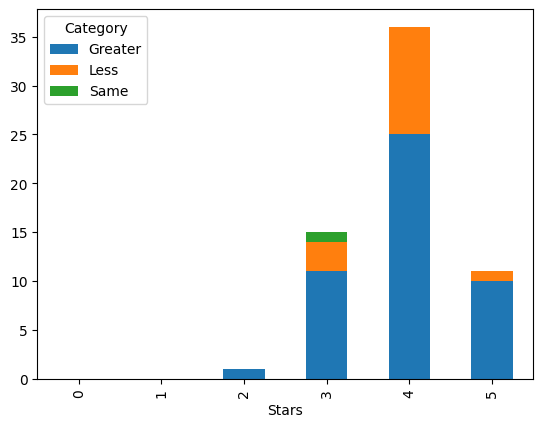

In [14]:
# filter for each unique plate and mabid and compare the stars for the verified vs unverified sequences
# create a dictionary that counts how often the verified has a higher score than the unverified vs lower vs same
# then create a dataframe from the dictionary
count_dict = {}
for i in range(0,6):
    count_dict[f"Greater {i}"] = 0
    count_dict[f"Less {i}"] = 0
    count_dict[f"Same {i}"] = 0
    
for plate, mabid in df_lh_ver.groupby(["plate", "entry__mabid"]).groups.keys():
    verified = df_lh_ver[(df_lh_ver["plate"]==plate) & (df_lh_ver["entry__mabid"]==mabid) & (df_lh_ver["verified"]==True)]["stars"].values
    unverified = df_lh_ver[(df_lh_ver["plate"]==plate) & (df_lh_ver["entry__mabid"]==mabid) & (df_lh_ver["verified"]==False)]["stars"].values
    if len(verified)==1 and len(unverified)==1:# and (verified[0]>3 or unverified[0]>3):
        round_ver = [round(i) for i in verified]
        round_unver = [round(i) for i in unverified]
        max_ver = max(round_ver, round_unver)
        max_ver = max_ver[0]
        if verified>unverified:
            count_dict[f"Greater {max_ver}"] += 1
        elif verified<unverified:
            count_dict[f"Less {max_ver}"] += 1
        else:
            count_dict[f"Same {max_ver}"] += 1

df_count = pd.DataFrame.from_dict(count_dict, orient="index", columns=["Count"])
# split the index into another column based on the last empty space
df_count["Category"] = df_count.index.str.split(" ").str[0]
df_count["Stars"] = df_count.index.str.split(" ").str[1]

df_count.pivot(index="Stars", columns="Category", values="Count").plot(kind="bar", stacked=True)
plt.show()

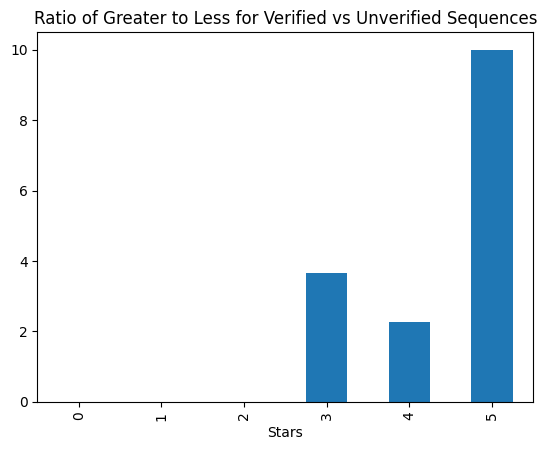

In [15]:
gtlts = df_count.pivot(index="Stars", columns="Category", values="Count")
gtlts["ratio"] = gtlts["Greater"]/gtlts["Less"]
gtlts["ratio"].plot(kind="bar")
plt.title("Ratio of Greater to Less for Verified vs Unverified Sequences")
plt.show()

In [16]:
# generate some summary text for the figures above
print(f"Total number of verified sequences: {len(df_lh_ver[df_lh_ver['verified']==True])}")
print(f"Total number of unverified sequences: {len(df_lh_ver[df_lh_ver['verified']==False])}")
print(f"Total number of verified sequences with a higher star score: {sum(gtlts['Greater'])}")
print(f"Total number of verified sequences with a lower star score: {sum(gtlts['Less'])}")
print(f"Total number of verified sequences with the same star score: {sum(gtlts['Same'])}")
print(f"Ratio across all stars of verified sequences with a higher star score: {sum(gtlts['Greater'])/sum(gtlts['Less'])}")

Total number of verified sequences: 208
Total number of unverified sequences: 829
Total number of verified sequences with a higher star score: 47
Total number of verified sequences with a lower star score: 15
Total number of verified sequences with the same star score: 1
Ratio across all stars of verified sequences with a higher star score: 3.1333333333333333


In [17]:
#df_lh["duplication_category_score"] = [int(i[-1]) for i in df_lh["duplication_category"].str.split(",")]
df_lh["asv_pct_score"] = 100*(df_lh["asv_support"]/df_lh["total_reads"])
df_lh["domain"] = df_lh.domain.str.replace(",","")
df_lh["dl"] = [len(i) for i in df_lh["domain"]]
df_lh["log_asv_support"] = np.log10(df_lh["asv_support"])

df_lh_l = df_lh[(df_lh["chain"]=="Light")]# & (df_lh["dl"]==127)]
df_lh_h = df_lh[(df_lh["chain"]=="Heavy")]# & (df_lh["dl"]==128)]

In [18]:
# create a dictionary of the positions and amino acids
pos_dict = {"pos": [], "aa": []}
for index, row in df_lh_l.iterrows():
    for value, pos in zip(*[row["domain"]], range(1, len(row["domain"]))):
        pos_dict['pos'].append(pos)
        pos_dict['aa'].append(value)          

# create a dataframe with the positions and amino acids
pos_dicth = {"pos": [], "aa": []}
for index, row in df_lh_h.iterrows():
    for value, pos in zip(*[row["domain"]], range(1, len(row["domain"]))):
        pos_dicth['pos'].append(pos)
        pos_dicth['aa'].append(value)          

/opt/anaconda3/envs/trimmer_lab/lib/python3.8/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


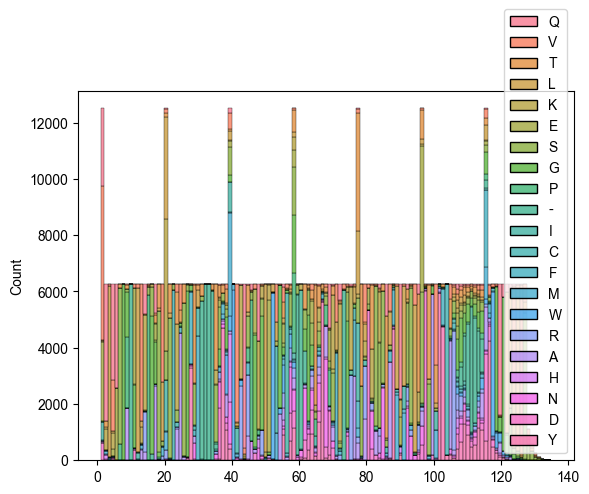

In [19]:
sns.histplot(x=pos_dicth["pos"], hue=pos_dicth["aa"], multiple="stack",bins=127)
sns.set(rc={'figure.figsize':(20.7,20.27)})

plt.show()

/opt/anaconda3/envs/trimmer_lab/lib/python3.8/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


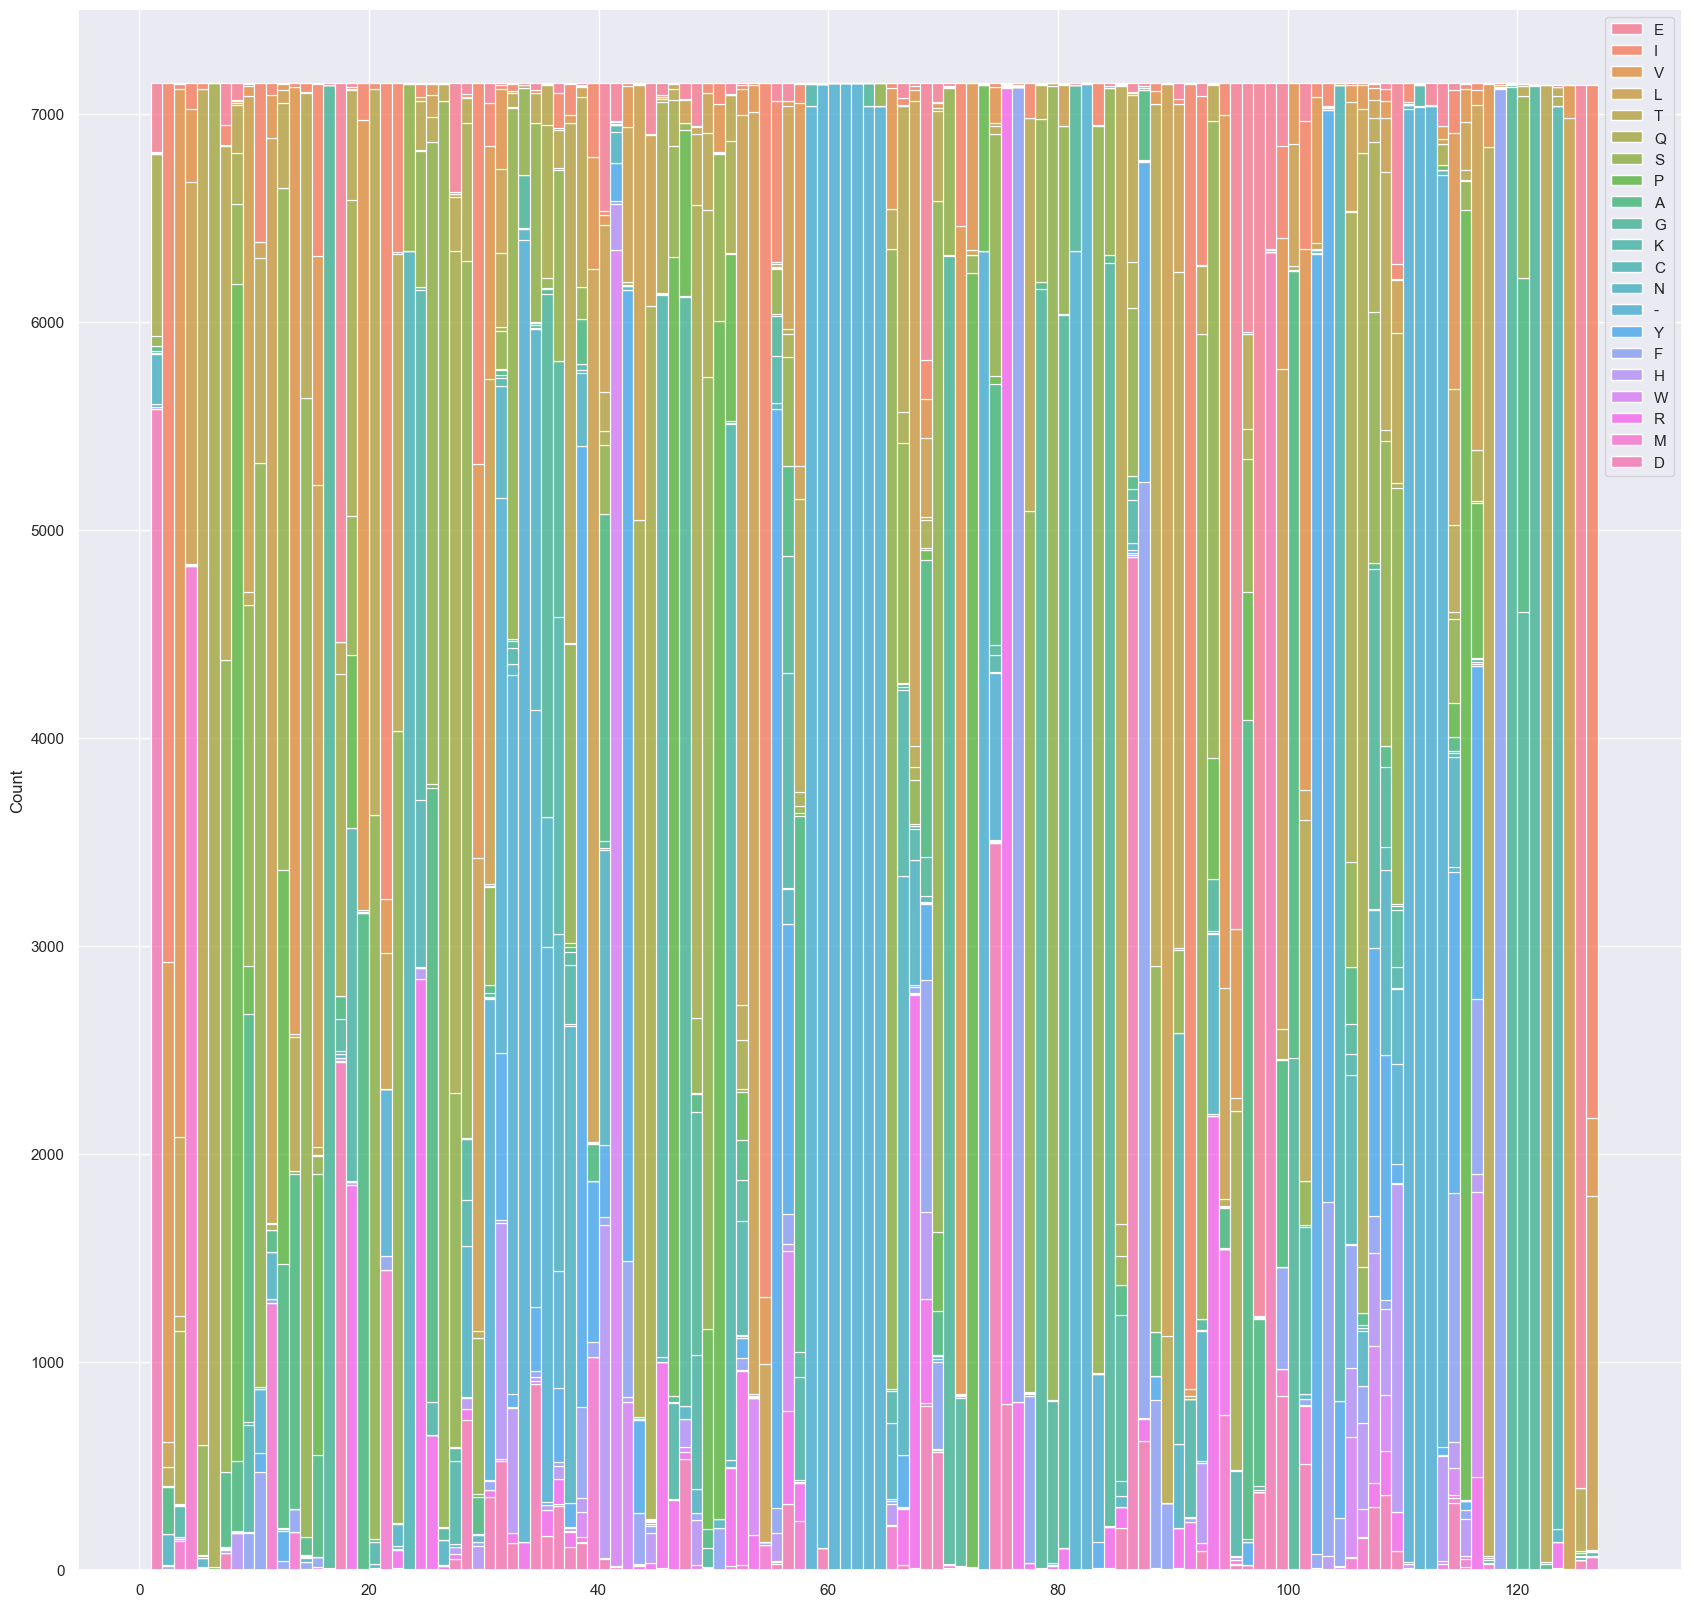

In [20]:
sns.histplot(x=pos_dict["pos"], hue=pos_dict["aa"], multiple="stack",bins=127)
sns.set(rc={'figure.figsize':(20.7,20.27)})
plt.show()

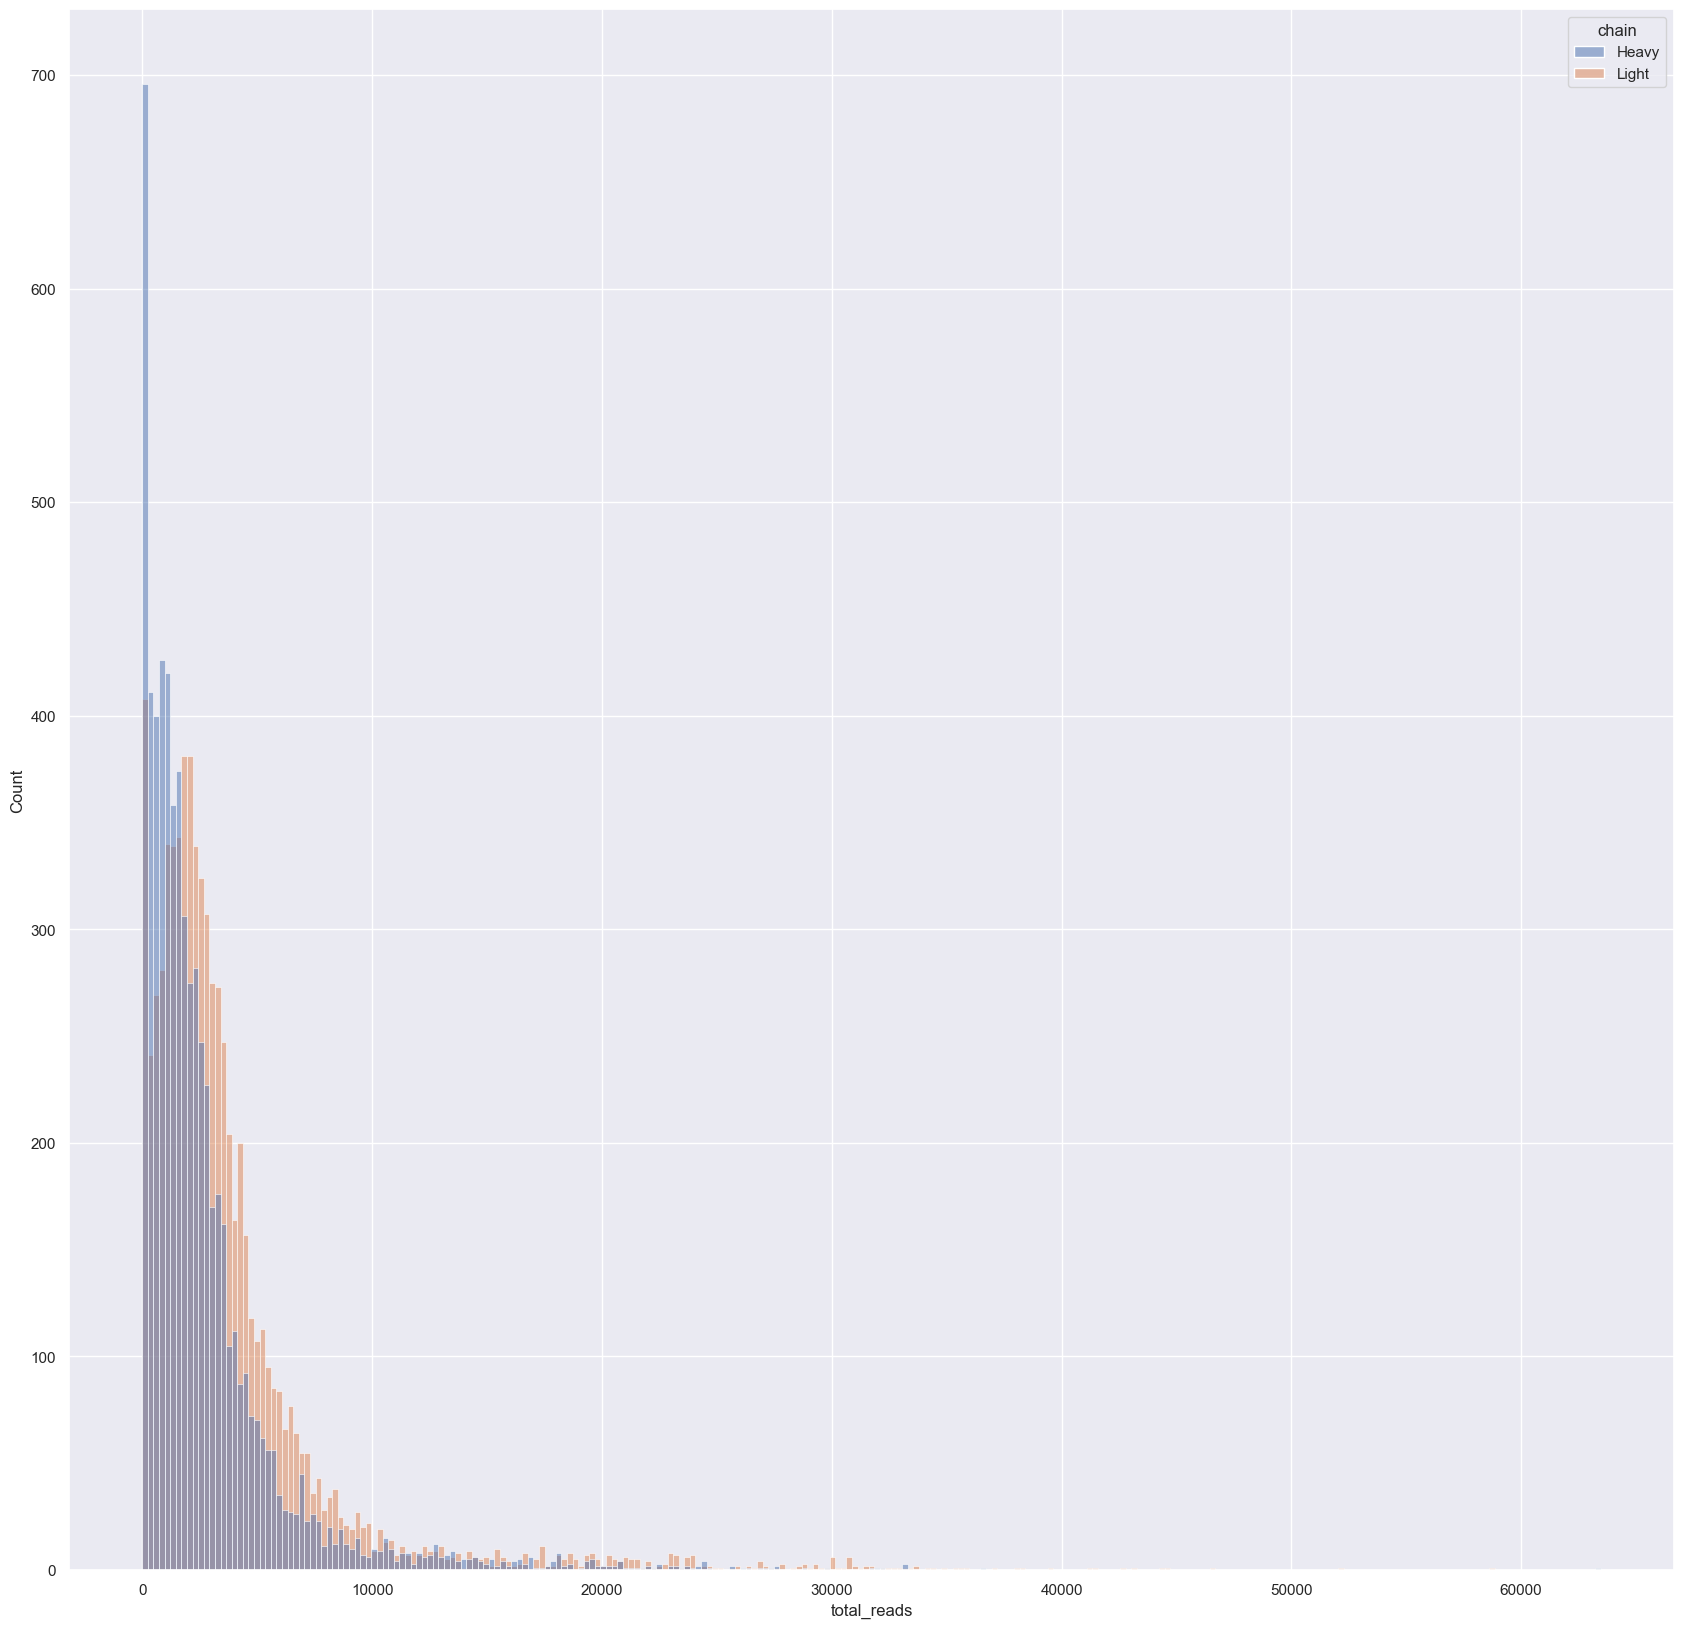

In [21]:
df_lh["log_total_reads"] = np.log10(df_lh["total_reads"])
sns.histplot(df_lh, x="total_reads", hue="chain")
plt.show()


# Start to run the categorization from the cat_from_mabidlist function and create scores from these results
- 0 CATEGORY: These are ok. No sublone in them
- 1 CATEGORY: These are ok as well. All IDs match.
- 2 CATEGORY: just the subclone
- 3 CATEGORY: likely typos with groups more then 2
- 4 CATEGORY: same as 3 but no requirement for more then 2 entries
- 5 CATEGORY: bad?


In [22]:
# filter out the % ones for now as well as the positive and negative controls
df_lh = df_lh[df_lh['entry__mabid'].str.contains("%")==False]
df_lh = df_lh[df_lh['entry__mabid'].str.contains("positive")==False]
df_lh = df_lh[df_lh['entry__mabid'].str.contains("negative")==False]

In [23]:
df_lh

,seq,chain,entry__mabid,entry__clonality,entry__category,pk,asv_support,total_reads,domain,plate,vector_sequence,stars,verified,asv_pct_score,dl,log_asv_support,log_total_reads
0,ACAAGTGTGCAGCCATGGGCAGGCTTACTTCTTCATTCTTGCTACT...,Heavy,L130/1.1,Monoclonal,1.0,2,533.00000,536,QVTLKESGP-GILQPSQTLSLTCSFSGFSLS--TSGMSVGWIRQPS...,TRIMMER0002_P2,CAGGTTACTCTGAAAGAGTCTGGCCCTGGGATATTGCAGCCCTCCC...,4.68,True,99.44029850746268656716417910,128,2.726727209026572263715917008,2.729165
1,GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...,Light,L130/1.1,Monoclonal,1.0,90,4228.00000,4353,EIVLTQSPTTLAASPGEKITITCSANSSIT-----SNYFHWYQQKP...,TRIMMER0002_P2,GAAATTGTGCTCACCCAGTCTCCAACCACCTTGGCTGCATCTCCCG...,4.64,True,97.12841718355157362738341374,127,3.626134978635388658008767103,3.638789
2,AACATATGTCCAATGTCCTCTCCTCAGACACTGAACACACTGACTC...,Heavy,L80/21.1,Monoclonal,1.0,3,953.00000,956,EVQLQQSGP-DLVKPGASVQISCTTSGYTF----TEYTIHWVKQSH...,TRIMMER0002_P2,GAGGTCCAGCTGCAACAGTCTGGACCTGACCTGGTGAAGCCTGGGG...,4.99,True,99.68619246861924686192468619,128,2.979092900638326408532939848,2.980458
3,AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...,Light,L80/21.1,Monoclonal,1.0,91,3518.00000,3631,QIVLTQSPAIMSAFPGERVTMTCSASSSV-------NYMHWLQQKS...,TRIMMER0002_P2,CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATTTCCAG...,4.94,True,96.88790966675846874139355549,127,3.546295835121442456497431489,3.560026
4,GACATAGAGGCACCTAACTCTGGACTCACAAGTCTTTCCCTTCAGT...,Heavy,L106/83.1,Monoclonal,1.0,4,566.00000,568,EVKLYETGG-GLVQPGRPMKLSCVASGFTF----SDYWMNWVRQSP...,TRIMMER0002_P2,GAGGTGAAGCTGTATGAGACTGGAGGAGGCTTGGTGCAACCTGGGA...,3.83,True,99.64788732394366197183098592,128,2.752816431188271430772690805,2.754348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13396,ATGGTCCACACAAACTCAGGGAAAGTTTGAAGATGGTATCCACACC...,Light,K39/25.3,Monoclonal,1.0,25245,1216.00000,1599,DILLTQSPAILSVSPGERVSFSCRASQSI------GTSIHWYQQRT...,PRnD,GACATCTTGCTGACTCAGTCTCCAGCCATCCTGTCTGTGAGTCCAG...,4.52,False,76.04752970606629143214509068,127,3.084933574936716132818766844,3.203848
13397,ATGAGCACTGTTTTCTCTACAGTCACTGAATCTCAAGGTCCTTACA...,Heavy,K58/35.4,Monoclonal,2.0,25217,727.00000,727,EVQLQQSGA-ELVRPGALVKLSCTASGFNI----RDYYMHWMRQRP...,PRnD,GAGGTTCAGCTGCAGCAGTCTGGGGCTGAGCTTGTGAGGCCAGGGG...,3.16,False,100.00000,129,2.861534410859037836213464249,2.861534
13398,GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...,Light,K58/35.4,Monoclonal,2.0,25246,1595.00000,1721,DIVMTQSPKFMSTSVGDRVSVTCKASQNV------DTDVAWYQQKA...,PRnD,GACATTGTGATGACCCAGTCTCCAAAATTCATGTCCACATCAGTAG...,4.17,False,92.67867518884369552585705985,127,3.202760687393199932869307839,3.235781
13399,GACATAGAGTCTAACCATGGAATGGAACTGGGTCGTTCTCTTCCTC...,Heavy,L109/57.1,Monoclonal,1.0,25218,1713.00000,1720,QGQMQQSGA-ELVKPGASVKLSCKTSGFTF----SSSYISWLKQKP...,PRnD,CAGGGTCAGATGCAGCAGTCTGGAGCTGAGCTGGTGAAGCCTGGGG...,3.15,True,99.59302325581395348837209302,128,3.233757362965510487335312033,3.235528


In [24]:
mysers = df_lh.groupby("seq")['entry__mabid',].transform(lambda x: ','.join(x))
mypks = df_lh.groupby("seq")['pk'].transform(lambda x: ','.join(x))
mychains = df_lh.groupby("seq")['chain'].transform(lambda x: ','.join(x))
myvecs = df_lh.groupby("seq")['vector_sequence'].transform(lambda x: ','.join(x))


In [25]:
mypks

0                                      2,18396,18403,21844
1                                     90,18495,18504,21949
2                                   3,5164,5171,5248,17874
3                             91,5257,5268,5357,5346,17981
4                                                  4,19842
                               ...                        
13396    5262,5271,5279,5288,5291,5297,5305,5316,5336,1...
13397                                                25217
13398                                    18498,18508,25246
13399                                                25218
13400                            3556,3564,3572,3581,25247
Name: pk, Length: 13401, dtype: object

In [26]:
# TODO how do we know these two are the same length
import traceback
new_cats_from_db = pd.DataFrame([cat_from_mabidlist(i) for i in mysers["entry__mabid"]], columns=["cat","parents","sublcones","projects","scores"]).set_index("cat")
new_cats_from_db["pks"] = mypks.values
new_cats_from_db["chains"] = mychains.values
new_cats_from_db["vector_seqs"] = myvecs.values

new_cats_from_db = new_cats_from_db.reset_index()
new_cats_from_db

Traceback (most recent call last):
  File "<ipython-input-4-d4912fe3fb8a>", line 15, in cat_from_mabidlist
    subclones = [i.split('/')[1].split('.')[1].replace(' ', '') for i in mab_id_list]
  File "<ipython-input-4-d4912fe3fb8a>", line 15, in <listcomp>
    subclones = [i.split('/')[1].split('.')[1].replace(' ', '') for i in mab_id_list]
IndexError: list index out of range
Traceback (most recent call last):
  File "<ipython-input-4-d4912fe3fb8a>", line 15, in cat_from_mabidlist
    subclones = [i.split('/')[1].split('.')[1].replace(' ', '') for i in mab_id_list]
  File "<ipython-input-4-d4912fe3fb8a>", line 15, in <listcomp>
    subclones = [i.split('/')[1].split('.')[1].replace(' ', '') for i in mab_id_list]
IndexError: list index out of range
Traceback (most recent call last):
  File "<ipython-input-4-d4912fe3fb8a>", line 15, in cat_from_mabidlist
    subclones = [i.split('/')[1].split('.')[1].replace(' ', '') for i in mab_id_list]
  File "<ipython-input-4-d4912fe3fb8a>", line 15,

,cat,parents,sublcones,projects,scores,pks,chains,vector_seqs
0,"(2, Parents and Projects Match , 100)","[L130/1, L130/1, L130/1, L130/1]","[L130/1.1, L130/1.2, L130/1.3, L130/1.5]","[L130, L130, L130, L130]","[4.0, 4.0, 4.0, 4.0]","2,18396,18403,21844","Heavy,Heavy,Heavy,Heavy",CAGGTTACTCTGAAAGAGTCTGGCCCTGGGATATTGCAGCCCTCCC...
1,"(2, Parents and Projects Match , 100)","[L130/1, L130/1, L130/1, L130/1]","[L130/1.1, L130/1.2, L130/1.3, L130/1.5]","[L130, L130, L130, L130]","[4.0, 4.0, 4.0, 4.0]","90,18495,18504,21949","Light,Light,Light,Light",GAAATTGTGCTCACCCAGTCTCCAACCACCTTGGCTGCATCTCCCG...
2,"(2, Parents and Projects Match , 100)","[L80/21, L80/21, L80/21, L80/21, L80/21]","[L80/21.1, L80/21.4, L80/21.5, L80/21.3, L80/2...","[L80, L80, L80, L80, L80]","[5.0, 5.0, 5.0, 5.0, 5.0]","3,5164,5171,5248,17874","Heavy,Heavy,Heavy,Heavy,Heavy",GAGGTCCAGCTGCAACAGTCTGGACCTGACCTGGTGAAGCCTGGGG...
3,"(2, Parents and Projects Match , 100)","[L80/21, L80/21, L80/21, L80/21, L80/21, L80/21]","[L80/21.1, L80/21.4, L80/21.5, L80/21.3, L80/2...","[L80, L80, L80, L80, L80, L80]","[6.0, 6.0, 6.0, 6.0, 5.5, 5.5]","91,5257,5268,5357,5346,17981","Light,Light,Light,Light,Light,Light",CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATTTCCAG...
4,"(9, Bad, 0)","[L106/83, L106/83]","[L106/83.1, L106/83.2]","[L106, L106]","[2.0, 2.0]","4,19842","Heavy,Heavy",GAGGTGAAGCTGTATGAGACTGGAGGAGGCTTGGTGCAACCTGGGA...
...,...,...,...,...,...,...,...,...
13396,"(2, Parents and Projects Match , 100)","[K39/25, K39/25, K39/25, K39/25, K39/25, K39/2...","[K39/25.6, K39/25.1, K39/25.2, K39/25.4, K39/2...","[K39, K39, K39, K39, K39, K39, K39, K39, K39, ...","[12.0, 11.5, 12.0, 12.0, 11.5, 12.0, 12.0, 12....","5262,5271,5279,5288,5291,5297,5305,5316,5336,1...","Light,Light,Light,Light,Light,Light,Light,Ligh...",GACATCTTGCTGACTCAGTCTCCAGCCATCCTGTCTGTGAGTCCAG...
13397,"(9, Bad, 0)",[K58/35],[K58/35.4],[K58],[1.0],25217,Heavy,GAGGTTCAGCTGCAGCAGTCTGGGGCTGAGCTTGTGAGGCCAGGGG...
13398,"(2, Parents and Projects Match , 100)","[K58/35, K58/35, K58/35]","[K58/35.2, K58/35.3, K58/35.4]","[K58, K58, K58]","[3.0, 3.0, 3.0]","18498,18508,25246","Light,Light,Light",GACATTGTGATGACCCAGTCTCCAAAATTCATGTCCACATCAGTAG...
13399,"(9, Bad, 0)",[L109/57],[L109/57.1],[L109],[1.0],25218,Heavy,CAGGGTCAGATGCAGCAGTCTGGAGCTGAGCTGGTGAAGCCTGGGG...


## See which ones are problematic and failed categorization

In [27]:
new_cats_from_db[new_cats_from_db["cat"].apply(lambda x: 'Failed Categorization' in x)]


,cat,parents,sublcones,projects,scores,pks,chains,vector_seqs
8,"(-11, Failed Categorization, 0)","[N123/48, N123/48, N123/48, 1F1]","[N123/48.1, N123/48.2, N123/48.1, 1F1.1.1.18]","[N123, N123, N123, 1F1.1.1.18]","[0, 0, 0, 0]","6,18449,19831,19847","Heavy,Heavy,Heavy,Heavy",GAAGTGAAGCTGGTGGAGTCTGGGGGAGGTTTAGTGCAGCCTGGAG...
9,"(-11, Failed Categorization, 0)","[N123/48, N105/17, N123/48, N123/48, 1F1]","[N123/48.1, N105/17.1, N123/48.2, N123/48.1, 1...","[N123, N105, N123, N123, 1F1.1.1.18]","[0, 0, 0, 0, 0]","95,175,18556,19927,19942","Light,Light,Light,Light,Light",CAACTTATGCTCACTCAGTCATCTTCAGCCTCTTTCTCCCTGGGAG...
36,"(-11, Failed Categorization, 0)","[62-3G1, 62-3G1, 62-3G1]","[62-3G1.1, 62-3G1.2, 62-3G1.3]","[62-3G1.1, 62-3G1.2, 62-3G1.3]","[0, 0, 0]","20,19405,19416","Heavy,Heavy,Heavy",CAGGTCCACCTGCAGCAGTCTGGACCTGAGCTGGTGAAGCCTGGGG...
37,"(-11, Failed Categorization, 0)","[62-3G1, 62-3G1, 62-3G1]","[62-3G1.1, 62-3G1.2, 62-3G1.3]","[62-3G1.1, 62-3G1.2, 62-3G1.3]","[0, 0, 0]","109,19531,19544","Light,Light,Light",GATGTTGTGATGACCCAGACTCCTCTCACTTTGTCGGTTACCATTG...
53,"(-11, Failed Categorization, 0)","[1D8, 1D8, 1D8]","[1D8.1, 1D8.4, 1D8.5]","[1D8.1, 1D8.4, 1D8.5]","[0, 0, 0]","118,19511,19522","Light,Light,Light",GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...
...,...,...,...,...,...,...,...,...
12979,"(-11, Failed Categorization, 0)","[N194/13, EMPTY, N194/13, N194/13]","[N194/13.1, EMPTY, N194/13.5, N194/13.4]","[N194, EMPTY, N194, N194]","[0, 0, 0, 0]","4315,23935,24790,24810","Heavy,Heavy,Heavy,Heavy",CAGGTTCAGCTCCAGCAGTCTGGGGCTGAGCTGGCAAGACCTGGGG...
12980,"(-11, Failed Categorization, 0)","[N194/13, EMPTY, N194/13, N194/13]","[N194/13.1, EMPTY, N194/13.5, N194/13.4]","[N194, EMPTY, N194, N194]","[0, 0, 0, 0]","4406,24027,24843,24865","Light,Light,Light,Light",GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...
13019,"(-11, Failed Categorization, 0)","[N194/13, EMPTY, N194/13, N194/13]","[N194/13.1, EMPTY, N194/13.5, N194/13.4]","[N194, EMPTY, N194, N194]","[0, 0, 0, 0]","4315,23935,24790,24810","Heavy,Heavy,Heavy,Heavy",CAGGTTCAGCTCCAGCAGTCTGGGGCTGAGCTGGCAAGACCTGGGG...
13020,"(-11, Failed Categorization, 0)","[N194/13, EMPTY, N194/13, N194/13]","[N194/13.1, EMPTY, N194/13.5, N194/13.4]","[N194, EMPTY, N194, N194]","[0, 0, 0, 0]","4406,24027,24843,24865","Light,Light,Light,Light",GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...


## Set the scores and duplication category

In [28]:

df_lh["duplication_category"] = ""
df_lh["score"] = 0

df_lh.index = df_lh["pk"]
for index, row in new_cats_from_db.iterrows():
    for score,pk in zip(row["scores"], row["pks"].split(",")):
        df_lh.loc[df_lh.pk == pk, "duplication_category"] = ",".join([str(i) for i in row["cat"]])
        df_lh.loc[df_lh.pk == pk, "score"] = score


## Create scores
- Create the asv stars and add that to the total
- Create the log score and add it to the total


In [29]:
# could we have users update this in the future
df_lh["stars"] = 0
df_lh["stars"] += df_lh["asv_pct_score"]/100 * 2
df_lh["logscore"] = np.log(df_lh["score"]+1)
df_lh[df_lh["score"]>5].sort_values("logscore")

,seq,chain,entry__mabid,entry__clonality,entry__category,pk,asv_support,total_reads,domain,plate,vector_sequence,stars,verified,asv_pct_score,dl,log_asv_support,log_total_reads,duplication_category,score,logscore
pk,,,,,,,,,,,,,,,,,,,,
18203,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...,Light,N112B/14.2,Monoclonal,3.0,18203,3367.00000,3792,YVVLTQTPLSLPVSLGDQASISCRSNQSLVHS-NGNTYLHWYLQKP...,TRIMMER0075_PS3,TATGTTGTGTTGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...,1.775843881856540084388185654,True,88.79219409282700421940928270,127,3.527243116388088596727172106,3.578868,"9,Bad,0",5.045455,1.799307
6084,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...,Light,N112B/14.2,Monoclonal,3.0,6084,3314.00000,3659,YVVLTQTPLSLPVSLGDQASISCRSNQSLVHS-NGNTYLHWYLQKP...,TRIMMER0039_P23,TATGTTGTGTTGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...,1.811423886307734353648537852,True,90.57119431538671768242689259,127,3.520352504083317937340231118,3.563362,"9,Bad,0",5.045455,1.799307
22012,GTATGAACCTAGCCCTGATTTCCCCAGCCTTCAGTTCCCAGATTCA...,Heavy,L95A/60.6,Monoclonal,2.0,22012,3765.00000,3953,EVKLVESGG-GLVQP-GGSLRLSCATSGFT-----FTDYDMTWVRQ...,TRIMMER0095_P84,GAAGTGAAGCTGGTGGAGTCTGGAGGAGGCTTGGTACAGCCTGGGG...,1.904882367821907412092081963,False,95.24411839109537060460409815,128,3.575764980536719381421838325,3.596927,"9,Bad,0",5.100000,1.808289
22098,GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...,Light,L95A/60.6,Monoclonal,2.0,22098,1993.00000,4349,DIKMTQSPSSMYASLGERVTITCKASQDI------NSYLSWFQQKP...,TRIMMER0095_P84,GACATCAAGATGACCCAGTCTCCATCTTCCATGTATGCATCTCTAG...,0.9165325362152218900896757876,False,45.82662681076109450448378938,127,3.299507298700487603563402973,3.638389,"9,Bad,0",5.100000,1.808289
24770,GTATGAACCTAGCCCTGATTTCCCCAGCCTTCAGTTCCCAGATTCA...,Heavy,L95A/60.6,Monoclonal,2.0,24770,1483.00000,1518,EVKLVESGG-GLVQP-GGSLRLSCATSGFT-----FTDYDMTWVRQ...,TRIMMER00112_P100,GAAGTGAAGCTGGTGGAGTCTGGAGGAGGCTTGGTACAGCCTGGGG...,1.953886693017127799736495389,False,97.69433465085638998682476943,128,3.171141151028382025441180097,3.181272,"9,Bad,0",5.100000,1.808289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5072,ACTTTTGACTCACCATATCAAGTTCGCAGAATGAGGTTCTCTGCTC...,Light,K20/78.4B,Monoclonal,3.0,5072,1855.00000,2067,DIVMTQAAFSNPVTLGTSVSISCRSSKSLLHS-DGITYLYWYLQRP...,TRIMMER0034_P18,GATATTGTGATGACGCAGGCTGCATTCTCCAATCCAGTCACTCTTG...,1.794871794871794871794871795,False,89.74358974358974358974358974,127,3.268343913951064681131469655,3.315340,"9,Bad,0",14.937500,2.768675
5053,ACTTTTGACTCACCATATCAAGTTCGCAGAATGAGGTTCTCTGCTC...,Light,K20/78.2B,Monoclonal,3.0,5053,867.00000,1022,DIVMTQAAFSNPVTLGTSVSISCRSSKSLLHS-DGITYLYWYLQRP...,TRIMMER0034_P18,GATATTGTGATGACGCAGGCTGCATTCTCCAATCCAGTCACTCTTG...,1.696673189823874755381604697,False,84.83365949119373776908023483,127,2.938019097476210294375367692,3.009451,"9,Bad,0",14.937500,2.768675
17171,ACTTTTGACTCACCATATCAAGTTCGCAGAATGAGGTTCTCTGCTC...,Light,K20/78.5,Monoclonal,1.0,17171,1837.00000,2711,DIVMTQAAFSNPVTLGTSVSISCRSSKSLLHS-DGITYLYWYLQRP...,TRIMMER0067_P66,GATATTGTGATGACGCAGGCTGCATTCTCCAATCCAGTCACTCTTG...,1.355219476208041313168572482,False,67.76097381040206565842862412,127,3.264109156305808320734275881,3.433130,"9,Bad,0",14.937500,2.768675


## Create a backup and then create a final baseline score with a ceiling of three for the 

In [30]:
df_lh_bu = df_lh
baseline3star = np.log(6) # those with 5 we want to have 3 stars
# 0 still has a score of 0
df_lh_bu["dup_final_score"] = (df_lh_bu["logscore"]/baseline3star)*3
df_lh_bu['dup_final_score'] = df_lh_bu['dup_final_score'].clip(upper=3)
df_lh_bu["stars"] = df_lh_bu["stars"].astype(float) + df_lh_bu['dup_final_score'].astype(float)

In [31]:
df_lh_bu

,seq,chain,entry__mabid,entry__clonality,entry__category,pk,asv_support,total_reads,domain,plate,...,stars,verified,asv_pct_score,dl,log_asv_support,log_total_reads,duplication_category,score,logscore,dup_final_score
pk,,,,,,,,,,,,,,,,,,,,,
2,ACAAGTGTGCAGCCATGGGCAGGCTTACTTCTTCATTCTTGCTACT...,Heavy,L130/1.1,Monoclonal,1.0,2,533.00000,536,QVTLKESGP-GILQPSQTLSLTCSFSGFSLS--TSGMSVGWIRQPS...,TRIMMER0002_P2,...,4.683539,True,99.44029850746268656716417910,128,2.726727209026572263715917008,2.729165,"2,Parents and Projects Match ,100",4.0,1.609438,2.694733
90,GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...,Light,L130/1.1,Monoclonal,1.0,90,4228.00000,4353,EIVLTQSPTTLAASPGEKITITCSANSSIT-----SNYFHWYQQKP...,TRIMMER0002_P2,...,4.637302,True,97.12841718355157362738341374,127,3.626134978635388658008767103,3.638789,"2,Parents and Projects Match ,100",4.0,1.609438,2.694733
3,AACATATGTCCAATGTCCTCTCCTCAGACACTGAACACACTGACTC...,Heavy,L80/21.1,Monoclonal,1.0,3,953.00000,956,EVQLQQSGP-DLVKPGASVQISCTTSGYTF----TEYTIHWVKQSH...,TRIMMER0002_P2,...,4.993724,True,99.68619246861924686192468619,128,2.979092900638326408532939848,2.980458,"2,Parents and Projects Match ,100",5.0,1.791759,3.000000
91,AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...,Light,L80/21.1,Monoclonal,1.0,91,3518.00000,3631,QIVLTQSPAIMSAFPGERVTMTCSASSSV-------NYMHWLQQKS...,TRIMMER0002_P2,...,4.937758,True,96.88790966675846874139355549,127,3.546295835121442456497431489,3.560026,"2,Parents and Projects Match ,100",6.0,1.945910,3.000000
4,GACATAGAGGCACCTAACTCTGGACTCACAAGTCTTTCCCTTCAGT...,Heavy,L106/83.1,Monoclonal,1.0,4,566.00000,568,EVKLYETGG-GLVQPGRPMKLSCVASGFTF----SDYWMNWVRQSP...,TRIMMER0002_P2,...,3.832399,True,99.64788732394366197183098592,128,2.752816431188271430772690805,2.754348,"9,Bad,0",2.0,1.098612,1.839442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25245,ATGGTCCACACAAACTCAGGGAAAGTTTGAAGATGGTATCCACACC...,Light,K39/25.3,Monoclonal,1.0,25245,1216.00000,1599,DILLTQSPAILSVSPGERVSFSCRASQSI------GTSIHWYQQRT...,PRnD,...,4.520951,False,76.04752970606629143214509068,127,3.084933574936716132818766844,3.203848,"2,Parents and Projects Match ,100",12.0,2.564949,3.000000
25217,ATGAGCACTGTTTTCTCTACAGTCACTGAATCTCAAGGTCCTTACA...,Heavy,K58/35.4,Monoclonal,2.0,25217,727.00000,727,EVQLQQSGA-ELVRPGALVKLSCTASGFNI----RDYYMHWMRQRP...,PRnD,...,3.160558,False,100.00000,129,2.861534410859037836213464249,2.861534,"9,Bad,0",1.0,0.693147,1.160558
25246,GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...,Light,K58/35.4,Monoclonal,2.0,25246,1595.00000,1721,DIVMTQSPKFMSTSVGDRVSVTCKASQNV------DTDVAWYQQKA...,PRnD,...,4.174690,False,92.67867518884369552585705985,127,3.202760687393199932869307839,3.235781,"2,Parents and Projects Match ,100",3.0,1.386294,2.321117


# Plot the Matching and Duplication Score
- Plot the matching score
- Plot the function used to calculate the matching score

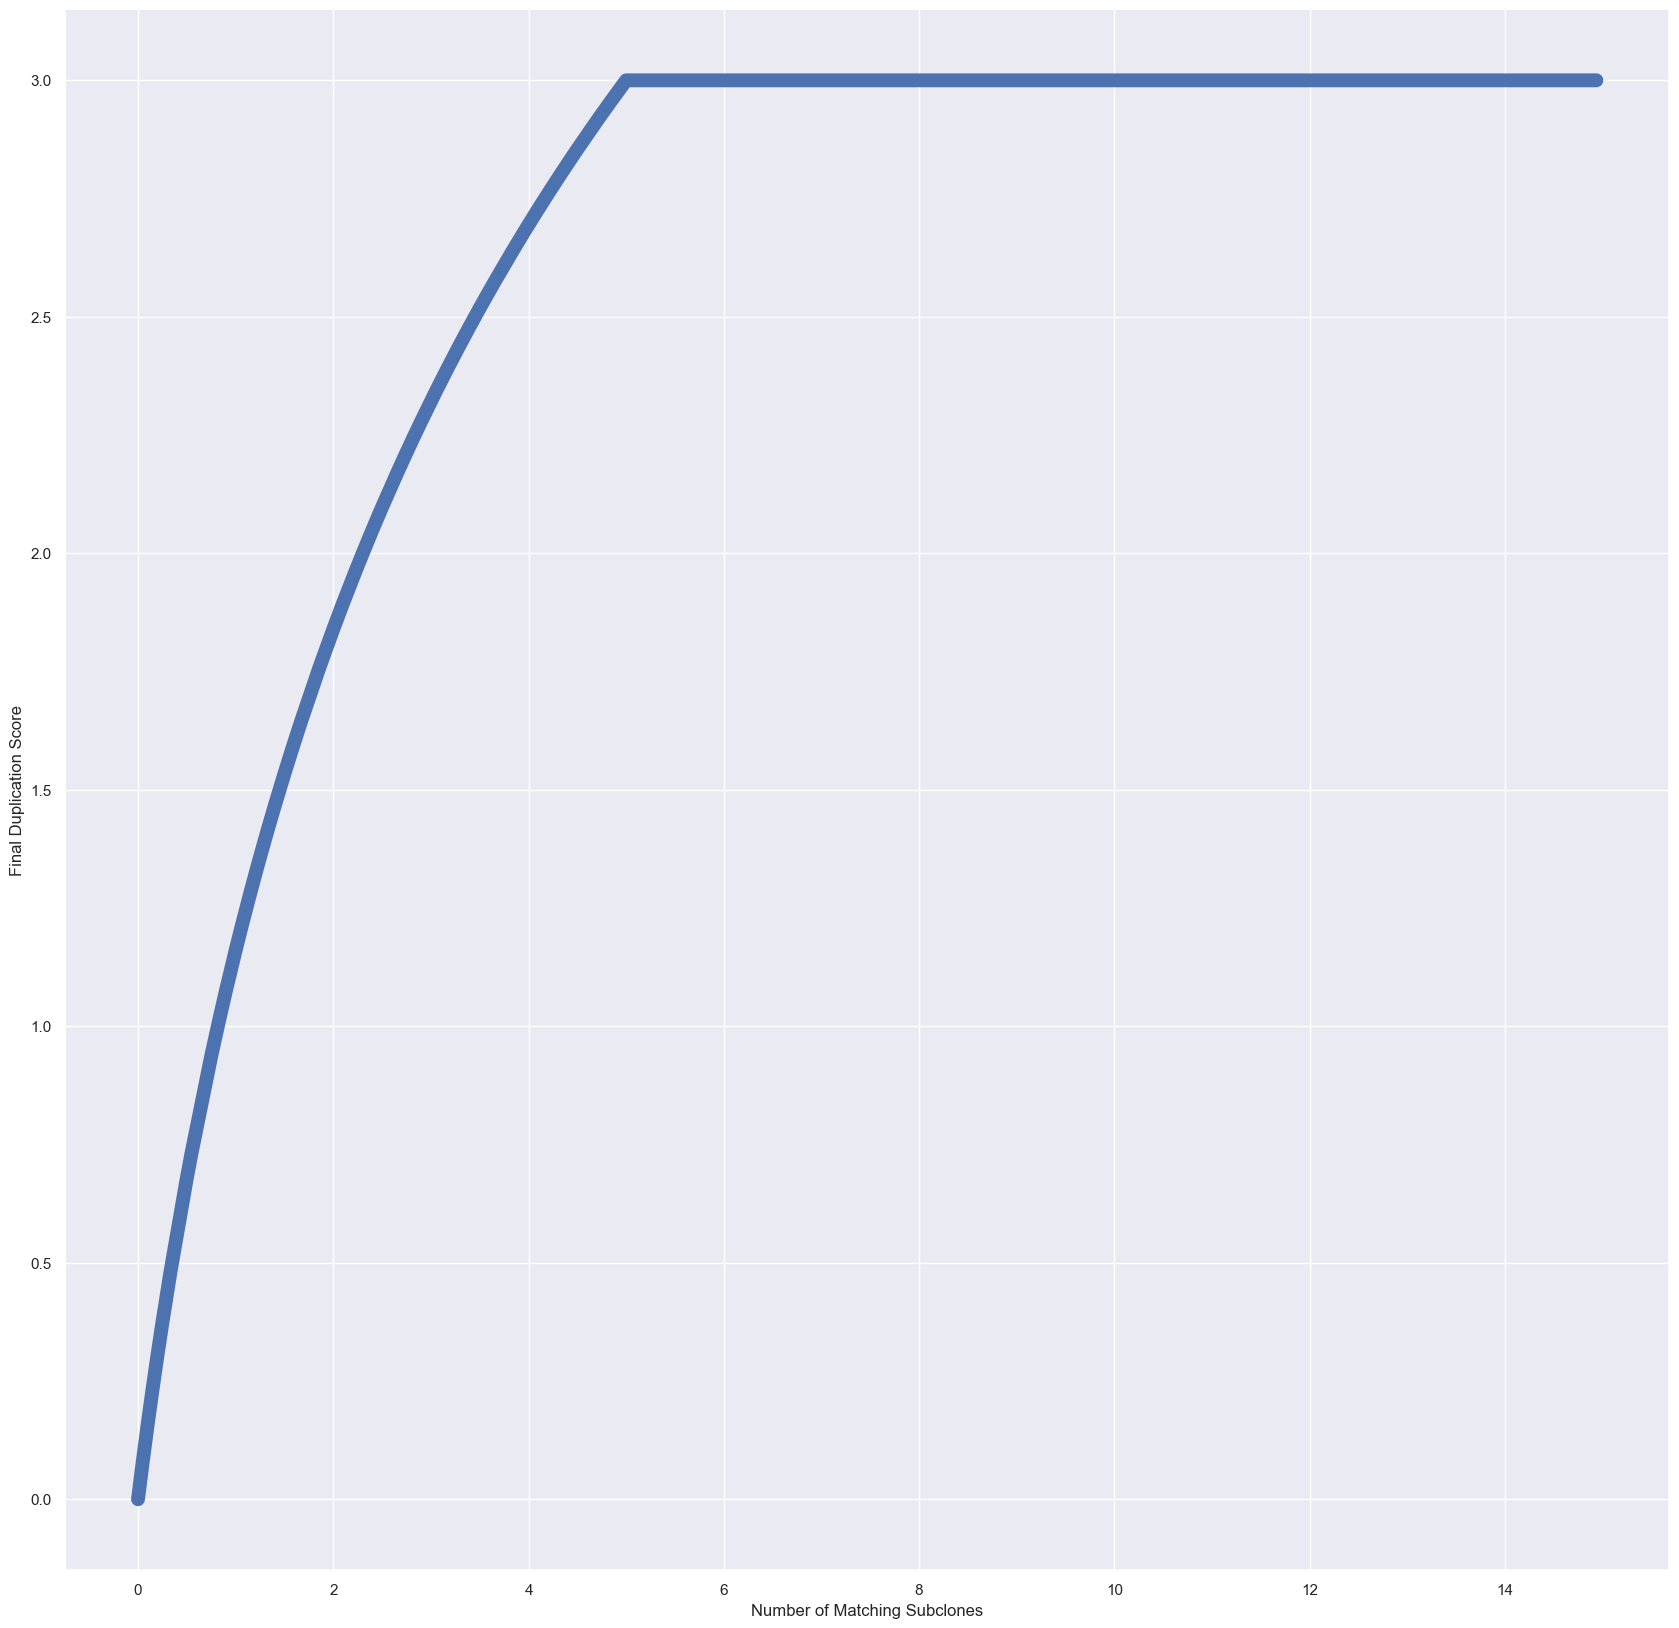

In [32]:
sns.lineplot(data=df_lh_bu, x="score", y="dup_final_score", linewidth=10)
sns.set(rc={'figure.figsize':(5.2,5.27)})

plt.xlabel("Number of Matching Subclones")
plt.ylabel("Final Duplication Score")
sns.set(font_scale=1)

plt.show()

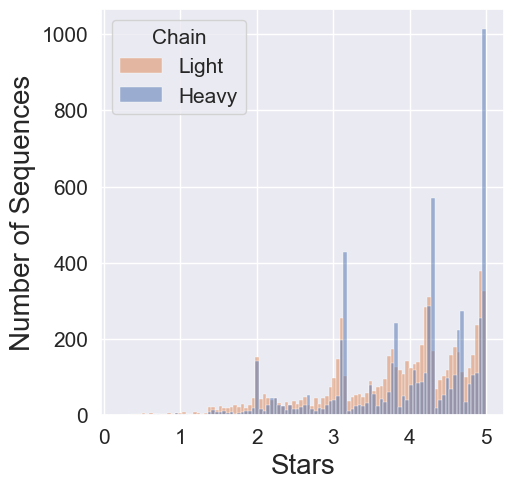

In [33]:
sns.histplot(df_lh_bu[df_lh_bu["stars"]<5.1], x="stars", hue="chain", bins=100)
sns.set(rc={'figure.figsize':(10.7,10.27)})
# set labels and title
plt.xlabel("Stars", size=20)
plt.ylabel("Number of Sequences", size=20)
# change the legend title and labels
plt.legend(title="Chain", fontsize=15, title_fontsize=15, loc='upper left', labels=["Light", "Heavy"])
sns.set(font_scale=1)
# increase x and y tick label size  
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# decrease the font
#plt.savefig("jupyter/paper_figures/Stars.png", dpi=300, bbox_inches='tight')

plt.show()


# Important df produced above
### newcatsfromdb : groubpy with scores
### df_lh_gb : scores for all sequences for a given mab based on the df_lh_bu
### df_lh_bu : scores per sequence with pk to update the db based on df_lh from above which is filtered to remove controls and mixtrue (%) samples


In [34]:
df_lh_bu["entry__mabid__full"] = df_lh_bu["entry__mabid"]
df_lh_bu["entry__mabid"] = df_lh_bu["entry__mabid"].str.split(pat=".").str.get(0)
df_lh_bu["entry__category"] = df_lh_bu["entry__category"].astype(str)
df_lh_bu["scorestr"] = df_lh_bu["score"].astype(str)
df_lh_gb = df_lh_bu.groupby(["entry__mabid","chain"]).agg({'seq': 'count', 
                                                           'entry__category': [', '.join], 
                                                           'scorestr': [', '.join]}).reset_index()
df_lh_gb.columns = ["mabid", "chain", "count", "categories in group", "scores"]
df_lh_gb = df_lh_gb.pivot(index='mabid', columns='chain')
df_lh_gb

count       categories in group                      \
chain    Heavy Light               Heavy               Light   
mabid                                                          
1D8        3.0   3.0       1.0, 3.0, 3.0       1.0, 3.0, 3.0   
1F1        4.0   4.0  1.0, 3.0, 3.0, 3.0  1.0, 3.0, 3.0, 3.0   
62-3G1     3.0   3.0       1.0, 3.0, 3.0       1.0, 3.0, 3.0   
8G10       1.0   1.0                 1.0                 1.0   
A12/18     3.0   3.0       1.0, 1.0, 1.0       1.0, 1.0, 1.0   
...        ...   ...                 ...                 ...   
N9C/24     1.0   2.0                 2.0            2.0, 2.0   
UNC65      2.0   2.0            1.0, 1.0            1.0, 1.0   
n152b/11   1.0   1.0                 2.0                 2.0   
n194/17    1.0   1.0                 2.0                 2.0   
n299/45    NaN   1.0                 NaN                 2.0   

                      scores                       
chain                  Heavy                Light  
mabid                                              
1D8            0.0, 0.0, 0.0        0.0, 0.0, 0.0  
1F1       0.0, 0.0, 0.0, 0.0   0.0, 0.0, 0.0, 0.0  
62-3G1         0.0, 0.0, 0.0        0.0, 0.0, 0.0  
8G10                     0.0                  0.0  
A12/18      2.25, 2.25, 2.25     2.25, 2.25, 2.25  
...                      ...                  ...  
N9C/24                   1.0             2.0, 2.0  
UNC65               0.0, 0.0             0.0, 0.0  
n152b/11                0.25                 0.25  
n194/17                  0.5  0.33333333333333337  
n299/45                  NaN                 0.25  

[2262 rows x 6 columns]

# Breakdown of the number of times mabid clone was sequenced successfully, 
- need to add dropouts to this

In [35]:
df_en = pd.DataFrame(list(TrimmerEntry.objects.filter(clonality="Monoclonal").values('mabid','id','category','clonality')))
df_en["mabid"] = df_en["mabid"].str.split(pat=".").str.get(0)
df_en["category"] = df_en["category"].astype(str)
df_en = df_en.groupby('mabid').agg({'id':'count', 'category': 'sum', 'category': [', '.join]})
df_en.columns = ["success_count","subclone_categories"]
df_en

,success_count,subclone_categories
mabid,,
10% N48676,2,"nan, nan"
12CA5,1,2.0
1D8,3,"1.0, 3.0, 3.0"
1F1,3,"1.0, 3.0, 3.0"
20% N486/76,2,"nan, nan"
...,...,...
positivecontrol1_N52A/42,4,"nan, nan, nan, nan"
positivecontrol1_N91/27,5,"nan, nan, nan, nan, nan"
positivecontrol2,3,"nan, nan, nan"


### Merge the entriy counts with the df_lh_gb to get succes

In [36]:
total_counts = df_en.merge(df_lh_gb, left_on="mabid", right_on='mabid')
total_counts

<ipython-input-36-63bf2862b846>:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  total_counts = df_en.merge(df_lh_gb, left_on="mabid", right_on='mabid')


,success_count,subclone_categories,"(count, Heavy)","(count, Light)","(categories in group, Heavy)","(categories in group, Light)","(scores, Heavy)","(scores, Light)"
mabid,,,,,,,,
1D8,3,"1.0, 3.0, 3.0",3.0,3.0,"1.0, 3.0, 3.0","1.0, 3.0, 3.0","0.0, 0.0, 0.0","0.0, 0.0, 0.0"
1F1,3,"1.0, 3.0, 3.0",4.0,4.0,"1.0, 3.0, 3.0, 3.0","1.0, 3.0, 3.0, 3.0","0.0, 0.0, 0.0, 0.0","0.0, 0.0, 0.0, 0.0"
62-3G1,3,"1.0, 3.0, 3.0",3.0,3.0,"1.0, 3.0, 3.0","1.0, 3.0, 3.0","0.0, 0.0, 0.0","0.0, 0.0, 0.0"
8G10,1,1.0,1.0,1.0,1.0,1.0,0.0,0.0
A12/18,4,"1.0, 1.0, 1.0, 1.0",3.0,3.0,"1.0, 1.0, 1.0","1.0, 1.0, 1.0","2.25, 2.25, 2.25","2.25, 2.25, 2.25"
...,...,...,...,...,...,...,...,...
N9C/24,2,"2.0, 2.0",1.0,2.0,2.0,"2.0, 2.0",1.0,"2.0, 2.0"
UNC65,2,"1.0, 1.0",2.0,2.0,"1.0, 1.0","1.0, 1.0","0.0, 0.0","0.0, 0.0"
n152b/11,1,2.0,1.0,1.0,2.0,2.0,0.25,0.25


### Ok now just generate the csv for Jim for freezer samples comparison
- generate some freezer counts of total subclone ids and total parent ids
- freezer counts are in the jupyter/freezer.csv file
- summarize the cell type and number of tubes for each cell type
- summarize the cell type and number of unique subclones for each cell type

In [199]:
trim_seqs = TrimmerSequence.objects.all()
df_asvs = pd.DataFrame(list(trim_seqs.values('chain', 'entry__mabid', 'asv_support', 'total_reads')))
df_asvs["ANARCI Prediction"] = [i.strip_domain for i in trim_seqs]
freeze = pd.read_csv("jupyter/freezer.csv")
print("Number of unique mabids in the freezer: ", len(freeze["Tube"].unique()))
print("Number of unique mabids in the freezer for parents: ", len(freeze[(freeze["Cell Type"] == "Parent") | (freeze["Cell Type"] == "parent")]["Tube"].unique()))
freeze[(freeze["Cell Type"] == "Parent") | (freeze["Cell Type"] == "parent")]["Tube"].unique()
freeze["Cell Type"] = freeze["Cell Type"].str.strip().str.lower()
freeze["Tube"] = freeze["Tube"].str.strip()
freeze

<ipython-input-199-dbad8b0705bc>:4: DtypeWarning: Columns (2,3,12,13,14,15,16,17,19) have mixed types. Specify dtype option on import or set low_memory=False.
  freeze = pd.read_csv("jupyter/freezer.csv")


Number of unique mabids in the freezer:  55890
Number of unique mabids in the freezer for parents:  43289


,Cell Type,Freezer,Rack,Box,Location,Tube,Date,Initials,Target,Comments,# of entry,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19
0,parent,0.0,9,1,1.0,N491/01,04/26/19,NaN,MAGEL2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,parent,0.0,9,1,2.0,N491/01,04/26/19,NaN,MAGEL2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,parent,0.0,9,1,3.0,N491/02,04/26/19,NaN,MAGEL2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,parent,0.0,9,1,4.0,N491/02,04/26/19,NaN,MAGEL2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,parent,0.0,9,1,5.0,N491/03,04/26/19,NaN,MAGEL2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96832,parent,7.0,9.0,13.0,96.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96833,parent,7.0,9.0,13.0,97.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96834,parent,7.0,9.0,13.0,98.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96835,parent,7.0,9.0,13.0,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [204]:
summary_table = freeze.groupby("Cell Type").nunique()
# Print summary table
# Dont do unique here as well for a side by side comparison
pretty_print(summary_table[["Tube"]])

,Tube
Cell Type,
empty,11
empty for rna,432
empty/unknown,7
immortality,611
other,561
parent,43311
subclone,11346


In [182]:
pretty_print(freeze.groupby("Cell Type").count()[["Tube"]]) # second number 

,Tube
Cell Type,
empty,921
empty for rna,432
empty/unknown,10
immortality,4730
other,2352
parent,59777
subclone,21761


In [205]:
freeze = freeze[freeze["Cell Type"].isin(["immortality", "sublcone", "parent"])]
freeze = freeze[freeze['Tube'].notnull()]
freeze

,Cell Type,Freezer,Rack,Box,Location,Tube,Date,Initials,Target,Comments,# of entry,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19
0,parent,0.0,9,1,1.0,N491/01,04/26/19,NaN,MAGEL2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,parent,0.0,9,1,2.0,N491/01,04/26/19,NaN,MAGEL2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,parent,0.0,9,1,3.0,N491/02,04/26/19,NaN,MAGEL2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,parent,0.0,9,1,4.0,N491/02,04/26/19,NaN,MAGEL2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,parent,0.0,9,1,5.0,N491/03,04/26/19,NaN,MAGEL2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96804,parent,7.0,9.0,13.0,68.0,N494/70.3,06/24/22,KT,Cav2.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96805,parent,7.0,9.0,13.0,69.0,N494/70.3,06/24/22,KT,Cav2.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96806,parent,7.0,9.0,13.0,70.0,N494/70.4,06/24/22,KT,Cav2.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96807,parent,7.0,9.0,13.0,71.0,N494/70.4,06/24/22,KT,Cav2.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [235]:
paperfreeze = freeze[freeze["Tube"].str.contains(".")]
paperfreeze["parent"] = paperfreeze["Tube"].str.split(pat=".").str.get(0)
paperfreeze[(paperfreeze["Cell Type"]== "subclone") | (paperfreeze["Cell Type"]== "immortality")]
print("Number of Tubes for 'subclone' and 'immortality' in the paper where the tube has a '.': ", len(paperfreeze[(paperfreeze["Cell Type"]== "subclone") | (paperfreeze["Cell Type"]== "immortality")]["Tube"].unique()))

Number of Tubes for 'subclone' and 'immortality' in the paper where the tube has a '.':  611


<ipython-input-235-7c11a2d3ca5e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paperfreeze["parent"] = paperfreeze["Tube"].str.split(pat=".").str.get(0)


In [222]:
metafrz = pd.read_csv("/Users/keithmitchell/Desktop/Repositories/NeuroMabSeq/static_data/2022-12-20.tsv", sep="\t")


In [240]:
paperfreeze["parent_clean"] = ['/'.join([i.lstrip("0").replace("L0", "L").replace("N0", "N") for i in i.split("/")]) for i in paperfreeze["parent"]]
paperfreeze

<ipython-input-240-356e9359c150>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paperfreeze["parent_clean"] = ['/'.join([i.lstrip("0").replace("L0", "L").replace("N0", "N") for i in i.split("/")]) for i in paperfreeze["parent"]]


,Cell Type,Freezer,Rack,Box,Location,Tube,Date,Initials,Target,Comments,...,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,parent_id,parent,parent_clean
0,parent,0.0,9,1,1.0,N491/01,04/26/19,NaN,MAGEL2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N491/01,N491/01,N491/1
1,parent,0.0,9,1,2.0,N491/01,04/26/19,NaN,MAGEL2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N491/01,N491/01,N491/1
2,parent,0.0,9,1,3.0,N491/02,04/26/19,NaN,MAGEL2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N491/02,N491/02,N491/2
3,parent,0.0,9,1,4.0,N491/02,04/26/19,NaN,MAGEL2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N491/02,N491/02,N491/2
4,parent,0.0,9,1,5.0,N491/03,04/26/19,NaN,MAGEL2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N491/03,N491/03,N491/3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96804,parent,7.0,9.0,13.0,68.0,N494/70.3,06/24/22,KT,Cav2.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N494/70,N494/70,N494/70
96805,parent,7.0,9.0,13.0,69.0,N494/70.3,06/24/22,KT,Cav2.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N494/70,N494/70,N494/70
96806,parent,7.0,9.0,13.0,70.0,N494/70.4,06/24/22,KT,Cav2.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N494/70,N494/70,N494/70
96807,parent,7.0,9.0,13.0,71.0,N494/70.4,06/24/22,KT,Cav2.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N494/70,N494/70,N494/70


In [242]:
my_list = list(set(paperfreeze[(paperfreeze["Cell Type"]== "subclone") | (paperfreeze["Cell Type"]== "immortality")]["parent_clean"]) - set(metafrz["trimmer_id"].str.split(pat=".").str.get(0)))
# output the list to a column in a dataframe
#filter the paper freeze for cell type as above as well as if parent is in the list
paperfreeze_todo = paperfreeze[((paperfreeze["Cell Type"]== "subclone") | (paperfreeze["Cell Type"]== "immortality")) & (paperfreeze["parent_clean"].isin(my_list))]
paperfreeze_todo['parent_clean'].unique()


array(['K80/21', 'N399/19 IM ?', 'N319/14', 'N372/46', 'DNAIC1',
       'N422/76 IM ?', 'L108/92 IM?', 'Hek293c18', 'N485/26', '19E10',
       '2G10', 'K88/27', '"19E10"', 'K39/35', 'N97a/31', 'N97A/37',
       'N11/28', 'something is here', 'N256/32', '8G10 IM', 'k14/16',
       'RSPH', 'something is here!', 'Unlabelled (L118/80'], dtype=object)

In [234]:
my_df

,0
0,N256/32
1,N319/14
2,DNAIC1
3,N372/46
4,K88/27
5,K80/21
6,something is here!
7,2G10
8,Unlabelled (L118/80
9,k14/16


In [191]:
freeze = freeze[(freeze["Cell Type"]== "Subclone") | (freeze["Cell Type"]== "Immortality")]
tubes = [i.split('.')[0] for i in freeze.Tube.unique() if type(i) == str]
tubes_min_all = pd.Series(list(set(tubes) - set(total_counts.index)))
tubes_min_all = tubes_min_all.to_frame()
tubes_min_all


<ipython-input-191-361595c64739>:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  tubes_min_all = pd.Series(list(set(tubes) - set(total_counts.index)))


,0


# Add dropouts to the Sequencing and Chain counts 
- Total counts gets the dropout counts added to it 
- `total_counts` is merged with `df_lh_gb`, `df_en` and `drops`

In [43]:
drops = pd.read_csv("Samples_with_at_least_one_dropout.tsv", sep="\t")
drops = drops[drops['SampleType']=="monoclonal"]

In [44]:
# below we are going to create a column for each type of drop out
# we will then group by mabid and sum up the total number of dropouts
# these would be complete dropouts as in the LC and HC are both dropped out for a given mabid for all subclones
drops["drops_lc"] = (drops["LC.K.Called"]==0).astype(int)
drops["drops_hc"] = ((drops["HC.H.Called"]==0) & (drops["HC.G.Called"]==0)).astype(int)
drops["drops_all"] = ((drops["drops_hc"]!=0) & (drops["drops_lc"]!=0)).astype(int)
drops["mabid"] = drops["trimmer_id"].str.split(pat=".")
drops["mabid"] = drops["mabid"].str[0]
drops_bu = drops
# keep also the trimmer_id, mabid, drops columns but sum on all and merge on trimmer_id with a , and keep as a string
drops = drops[["mabid", "drops_all", "drops_lc", "drops_hc", "trimmer_id"]].groupby("mabid").agg({'drops_all': 'sum', 'drops_lc': 'sum', 'drops_hc': 'sum', "trimmer_id": [', '.join]})

In [45]:
drops_bu[drops_bu["mabid"] == "N279A/49"]

,plate,Chain,SMARTindex,RawReads,ReadsWithPrimer,Ga12HC,Ga3HC,LaLC,KaLC,Aberrant_LC_reads,...,SeqDay,SampleType,LC.K.Called,LC.L.Called,HC.H.Called,HC.G.Called,drops_lc,drops_hc,drops_all,mabid
0,TRIMMER0020_P10,H,33-SMARTindex,1382743,223,109,114,0,0,0,...,10,monoclonal,1.0,1.0,0.0,0.0,0,1,0,N279A/49
1,TRIMMER0020_P10,L,33-SMARTindex,1382743,5137,0,0,2144,2993,953,...,10,monoclonal,1.0,1.0,0.0,0.0,0,1,0,N279A/49
108,TRIMMER0010_P10R,H,33-SMARTindex,661554,0,0,0,0,0,0,...,25,monoclonal,NaN,NaN,NaN,0.0,0,0,0,N279A/49
109,TRIMMER0010_P10R,L,33-SMARTindex,661554,0,0,0,0,0,0,...,25,monoclonal,NaN,NaN,NaN,0.0,0,0,0,N279A/49


In [46]:
drops[drops.index == "N279A/49"]

,drops_all,drops_lc,drops_hc,trimmer_id
,sum,sum,sum,join
mabid,,,,
N279A/49,0,0,2,"N279A/49.2, N279A/49.2, N279A/49.2, N279A/49.2"


In [47]:
drops.columns = ["drops_all", "drops_lc", "drops_hc", "trimmer_ids"]

In [48]:
total_counts = total_counts.merge(drops, left_index=True, right_index=True, how="outer")
total_counts[['drops_lc','drops_hc', 'drops_all', 'success_count',]] = total_counts[['drops_lc','drops_hc', 'drops_all', 'success_count',]].fillna(value=0)
total_counts.sort_values("drops_all", ascending=False)

,success_count,subclone_categories,"(count, Heavy)","(count, Light)","(categories in group, Heavy)","(categories in group, Light)","(scores, Heavy)","(scores, Light)",drops_all,drops_lc,drops_hc,trimmer_ids
mabid,,,,,,,,,,,,
N279A/29,12.0,"2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2...",1.0,5.0,2.0,"2.0, 2.0, 2.0, 2.0, 2.0",0.5,"4.333333333333333, 4.333333333333333, 4.333333...",12.0,12.0,16.0,"N279A/29.5, N279A/29.5, N279A/29.6, N279A/29.6..."
L114/13,10.0,"2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0",NaN,4.0,NaN,"2.0, 2.0, 2.0, 2.0",NaN,"2.0, 2.0, 2.0, 2.0",12.0,12.0,20.0,"L114/13.2, L114/13.2, L114/13.4, L114/13.4, L1..."
K77/117,3.0,"2.0, 2.0, 2.0",NaN,2.0,NaN,"2.0, 2.0",NaN,"1.1, 1.1",8.0,8.0,8.0,"K77/117.1, K77/117.1, K77/117.2, K77/117.2, K7..."
L78/49,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,8.0,8.0,"L78/49.1, L78/49.1, L78/49.2, L78/49.2, L78/49..."
L118/45,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,8.0,8.0,"L118/45.1, L118/45.1, L118/45.3, L118/45.3, L1..."
...,...,...,...,...,...,...,...,...,...,...,...,...
N139/27,1.0,2.0,1.0,1.0,2.0,2.0,0.11111111111111116,0.11111111111111116,0.0,0.0,0.0,NaN
N139/2,2.0,"2.0, 2.0",2.0,2.0,"2.0, 2.0","2.0, 2.0","2.0, 2.0","2.0, 2.0",0.0,0.0,0.0,NaN
N139/17,3.0,"2.0, 2.0, 2.0",3.0,3.0,"2.0, 2.0, 2.0","2.0, 2.0, 2.0","3.0, 3.0, 3.0","3.0, 3.0, 3.0",0.0,0.0,0.0,NaN


# Create a master excel output 
1. First sheet will be the new categories from the database
2. Total counts which is number of sequencing times from the db and number of heavy and light chains produced.
3. ASV totals that Jim requested. 
    - TODO is there a way to merge this into the same dataframe as above. 
4. Freezer comparison
    
Are there any good ways to visualize this with plotly to isolate problematic things? Append categories to the dataframe somehow?

TODO add heavy and light check to the categorization script?

# Excel output
- The excel sheets made below are the following:
    - `newcatsfromdb` : groubpy with scores
    - `df_lh_bu` : scores per sequence with pk to update the db based on df_lh from above which is filtered to remove controls and mixtrue (%) samples
    - `total_counts` : number of sequencing times from the db and number of heavy and light chains produced.
    - `drops` : dropout counts
    - `tubes_min_all` : number of tubes in freezer not in anything else. 
    - `df_asvs` : ASV totals that Jim requested.

In [49]:
#writer Object from Pandas  
writer = pd.ExcelWriter('jupyter/master_analysis.xlsx',engine='xlsxwriter')   
workbook=writer.book

# write the categories for replicates to excel
worksheet=workbook.add_worksheet('Duplication Categories')
writer.sheets['Duplication Categories'] = worksheet
new_cats_from_db.to_excel(writer,sheet_name='Duplication Categories',startrow=0 , startcol=0) # this has scores now

# write the total counts to excel
worksheet=workbook.add_worksheet('Sequencing&Chain Counts')
writer.sheets['Sequencing&Chain Counts'] = worksheet
total_counts.to_excel(writer,sheet_name='Sequencing&Chain&Dropout Counts',startrow=0, startcol=0) # what am i doing above with the dropouts again?

# write the df_asvs to excel which is the ASV counts for each sequence
worksheet=workbook.add_worksheet("ASV Counts")
writer.sheets['ASV Counts'] = worksheet
df_asvs.to_excel(writer,sheet_name='ASV Counts',startrow=0, startcol=0) 

# write the tubes_min_all to excel which is the tubes that are in the freezer but not in the database
worksheet=workbook.add_worksheet("Frozen Minus Sequenced Parents")
writer.sheets['Frozen Minus Sequenced Parents'] = worksheet
tubes_min_all.to_excel(writer,sheet_name='Frozen Minus Sequenced Parents',startrow=0, startcol=0) 

worksheet=workbook.add_worksheet("Star Breakdown for all Seqs")
writer.sheets["Star Breakdown for all Seqs"] = worksheet
df_lh_bu.to_excel(writer,sheet_name="Star Breakdown for all Seqs",startrow=0, startcol=0) 


writer.save()

<ipython-input-49-4bb009a5b9f5>:30: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


# Summarize the number of unique high scoring and low scoring sequences per mabid

In [50]:

def clamp(n, minn, maxn):
    return max(min(maxn, n), minn)

# generate a summary of number of sequences >3 and number <3 for the stars column
gt3_unique = df_lh_bu[df_lh_bu["stars"]>3]["entry__mabid"].unique()
# compare the above to a set of the ones that are <3
lt3_unique = df_lh_bu[df_lh_bu["stars"]<3]["entry__mabid"].unique()
print("Number of unique mabids with stars <3: ", len(lt3_unique))
print("Number of unique mabids with stars >3: ", len(gt3_unique))
print("Number of unique mabids with stars <3 and >3: ", len(set(lt3_unique) & set(gt3_unique)))
print("Number of unique mabids with stars <3 or >3: ", len(set(lt3_unique) | set(gt3_unique)))
print("Number in gt3_unique but not in lt3_unique: ", len(set(gt3_unique) - set(lt3_unique)))
print("Number in lt3_unique but not in gt3_unique: ", len(set(lt3_unique) - set(gt3_unique)))
print("Number of mabids in the in df_lh_bu: ", df_lh_bu["entry__mabid"].nunique())
print("Number of mabids <3 in the in df_lh_bu: ", df_lh_bu[df_lh_bu["stars"]<3]["entry__mabid"].nunique())

# generate a percentile column for the stars column
df_lh_bu["stars_pct"] = df_lh_bu["stars"].rank(pct=True)


Number of unique mabids with stars <3:  989
Number of unique mabids with stars >3:  1931
Number of unique mabids with stars <3 and >3:  658
Number of unique mabids with stars <3 or >3:  2262
Number in gt3_unique but not in lt3_unique:  1273
Number in lt3_unique but not in gt3_unique:  331
Number of mabids in the in df_lh_bu:  2262
Number of mabids <3 in the in df_lh_bu:  989


# Update the database with the new scores and the new categories
- TODO need to add the new categories to the database
- 

In [51]:
# iterate trhough each pk and update the stars score in the database
for index, row in df_lh_bu.iterrows():
    object = TrimmerSequence.objects.get(pk=row["pk"])
    object.stars = None
    object.duplicate_stars = None
    object.asv_stars = None
    object.stars_percentile = None
    object.save()

In [52]:
# first lets print some helpful counts for the paper and the sankey
# stars column should be decimal in df_lh_bu
df_lh_bu["stars"] = df_lh_bu["stars"].astype(float)
print("-------------------------------Mabid--------------------------")

print("Number of unique mabids in the database: ", df_lh_bu["entry__mabid"].nunique())
print("Number of unique mabids in the database with stars <3: ", df_lh_bu[df_lh_bu["stars"]<3]["entry__mabid"].nunique())
print("Number of unique mabids in the database with stars >3: ", df_lh_bu[df_lh_bu["stars"]>=3]["entry__mabid"].nunique())
print("Number of unique mabids in the database unique to the <3 group: ", len(set(df_lh_bu[df_lh_bu["stars"]<3]["entry__mabid"].unique()) - set(df_lh_bu[df_lh_bu["stars"]>3]["entry__mabid"].unique())))

print("---------------------------UniqueSubclone------------------------")
print("Number of unique subclones in the database: ", df_lh_bu["entry__mabid__full"].nunique())
print("Number of unique subclones in the database with stars <3: ", df_lh_bu[df_lh_bu["stars"]<3]["entry__mabid__full"].nunique())
print("Number of unique subclones in the database with stars >3: ", df_lh_bu[df_lh_bu["stars"]>3]["entry__mabid__full"].nunique())

print("-----------------------------Sublcone----------------------")
print("Total number of sequences in the database: ", df_lh_bu.shape[0])
print("Total number of sequences in the database with stars <3: ", df_lh_bu[df_lh_bu["stars"]<3].shape[0])
print("Total number of sequences in the database with stars >3: ", df_lh_bu[df_lh_bu["stars"]>3].shape[0])

print("-----------------------------Total----------------------")
print("Total number of sequences in the database: ", df_lh_bu.shape[0])




-------------------------------Mabid--------------------------
Number of unique mabids in the database:  2262
Number of unique mabids in the database with stars <3:  989
Number of unique mabids in the database with stars >3:  1931
Number of unique mabids in the database unique to the <3 group:  331
---------------------------UniqueSubclone------------------------
Number of unique subclones in the database:  6105
Number of unique subclones in the database with stars <3:  1292
Number of unique subclones in the database with stars >3:  5461
-----------------------------Sublcone----------------------
Total number of sequences in the database:  13401
Total number of sequences in the database with stars <3:  2175
Total number of sequences in the database with stars >3:  11226
-----------------------------Total----------------------
Total number of sequences in the database:  13401


In [53]:
# iterate trhough each pk and update the stars score in the database
for index, row in df_lh_bu.iterrows():
    
    object = TrimmerSequence.objects.get(pk=row["pk"])
    if not type(row["stars"])== str and row["stars"] and row["stars"] > 5:
        print(object.entry.__dict__)
    # else:    
    #     object.stars = row["stars"]
    object.duplicate_stars = row["dup_final_score"]
    object.asv_stars = row["stars"] - row["dup_final_score"]
    if row["stars"] > 5:
        # set object.stars to the sum of duplicate stars and asv stars with a ceiling of 3 on duplicate and 2 on asv
        object.stars = clamp(object.duplicate_stars, 0, 3) + clamp(object.asv_stars, 0, 2)
    else:    
        object.stars = row["stars"]
    object.stars_percentile = row["stars_pct"]
    object.save()




{'_state': <django.db.models.base.ModelState object at 0x7f9de36da400>, 'sample_name': 'P10R_E1', 'id': 491, 'mabid': 'N279A/29.8', 'show_on_web': True, 'category': 2, 'protein_target': 'GluK5/Grik5/KA2 kainate receptor', 'light_count': 1, 'heavy_count': 1, 'clonality': 'Monoclonal', 'max_lcstars': Decimal('4.55'), 'max_hcstars': Decimal('2.68'), 'maxavgstars': Decimal('3.62'), 'contains_verified': False}


In [54]:
# iterate through each mabid entry in the database and update the max stars for any given heavy chain and light chain
for index, row in df_lh_bu.iterrows():
    # get the sequence object
    object = TrimmerSequence.objects.get(pk=row["pk"])
    entry_object = object.entry
    # setattr(entry_object, "max_" + "lc" + "stars", 0)
    # setattr(entry_object, "max_" + "hc" + "stars", 0)

    if object.chain == "Heavy":
        string_filler = "hc"
    else:
        string_filler = "lc"

    if not getattr(entry_object, "max_" + string_filler + "stars"):
        setattr(entry_object, "max_" + string_filler + "stars", object.stars)

    elif object.stars > getattr(entry_object, "max_" + string_filler + "stars"):
        setattr(entry_object, "max_" + string_filler + "stars", object.stars)
    
    # elif getattr(entry_object, "max_" + string_filler + "stars") > 5:
    #     setattr(entry_object, "max_" + string_filler + "stars", 5)


    if entry_object.max_lcstars and entry_object.max_hcstars:
        entry_object.maxavgstars = (entry_object.max_hcstars + entry_object.max_lcstars)/2
    entry_object.save()


# Now we need to really understand the bio of our sequences:
- stars with score greater than 3
- groupby subclone level name, chain, plate, mabid and count number of occurences -> number of sequences light or heavy for every entry in the db at a certain quality.
- groupby mab parent level name, chain and then take the average number of sequences and round to the nearest integer -> should be "biological" driven Bradburry table

### TODO: not sure this covers the fact that the aa sequence matche, add this to dthe dataframe
### TODO: make sure this >=3

In [55]:
TrimmerSequence.__dict__.keys()

dict_keys(['__module__', 'strip_domain', 'strip_aa', 'get_layout', 'get_region', 'get_table', 'is_sanger', 'run_anarci', 'vector_sequence', '__doc__', '_meta', 'DoesNotExist', 'MultipleObjectsReturned', 'id', 'SMARTindex', 'pct_support', 'asv_support', 'total_reads', 'seq_platform', 'get_seq_platform_display', 'plate', 'seq', 'e_value', 'score', 'seq_start_index', 'seq_stop_index', 'scheme', 'frame', 'aa', 'numbering', 'domain', 'duplicate', 'entry_id', 'entry', 'sample_name', 'chain', 'get_chain_display', 'asv_order', 'chain_id', 'anarci_bad', 'anarci_duplicate', 'bad_support', 'subseqs', 'stars', 'asv_stars', 'duplicate_stars', 'verified', 'objects'])

In [56]:
# intersect of counts from bad support and anarci bad and anarci duplicate
star_scoreing = pd.DataFrame(TrimmerSequence.objects.filter(entry__clonality="Monoclonal").values('pk', 'entry__mabid', 'bad_support', 'anarci_bad', 'anarci_duplicate', 'stars', 'duplicate_stars', 'asv_stars', 'entry__show_on_web', 'plate', 'chain', 'entry__clonality', 'asv_support', 'total_reads'))

df_lh_bu = pd.DataFrame.from_records(final_list)
df_lh_bu["entry__mabid__full"] = df_lh_bu["entry__mabid"]
df_lh_bu["entry__mabid"] = df_lh_bu["entry__mabid"].str.split(pat=".").str.get(0)
star_scoreing.groupby(["bad_support", "anarci_bad", "anarci_duplicate", "entry__show_on_web"]).count()


pk  \
bad_support anarci_bad anarci_duplicate entry__show_on_web          
False       False      False            False                1067   
                                        True                13401   
                       True             True                    5   
            True       False            True                  571   
True        False      False            True                  436   
            True       False            True                  651   

                                                            entry__mabid  \
bad_support anarci_bad anarci_duplicate entry__show_on_web                 
False       False      False            False                       1067   
                                        True                       13401   
                       True             True                           5   
            True       False            True                         571   
True        False      False            True                         436   
            True       False            True                         651   

                                                            stars  \
bad_support anarci_bad anarci_duplicate entry__show_on_web          
False       False      False            False                   0   
                                        True                13401   
                       True             True                    0   
            True       False            True                    0   
True        False      False            True                    0   
            True       False            True                    0   

                                                            duplicate_stars  \
bad_support anarci_bad anarci_duplicate entry__show_on_web                    
False       False      False            False                             0   
                                        True                          13401   
                       True             True                              0   
            True       False            True                              0   
True        False      False            True                              0   
            True       False            True                              0   

                                                            asv_stars  plate  \
bad_support anarci_bad anarci_duplicate entry__show_on_web                     
False       False      False            False                       0   1067   
                                        True                    13401  13401   
                       True             True                        0      5   
            True       False            True                        0    571   
True        False      False            True                        0    436   
            True       False            True                        0    651   

                                                            chain  \
bad_support anarci_bad anarci_duplicate entry__show_on_web          
False       False      False            False                1067   
                                        True                13401   
                       True             True                    5   
            True       False            True                  571   
True        False      False            True                  436   
            True       False            True                  651   

                                                            entry__clonality  \
bad_support anarci_bad anarci_duplicate entry__show_on_web                     
False       False      False            False                           1067   
                                        True                           13401   
                       True             True                               5   
            True       False            True                             571   
True        False      False            T

In [57]:
# compare the rows that have a value for stars vs those that do not
star_scoreing[star_scoreing["stars"].isnull()].groupby(["bad_support", "anarci_bad", "anarci_duplicate"]).count()

pk  entry__mabid  stars  \
bad_support anarci_bad anarci_duplicate                              
False       False      False             1067          1067      0   
                       True                 5             5      0   
            True       False              571           571      0   
True        False      False              436           436      0   
            True       False              651           651      0   

                                         duplicate_stars  asv_stars  \
bad_support anarci_bad anarci_duplicate                               
False       False      False                           0          0   
                       True                            0          0   
            True       False                           0          0   
True        False      False                           0          0   
            True       False                           0          0   

                                         entry__show_on_web  plate  chain  \
bad_support anarci_bad anarci_duplicate                                     
False       False      False                           1067   1067   1067   
                       True                               5      5      5   
            True       False                            571    571    571   
True        False      False                            436    436    436   
            True       False                            651    651    651   

                                         entry__clonality  asv_support  \
bad_support anarci_bad anarci_duplicate                                  
False       False      False                         1067         1067   
                       True                             5            5   
            True       False                          571          571   
True        False      False                          436          436   
            True       False                          651          651   

                                         total_reads  
bad_support anarci_bad anarci_duplicate               
False       False      False                    1067  
                       True                        5  
            True       False                     571  
True        False      False                     436  
            True       False                     651

In [58]:
# ge the rows where stars is null and does not have bad support or anarci bad or anarci duplicate
star_scoreing[(star_scoreing["stars"].isnull()) & (star_scoreing["bad_support"]==False) & (star_scoreing["anarci_bad"]==False) & (star_scoreing["anarci_duplicate"]==False)]

,pk,entry__mabid,bad_support,anarci_bad,anarci_duplicate,stars,duplicate_stars,asv_stars,entry__show_on_web,plate,chain,entry__clonality,asv_support,total_reads
0,1,positivecontrol1_N263/31.1,False,False,False,None,None,None,False,TRIMMER0002_P2,Heavy,Monoclonal,21.00000,21
1,89,positivecontrol1_N263/31.1,False,False,False,None,None,None,False,TRIMMER0002_P2,Light,Monoclonal,87.00000,103
174,84,L106/22.3,False,False,False,None,None,None,False,TRIMMER0002_P2,Heavy,Monoclonal,201.00000,203
175,184,L106/22.3,False,False,False,None,None,None,False,TRIMMER0002_P2,Light,Monoclonal,2282.00000,2418
384,385,positivecontrol1_N263/31.1,False,False,False,None,None,None,False,TRIMMER0004.2_P4,Heavy,Monoclonal,14.00000,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15884,25001,N18/30.1R,False,False,False,None,None,None,False,Psanger,Light,Monoclonal,1.00000,1
15991,25108,N23B/49R,False,False,False,None,None,None,False,Psanger,Heavy,Monoclonal,1.00000,1
15992,25109,N23B/49R,False,False,False,None,None,None,False,Psanger,Light,Monoclonal,1.00000,1
16019,25136,N121A/31R,False,False,False,None,None,None,False,Psanger,Heavy,Monoclonal,1.00000,1


In [59]:
# first lets print some helpful counts for the paper and the sankey
# stars column should be decimal in df_lh_bu
df_lh_bu["stars"] = df_lh_bu["stars"].astype(float)
print("-------------------------------Mabid--------------------------")

print("Number of unique mabids in the database: ", df_lh_bu["entry__mabid"].nunique())
print("Number of unique mabids in the database with stars <3: ", df_lh_bu[df_lh_bu["stars"]<3]["entry__mabid"].nunique())
print("Number of unique mabids in the database with stars >3: ", df_lh_bu[df_lh_bu["stars"]>=3]["entry__mabid"].nunique())
print("Number of unique mabids in the database unique to the <3 group: ", len(set(df_lh_bu[df_lh_bu["stars"]<3]["entry__mabid"].unique()) - set(df_lh_bu[df_lh_bu["stars"]>3]["entry__mabid"].unique())))

print("---------------------------UniqueSubclone------------------------")
print("Number of unique subclones in the database: ", df_lh_bu["entry__mabid__full"].nunique())
print("Number of unique subclones in the database with stars <3: ", df_lh_bu[df_lh_bu["stars"]<3]["entry__mabid__full"].nunique())
print("Number of unique subclones in the database with stars >3: ", df_lh_bu[df_lh_bu["stars"]>3]["entry__mabid__full"].nunique())

print("-----------------------------Sublcone----------------------")
print("Total number of sequences in the database: ", df_lh_bu.shape[0])
print("Total number of sequences in the database with stars <3: ", df_lh_bu[df_lh_bu["stars"]<3].shape[0])
print("Total number of sequences in the database with stars >3: ", df_lh_bu[df_lh_bu["stars"]>3].shape[0])


-------------------------------Mabid--------------------------
Number of unique mabids in the database:  2262
Number of unique mabids in the database with stars <3:  988
Number of unique mabids in the database with stars >3:  1934
Number of unique mabids in the database unique to the <3 group:  333
---------------------------UniqueSubclone------------------------
Number of unique subclones in the database:  6105
Number of unique subclones in the database with stars <3:  1289
Number of unique subclones in the database with stars >3:  5457
-----------------------------Sublcone----------------------
Total number of sequences in the database:  13401
Total number of sequences in the database with stars <3:  2166
Total number of sequences in the database with stars >3:  11211


# Old run:
-------------------------------Mabid--------------------------
Number of unique mabids in the database:  2262
Number of unique mabids in the database with stars <3:  989
Number of unique mabids in the database with stars >3:  1931
Number of unique mabids in the database unique to the <3 group:  331
---------------------------UniqueSubclone------------------------
Number of unique subclones in the database:  6105
Number of unique subclones in the database with stars <3:  1292
Number of unique subclones in the database with stars >3:  5461
-----------------------------Sublcone----------------------
Total number of sequences in the database:  13401
Total number of sequences in the database with stars <3:  2175
Total number of sequences in the database with stars >3:  11226

In [60]:
bradgt3 = df_lh_bu[df_lh_bu["stars"].astype(float)>3].groupby(["entry__mabid__full", "plate", "chain", "entry__mabid"]).count().reset_index()
# neeed to keep the entry__mabid
bradgt3


,entry__mabid__full,plate,chain,entry__mabid,seq,entry__clonality,entry__category,pk,asv_support,total_reads,domain,vector_sequence,stars
0,A12/18.1,TRIMMER0068_P1R,Heavy,A12/18,1,1,1,1,1,1,1,1,1
1,A12/18.1,TRIMMER0068_P1R,Light,A12/18,1,1,1,1,1,1,1,1,1
2,A12/18.1,TRIMMER0084_P73,Heavy,A12/18,2,2,2,2,2,2,2,2,2
3,A12/18.1,TRIMMER0084_P73,Light,A12/18,2,2,2,2,2,2,2,2,2
4,D3/71.1,TRIMMER0067_P66,Heavy,D3/71,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10954,N9C/18.1,TRIMMER0016_P31,Heavy,N9C/18,1,1,1,1,1,1,1,1,1
10955,N9C/18.1,TRIMMER0016_P31,Light,N9C/18,1,1,1,1,1,1,1,1,1
10956,N9C/24.1,TRIMMER0016_P31,Heavy,N9C/24,1,1,1,1,1,1,1,1,1
10957,N9C/24.1,TRIMMER0016_P31,Light,N9C/24,1,1,1,1,1,1,1,1,1


In [61]:
average_seq = bradgt3.groupby(["entry__mabid", "chain"]).mean().reset_index()
average_seq["final_int"] = average_seq["entry__clonality"].round()
pretty_print(average_seq[["entry__mabid","final_int", "chain"]].head())

<ipython-input-61-f358fc291ae2>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_seq = bradgt3.groupby(["entry__mabid", "chain"]).mean().reset_index()


,entry__mabid,final_int,chain
0,A12/18,2.0,Heavy
1,A12/18,2.0,Light
2,D3/71,1.0,Heavy
3,D3/71,1.0,Light
4,D4/11,1.0,Heavy


In [62]:
bradburoutput = average_seq[["entry__mabid","final_int", "chain"]].pivot(index='entry__mabid', columns='chain').reset_index()
bradburoutput

entry__mabid final_int      
chain                  Heavy Light
0           A12/18       2.0   2.0
1            D3/71       1.0   1.0
2            D4/11       1.0   1.0
3           D4/112       1.0   NaN
4           D4/152       1.0   1.0
...            ...       ...   ...
1924       N97A/32       1.0   1.0
1925        N98/47       1.0   1.0
1926         N98/7       1.0   1.0
1927        N9C/18       1.0   1.0
1928        N9C/24       1.0   1.0

[1929 rows x 3 columns]

In [63]:
bradburoutput.columns = ["entry__pk", "Heavy", "Light"]
bradburoutput.to_csv("jupyter/bradburry_pre.csv")

# Setup the cloning and sequencing priority
- This will be done by taking `df_lh_gb` and then grouping by mabid and then taking the average of the scores and then sorting by that average score.
- Continuously adding columns in to create the summarization effect for the `df_lh_bu_gb` table

In [64]:
df_lh_bu["stars"] = df_lh_bu["stars"].astype(str)
df_lh_bu["asv_support"] = df_lh_bu["asv_support"].astype(str)
df_lh_bu["total_reads"] = df_lh_bu["total_reads"].astype(str)
df_lh_bu["stars"] = df_lh_bu["stars"].astype(str)
df_lh_bu["pk"] = df_lh_bu["pk"].astype(str)

df_lh_bu_gb = df_lh_bu.groupby(["entry__mabid", "chain"])['stars'].apply(lambda x: '\n'.join(x)).reset_index()
df_lh_bu_gb["full_mabid"] = df_lh_bu.groupby(["entry__mabid", "chain"])['entry__mabid__full'].apply(lambda x: '\n'.join(x)).reset_index()['entry__mabid__full']
df_lh_bu_gb["pks"] = df_lh_bu.groupby(["entry__mabid", "chain"])['pk'].apply(lambda x: '\n'.join(x)).reset_index()['pk']
df_lh_bu_gb["vector_sequence"] = df_lh_bu.groupby(["entry__mabid", "chain"])['vector_sequence'].apply(lambda x: '\n'.join(x)).reset_index()['vector_sequence']
df_lh_bu_gb["asv_support"] = df_lh_bu.groupby(["entry__mabid", "chain"])['asv_support'].apply(lambda x: '\n'.join(x)).reset_index()['asv_support']
df_lh_bu_gb["total_reads"] = df_lh_bu.groupby(["entry__mabid", "chain"])['total_reads'].apply(lambda x: '\n'.join(x)).reset_index()['total_reads']
#df_lh_bu_gb["category"] = df_lh_bu.groupby(["entry__mabid", "chain"])['duplication_category'].apply(lambda x: '\n'.join(x)).reset_index()['duplication_category']
#df_lh_bu_gb["full_mabid"] = df_lh_bu.groupby(["entry__mabid", "chain"])['pk'].apply(lambda x: ', '.join(x))
#df_lh_bu_gb["entry__mabid__full"] = df_lh_bu_gb["full_mabid"]
#df_lh_bu_gb = df_lh_bu_gb.reset_index("entry__mabid__full")
df_lh_bu_gb

,entry__mabid,chain,stars,full_mabid,pks,vector_sequence,asv_support,total_reads
0,1D8,Heavy,1.98\n1.96\n1.95,1D8.1\n1D8.4\n1D8.5,27\n19385\n19395,GAGATTCAGTTGCAGCAGTCTGGGGCAGAATTTGTGAGGTCAGGGG...,120.00000\n7280.00000\n9970.00000,121\n7429\n10204
1,1D8,Light,1.94\n1.7\n1.9,1D8.1\n1D8.4\n1D8.5,118\n19511\n19522,GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...,1716.00000\n6420.00000\n8633.00000,1767\n7555\n9100
2,1F1,Heavy,1.92\n1.86\n1.42\n0.46,1F1.1.1.5\n1F1.1.1.15\n1F1.1.1.18\n1F1.1.1.18,17210\n19838\n19846\n19847,GAGGTTCAGCTCCAGCAGTCTGGGACTGTGCTGGCAAGGCCTGGGG...,606.00000\n3892.00000\n280.00000\n90.00000,630\n4190\n395\n395
3,1F1,Light,1.97\n1.76\n1.55\n0.25,1F1.1.1.5\n1F1.1.1.15\n1F1.1.1.18\n1F1.1.1.18,17305\n19934\n19941\n19942,GACATCCAGATGACCCAGTCTCCATCCTCCTTATCTGCCTCTCTGG...,294.00000\n1720.00000\n119.00000\n19.00000,298\n1953\n154\n154
4,62-3G1,Heavy,1.99\n1.97\n1.97,62-3G1.1\n62-3G1.2\n62-3G1.3,20\n19405\n19416,CAGGTCCACCTGCAGCAGTCTGGACCTGAGCTGGTGAAGCCTGGGG...,1118.00000\n4525.00000\n3025.00000,1121\n4603\n3078
...,...,...,...,...,...,...,...,...
4349,n152b/11,Heavy,2.34,n152b/11.4,24605,CAGGTTCAGCTGCAGCAGTCTGGGGCTGAGCTGGTGAGGCCTGGGT...,2897.00000,2951
4350,n152b/11,Light,2.31,n152b/11.4,24697,GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...,5144.00000,5312
4351,n194/17,Heavy,2.64,n194/17.5,24792,GAGATCCACCTGCAGCAGTCTGGACCTGAGGTGGTGAAGCCTGGGG...,3949.00000,4020
4352,n194/17,Light,2.42,n194/17.5,24844,GATGTTGTGATGACCCAGAGTCCACTCACTTTGTCGGTTACCATTG...,7340.00000,7570


In [65]:
df_lh_bu_gb_final = df_lh_bu_gb.pivot(index = "entry__mabid",columns="chain", values = ["stars", "full_mabid", "pks", "asv_support", "total_reads"]) #"vector_sequence""category",
per_parent = df_lh_bu
per_parent.reset_index(drop = True, inplace = True)
per_parent["stars"] = per_parent["stars"].astype(str)
star_gb = per_parent.groupby(["pk", "chain", "entry__mabid"])['stars'].apply(lambda x: ','.join(x)).reset_index()
star_gb_count = per_parent.groupby(["pk", "chain", "entry__mabid"]).count()

In [66]:
star_gb["stars"] = star_gb["stars"].astype(float)
stars_final = star_gb.groupby(["chain", "entry__mabid"]).agg({"stars": ["mean", "max", "min", "std", "count"]}).reset_index()
stars_final.columns = ["-".join(i) for i in stars_final.columns]
stars_final = stars_final.pivot(index = 'entry__mabid-', columns = "chain-", values=['stars-mean', 'stars-max', 'stars-min', 'stars-std', 'stars-count'])
stars_final.to_csv("final_stars.csv")

# Add priority/immortality and box location to excel so we know which ones to sequence and where to find them

In [68]:
priority = pd.read_csv("jupyter/RmAb cloning status year 5.xlsx - General status.csv", keep_default_na=False)[["Priority", "Clone", "Status 081623", "Year completed", "R-mAb gBlocks"]]
freezer_immortality = pd.read_csv("jupyter/freezer_immortality.csv")
freezer_immortality

<ipython-input-68-63df1039bd9d>:2: DtypeWarning: Columns (2,3,12,13,14,15,16,17,19) have mixed types. Specify dtype option on import or set low_memory=False.
  freezer_immortality = pd.read_csv("jupyter/freezer_immortality.csv")


,Cell Type,Freezer,Rack,Box,Location,Tube,Date,Initials,Target,Comments,# of entry,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19
0,Parent,0.0,9,1,1.0,N491/01,04/26/19,NaN,MAGEL2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Parent,0.0,9,1,2.0,N491/01,04/26/19,NaN,MAGEL2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Parent,0.0,9,1,3.0,N491/02,04/26/19,NaN,MAGEL2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Parent,0.0,9,1,4.0,N491/02,04/26/19,NaN,MAGEL2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Parent,0.0,9,1,5.0,N491/03,04/26/19,NaN,MAGEL2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96857,Parent,7.0,9.0,13.0,96.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96858,Parent,7.0,9.0,13.0,97.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96859,Parent,7.0,9.0,13.0,98.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96860,Parent,7.0,9.0,13.0,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
priority["Complete based on Year Completed being blank"] = True
priority["Complete based on Year Completed being blank"] = np.where(priority["Year completed"]!="", True, False)
freezer_immortality.index.name = None
freezer_immortality["Freezer-Rack-Box-Location"] = freezer_immortality["Freezer"].astype(str) + "-" + freezer_immortality["Rack"].astype(str) + "-" + freezer_immortality["Box"].astype(str) + "-" + freezer_immortality["Location"].astype(str) 
freezer_immortality["Freezer"] = freezer_immortality["Freezer"].astype(str)
freezer_immortality["Rack"] = freezer_immortality["Rack"].astype(str)
freezer_immortality["Box"] = freezer_immortality["Box"].astype(str)
freezer_immortality["Location"] = freezer_immortality["Location"].astype(str)
freezer_immortality["Date"] = freezer_immortality["Date"].astype(str)
freezer_immortality = freezer_immortality[( freezer_immortality["Cell Type"]=="Immortality" ) | ( freezer_immortality["Cell Type"]=="Subclone" )]
freezer_immortality["mabid"] = freezer_immortality["Tube"].str.split('.').str[0]

freezer_immortality = freezer_immortality.groupby(["mabid"]).agg({'Tube': '\n'.join, 'Cell Type': '\n'.join, 'Freezer-Rack-Box-Location': '\n'.join, 'Freezer': '\n'.join, 'Rack': '\n'.join, 'Box': '\n'.join, 'Location': '\n'.join, 'Date': '\n'.join})
priority["mabid"] = priority["Clone"].str.split('.').str[0]
stars_final_merge = stars_final.merge(priority, left_on="entry__mabid-", right_on="mabid", how="outer")
stars_final_merge = stars_final.merge(drops, left_index=True, right_index=True, how="outer")
stars_final_merge = stars_final_merge.merge(freezer_immortality, left_index=True, right_index=True, how="outer")
stars_final_merge.merge(df_lh_bu_gb_final, left_index=True, right_on="entry__mabid", how="outer").to_csv("jupyter/sequencing_priority_breakdown.csv")


<ipython-input-71-a5cda914722b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freezer_immortality["mabid"] = freezer_immortality["Tube"].str.split('.').str[0]
<ipython-input-71-a5cda914722b>:15: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  stars_final_merge = stars_final.merge(priority, left_on="entry__mabid-", right_on="mabid", how="outer")
<ipython-input-71-a5cda914722b>:16: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  stars_final_merge = stars_final.merge(drops, left_index=True, right_index=True, how="outer")
<ipython-input-71-a5cda914722b>:18: 

In [ ]:
stars_final_merge

,"(stars-mean, Heavy)","(stars-mean, Light)","(stars-max, Heavy)","(stars-max, Light)","(stars-min, Heavy)","(stars-min, Light)","(stars-std, Heavy)","(stars-std, Light)","(stars-count, Heavy)","(stars-count, Light)",...,drops_hc,trimmer_ids,Tube,Cell Type,Freezer-Rack-Box-Location,Freezer,Rack,Box,Location,Date
"""19E10""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"""19E10""\n""19E10""\n""19E10""\n""19E10""\n""19E10""\n""...",Immortality\nImmortality\nImmortality\nImmorta...,3.0-4.0-7.0-39.0\n3.0-4.0-7.0-40.0\n5.0-22.0-1...,3.0\n3.0\n5.0\n5.0\n5.0\n5.0,4.0\n4.0\n22.0\n22.0\n22.0\n22.0,7.0\n7.0\n11.0\n11.0\n11.0\n11.0,39.0\n40.0\n58.0\n59.0\n60.0\n61.0,01/08/17\n01/08/17\n01/08/17\n01/08/17\n01/08/...
12CA5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,12CA5\n12CA5.3A5 IM\n12CA5.3A5 IM\n12CA5.3A5 I...,Immortality\nImmortality\nImmortality\nImmorta...,3.0-3.0-1.0-98.0\n4.0-12.0-3.0-2.0\n4.0-12.0-3...,3.0\n4.0\n4.0\n4.0\n4.0\n4.0\n4.0\n4.0\n4.0\n4...,3.0\n12.0\n12.0\n12.0\n12.0\n12.0\n12.0\n12.0\...,1.0\n3.0\n3.0\n3.0\n3.0\n3.0\n3.0\n4.0\n4.0\n4...,98.0\n2.0\n3.0\n26.0\n41.0\n61.0\n97.0\n94.0\n...,nan\n10/07/19\n10/07/19\n10/07/19\n10/07/19\n1...
19E10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,19E10,Immortality,3.0-3.0-1.0-100.0,3.0,3.0,1.0,100.0,nan
1D8,1.963333,1.846667,1.98,1.94,1.95,1.70,0.015275,0.128582,3.0,3.0,...,NaN,NaN,1D8\n1D8.1.1\n1D8.1.1\n1D8.1.2\n1D8.1.3\n1D8.1...,Immortality\nSubclone\nSubclone\nSubclone\nSub...,1.0-8-7-2.0\n2.0-4-3-13.0\n2.0-4-3-14.0\n2.0-4...,1.0\n2.0\n2.0\n2.0\n2.0\n2.0\n2.0\n2.0\n2.0\n3...,8\n4\n4\n4\n4\n4\n4\n4\n4\n4.0\n4.0\n4.0\n4.0\...,7\n3\n3\n3\n3\n3\n5\n5\n5\n1.0\n1.0\n1.0\n1.0\...,2.0\n13.0\n14.0\n15.0\n16.0\n43.0\n1.0\n2.0\n5...,nan\n12/26/12\n12/26/12\n12/26/12\n12/26/12\n0...
1F1,1.415000,1.382500,1.92,1.97,0.46,0.25,0.674562,0.774225,4.0,4.0,...,0.0,"1F1.1.1.5, 1F1.1.1.5",1F1\n1F1.1.1.5\n1F1.1.1 from collAborAtor\n1...,Immortality\nImmortality\nSubclone\nSubclone\n...,1.0-8-7-1.0\n3.0-6.0-2.0-8.0\n3.0-9.0-7.0-14.0...,1.0\n3.0\n3.0\n3.0\n3.0\n3.0\n6.0,8\n6.0\n9.0\n11.0\n11.0\n11.0\n9.0,7\n2.0\n7.0\n1.0\n1.0\n1.0\n8.0,1.0\n8.0\n14.0\n3.0\n4.0\n5.0\n31.0,nan\n03/08/11\n10/13/10\n02/04/11\n02/04/11\n0...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n152b/11,2.340000,2.310000,2.34,2.31,2.34,2.31,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n194/17,2.640000,2.420000,2.64,2.42,2.64,2.42,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n299/45,NaN,2.220000,NaN,2.22,NaN,2.22,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
something is here,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,something is here,Immortality,3.0-5.0-3.0-53.0,3.0,5.0,3.0,53.0,nan


In [ ]:
biol = pd.read_csv("jupyter/sequencing_priority_breakdown.csv", index_col=0)
biol

,entry__mabid,"('stars-mean', 'Heavy')","('stars-mean', 'Light')","('stars-max', 'Heavy')","('stars-max', 'Light')","('stars-min', 'Heavy')","('stars-min', 'Light')","('stars-std', 'Heavy')","('stars-std', 'Light')","('stars-count', 'Heavy')",...,"('stars', 'Heavy')","('stars', 'Light')","('full_mabid', 'Heavy')","('full_mabid', 'Light')","('pks', 'Heavy')","('pks', 'Light')","('asv_support', 'Heavy')","('asv_support', 'Light')","('total_reads', 'Heavy')","('total_reads', 'Light')"
NaN,"""19E10""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,12CA5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,19E10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1D8,1D8,1.963333,1.846667,1.98,1.94,1.95,1.70,0.015275,0.128582,3.0,...,1.98\n1.96\n1.95,1.94\n1.7\n1.9,1D8.1\n1D8.4\n1D8.5,1D8.1\n1D8.4\n1D8.5,27\n19385\n19395,118\n19511\n19522,120.00000\n7280.00000\n9970.00000,1716.00000\n6420.00000\n8633.00000,121\n7429\n10204,1767\n7555\n9100
1F1,1F1,1.415000,1.382500,1.92,1.97,0.46,0.25,0.674562,0.774225,4.0,...,1.92\n1.86\n1.42\n0.46,1.97\n1.76\n1.55\n0.25,1F1.1.1.5\n1F1.1.1.15\n1F1.1.1.18\n1F1.1.1.18,1F1.1.1.5\n1F1.1.1.15\n1F1.1.1.18\n1F1.1.1.18,17210\n19838\n19846\n19847,17305\n19934\n19941\n19942,606.00000\n3892.00000\n280.00000\n90.00000,294.00000\n1720.00000\n119.00000\n19.00000,630\n4190\n395\n395,298\n1953\n154\n154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n152b/11,n152b/11,2.340000,2.310000,2.34,2.31,2.34,2.31,NaN,NaN,1.0,...,2.34,2.31,n152b/11.4,n152b/11.4,24605,24697,2897.00000,5144.00000,2951,5312
n194/17,n194/17,2.640000,2.420000,2.64,2.42,2.64,2.42,NaN,NaN,1.0,...,2.64,2.42,n194/17.5,n194/17.5,24792,24844,3949.00000,7340.00000,4020,7570
n299/45,n299/45,NaN,2.220000,NaN,2.22,NaN,2.22,NaN,NaN,NaN,...,NaN,2.22,NaN,n299/45.5,NaN,24876,NaN,2704.00000,NaN,2926
NaN,something is here,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def dict_count(some_list):
    countd = {}
    for key in some_list:
        key = key.replace("IM","").replace("?","").strip("")
        if key in countd.keys():
            countd[key] += 1
        else:
            countd[key] = 1
    return countd
    #return str("\n".join([keyt + ":" + str(countd[keyt]) for keyt in countd.keys()]))


In [75]:
biol["Biological Replicates not sequenced or none reported (heavy)"] = ""
biol["Biological Replicates not sequenced or none reported (light)"] = ""
biol["Tubes and counts from freezer"] = ""
biol["Priorities from tubes and counts (heavy) > 2 tubes"] = ""
biol["Priorities from tubes and counts (light) > 2 tubes"] = ""

biol["Done based on having a recombinant already sequenced (R)"] = False

for index, row in biol.iterrows():
    tube_set = set([i.strip(" ") for i in row["Tube"].split("\n")])
    # check if value is not a string and if it not then print the row and continue
    if type(row["('full_mabid', 'Heavy')"]) != str:
        print(row["mabid"])
        continue
    seq_set = set([i.strip(" ") for i in row["('full_mabid', 'Heavy')"].split("\n")])
    seq_set_light = set([i.strip(" ") for i in row["('full_mabid', 'Light')"].split("\n")])
    row["Biological Replicates not sequenced or none reported (heavy)"] = "\n".join(tube_set - seq_set)
    row["Biological Replicates not sequenced or none reported (light)"] = "\n".join(tube_set - seq_set_light)
    test_list = [i.strip(" ") for i in row["Tube"].split("\n")]
    row["Tubes and counts from freezer"] = dict_count(test_list)
    row["Priorities from tubes and counts (heavy) > 2 tubes"] = "\n".join(set([i for i in dict_count(test_list).keys() if row["Tubes and counts from freezer"][i]>1]) - set(seq_set)) 
    row["Priorities from tubes and counts (light) > 2 tubes"] = "\n".join(set([i for i in dict_count(test_list).keys() if row["Tubes and counts from freezer"][i]>1])- set(seq_set_light)) 
    for value in set(row["('full_mabid', 'Heavy')"].split(", ")):
        if "R" in value:
            row["Done based on having a recombinant already sequenced (R)"] = True
    
    biol.loc[index] = row

KeyError: 'mabid'

In [ ]:
biol["total_stars"] = ""

for index, row in biol.iterrows():
    if type(row["('full_mabid', 'Heavy')"]) != str:
        print(row["mabid"])
        continue
    sum_list = [str(float(i) + float(x)) for i,x in zip(row["('stars', 'Heavy')"].split("\n"), row["('stars', 'Light')"].split("\n"))]
    biol.loc[biol.index == index, "total_stars"] = "\n".join(sum_list)

KeyError: 'mabid'

In [ ]:
biol.drop_duplicates(subset=['Clone'])

,"('stars-mean', 'Heavy')","('stars-mean', 'Light')","('stars-max', 'Heavy')","('stars-max', 'Light')","('stars-min', 'Heavy')","('stars-min', 'Light')","('stars-std', 'Heavy')","('stars-std', 'Light')","('stars-count', 'Heavy')","('stars-count', 'Light')",...,"('category', 'Light')","('total_reads', 'Heavy')","('total_reads', 'Light')",Biological Replicates not sequenced or none reported (heavy),Biological Replicates not sequenced or none reported (light),Tubes and counts from freezer,Priorities from tubes and counts (heavy) > 2 tubes,Priorities from tubes and counts (light) > 2 tubes,Done based on having a recombinant already sequenced (R),total_stars
0,1.965831,1.846391,1.983471,1.942275,1.954136,1.699537,0.015545,0.129147,3.0,3.0,...,"-11,Failed Categorization,0\n-11,Failed Catego...",121\n7429\n10204,1767\n7555\n9100,1D8.1.2\n1D8.2\n1D8.1.1.1\n1D8.1.3\n1D8.3\n1D8...,1D8.1.2\n1D8.2\n1D8.1.1.1\n1D8.1.3\n1D8.3\n1D8...,"{'1D8': 10, '1D8.1.1': 2, '1D8.1.2': 1, '1D8.1...",1D8.1.1\n1D8,1D8.1.1\n1D8,False,3.925746116824987\n3.659423660242174\n3.851498...
1,1.413746,1.381689,1.923810,1.973154,0.455696,0.246753,0.677049,0.776510,4.0,4.0,...,"1,IDs Match,100\n-11,Failed Categorization,0\n...",630\n4190\n395\n395,298\n1953\n154\n154,1F1.1.1\n1F1\n1F1.1.1 from collAborAtor\n1F1...,1F1.1.1\n1F1\n1F1.1.1 from collAborAtor\n1F1...,"{'1F1': 1, '1F1.1.1.5': 2, '1F1.1.1 from col...",,,False,3.896963886225631\n3.619149292380488\n2.963176...
2,1.975440,1.879226,1.994648,1.970522,1.965562,1.823727,0.016637,0.079675,3.0,3.0,...,"-11,Failed Categorization,0\n-11,Failed Catego...",1121\n4603\n3078,1764\n5049\n3219,62-3G1\n62-3G1.5\n62-3G1.4,62-3G1\n62-3G1.5\n62-3G1.4,"{'62-3G1.5': 3, '62-3G1.1': 2, '62-3G1.2': 1, ...",62-3G1\n62-3G1.5\n62-3G1.4,62-3G1\n62-3G1.5\n62-3G1.4,False,3.965169177989364\n3.7898365300954406\n3.80899...
3,1.969231,1.524927,1.969231,1.524927,1.969231,1.524927,NaN,NaN,1.0,1.0,...,"1,IDs Match,100",195,341,8G10,8G10,{'8G10': 2},8G10,8G10,False,3.494157455447778
4,3.883642,3.831067,3.973460,3.941511,3.806295,3.744360,0.084277,0.100696,3.0,3.0,...,"1,IDs Match,100\n1,IDs Match,100\n1,IDs Match,100",51\n743\n670,313\n1866\n2165,,,{'A12/18.1': 11},,,False,7.914970389186829\n7.678500488455579\n7.550655...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546,3.168196,3.401478,3.632012,4.188745,2.391328,2.250312,0.590102,0.951813,4.0,4.0,...,"9,Bad,0\n9,Bad,0\n9,Bad,0\n9,Bad,0",1499\n1174\n105\n26,1892\n1647\n14\n183,,,"{'N95/35.1': 14, 'N95/35.3': 2, 'N95/35.2': 1,...",,,False,7.8109653881813355\n7.809854618326481\n5.27753...
547,2.887727,2.650884,3.834505,3.021260,1.637363,2.000000,1.025035,0.436527,5.0,6.0,...,"9,Bad,0\n9,Bad,0\n9,Bad,0\n9,Bad,0\n9,Bad,0\n",2057\n2836\n803\n1617\n1,198\n530\n473\n320\n1480\n1,N96/55.1,,"{'N96/55.3': 18, 'N96/55.1': 1, 'N96/55.4': 3,...",,,True,6.854867599956874\n6.741871154570237\n6.008543...
548,4.988457,4.946231,4.997252,4.977330,4.968275,4.856612,0.011463,0.045613,6.0,6.0,...,"2,Parents and Projects Match ,100\n2,Parents a...",3639\n2710\n4851\n5251\n2124\n6115,2022\n1465\n2382\n3698\n2692\n7750,,,"{'N97A/31.1': 19, 'N97A/31.2': 1, 'N97A/31.3':...",,,False,9.965600162434164\n9.957973880080097\n9.970733...
549,4.105068,4.884836,4.312681,4.918191,3.789061,4.767418,0.267868,0.058870,5.0,6.0,...,"2,Parents and Projects Match ,100\n2,Parents a...",3948\n452\n2312\n2608\n1707,5942\n1167\n4633\n5493\n3156\n2078,N98/47.3 NEGATIVE!! ON IF,N98/47.3 NEGATIVE!! ON IF,"{'N98/47.1': 18, 'N98/47.2': 2, 'N98/47.3 NEG...",N98/47.3 NEGATIVE!! ON IF,N98/47.3 NEGATIVE!! ON IF,False,8.603313856656218\n9.166469498653665\n9.223958...


In [ ]:
carl_filter = biol.sort_values(by="Priority")
#pretty_print(carl_filter)

In [ ]:
biol_filter = biol[ ( biol["Complete based on Year Completed being blank"]==False ) & ( (biol["('stars-max', 'Heavy')"] < 4.2) | (biol["('stars-max', 'Light')"] < 4.2 ) )].sort_values(by="Priority")
#pretty_print(biol_filter)

In [ ]:
biol_filter.to_csv("jupyter/sequencing_priority.tsv", sep = "\t")
biol.to_csv("jupyter/all_biol.tsv", sep="\t")
carl_filter.to_csv("jupyter/cloning_priority.tsv", sep = "\t")

In [ ]:
# read the old file in
old = pd.read_csv("jupyter/sequencing_priorityBACKUPJuly11th.csv", sep=",", index_col=0)

In [ ]:
old.merge(drops, left_on="mabid", right_index=True, how="outer").to_csv("jupyter/sequencing_priorityBACKUPJuly11th_withdrops.csv")

# Start of what was originally in the other notebook

In [ ]:
import os
import django
os.environ.setdefault('DJANGO_SETTINGS_MODULE', '/Users/keithmitchell/Desktop/Repositories/NeuroMabSeq/trimmer/trimmer/settings.py')
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
django.setup()

In [ ]:
from django.contrib.auth.models import User
from sequence_db.models import TrimmerEntry
from sequence_db.models import TrimmerSequence
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import plotly.express as px
from scipy import stats
# increase the number of columns shown in the dataframe for jupyter
pd.set_option('display.max_columns', 500)


# Aberrant chain counts and figures
1. Load data
2. Plot
3. Save


In [ ]:
abber = pd.read_csv("jupyter/abber_counts.tsv", sep="\t")
abber = abber[~abber["Chain"].isna()]
#abber["PctAber"] = abber["Aberrant_LC_reads"]/(abber["ReadsWithPrimer"] + abber["Aberrant_LC_reads"]) * 100
abber["PctAber"] = abber["Aberrant_LC_reads"]/(abber["ReadsWithPrimer"]) * 100
abber[abber["Chain"]=="L"]

,plate,Chain,SMARTindex,RawReads,ReadsWithPrimer,Ga12HC,Ga3HC,LaLC,KaLC,ReadsToFilter,PassedAberrantFilter,Aberrant_LC_reads,ReadsToOverlap,ShortInsert,MediumInserts,LongInserts,Overlapped,LengthFiltered,PctAber
97,TRIMMER0002_P2,L,01-SMARTindex,571113.0,618.0,0.0,0.0,6.0,612.0,618.0,618.0,115.0,618.0,443.0,125.0,50.0,568.0,119.0,18.608414
98,TRIMMER0002_P2,L,02-SMARTindex,571113.0,6043.0,0.0,0.0,16.0,6027.0,6043.0,6043.0,1182.0,6043.0,362.0,5452.0,229.0,5814.0,5401.0,19.559821
99,TRIMMER0002_P2,L,03-SMARTindex,571113.0,5064.0,0.0,0.0,12.0,5052.0,5064.0,5064.0,876.0,5064.0,321.0,4491.0,252.0,4812.0,4416.0,17.298578
100,TRIMMER0002_P2,L,04-SMARTindex,571113.0,4334.0,0.0,0.0,3562.0,772.0,4334.0,4334.0,637.0,4334.0,304.0,3787.0,243.0,4091.0,3763.0,14.697739
101,TRIMMER0002_P2,L,05-SMARTindex,571113.0,2462.0,0.0,0.0,17.0,2445.0,2462.0,2462.0,2219.0,2462.0,195.0,2137.0,130.0,2332.0,2115.0,90.129976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19681,TRIMMER0099_P88,L,92-SMARTindex,1034893.0,6248.0,0.0,0.0,13.0,6235.0,6246.0,6246.0,1521.0,6246.0,207.0,5637.0,402.0,5844.0,5477.0,24.343790
19682,TRIMMER0099_P88,L,93-SMARTindex,1034893.0,5911.0,0.0,0.0,18.0,5893.0,5910.0,5910.0,1433.0,5910.0,392.0,5047.0,471.0,5439.0,4899.0,24.242937
19683,TRIMMER0099_P88,L,94-SMARTindex,1034893.0,5651.0,0.0,0.0,22.0,5629.0,5650.0,5650.0,1784.0,5650.0,199.0,5101.0,350.0,5300.0,4985.0,31.569634
19684,TRIMMER0099_P88,L,95-SMARTindex,1034893.0,6085.0,0.0,0.0,30.0,6055.0,6084.0,6084.0,5581.0,6084.0,276.0,5384.0,424.0,5660.0,5286.0,91.717338


In [ ]:
# paper abberant counts graph
df_lh = pd.DataFrame(list(TrimmerSequence.objects.filter(chain="Light", entry__clonality="Monoclonal",
                                                        entry__show_on_web=True, anarci_duplicate=False, 
                                                        anarci_bad=False, bad_support=False).values('seq','chain', 'entry__mabid','entry__clonality', 'entry__category', 'pk', 'asv_support', 'total_reads', 'domain', 'plate', "SMARTindex")))
df_lh["parent"] = df_lh["entry__mabid"].str.split(pat=".").str.get(0)
df_lh["project"] = df_lh["entry__mabid"].str.split(pat="/").str.get(0)
new_aber = df_lh.merge(abber[abber["Chain"]=="L"], how="left", left_on=["SMARTindex", "plate"], right_on=["SMARTindex", "plate"])
new_aber = new_aber[~new_aber["PctAber"].isna()]
new_aber

,seq,chain,entry__mabid,entry__clonality,entry__category,pk,asv_support,total_reads,domain,plate,SMARTindex,parent,project,Chain,RawReads,ReadsWithPrimer,Ga12HC,Ga3HC,LaLC,KaLC,ReadsToFilter,PassedAberrantFilter,Aberrant_LC_reads,ReadsToOverlap,ShortInsert,MediumInserts,LongInserts,Overlapped,LengthFiltered,PctAber
0,GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...,Light,L130/1.1,Monoclonal,1.0,90,4228.00000,4353,"E,I,V,L,T,Q,S,P,T,T,L,A,A,S,P,G,E,K,I,T,I,T,C,...",TRIMMER0002_P2,02-SMARTindex,L130/1,L130,L,571113.0,6043.0,0.0,0.0,16.0,6027.0,6043.0,6043.0,1182.0,6043.0,362.0,5452.0,229.0,5814.0,5401.0,19.559821
1,AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...,Light,L80/21.1,Monoclonal,1.0,91,3518.00000,3631,"Q,I,V,L,T,Q,S,P,A,I,M,S,A,F,P,G,E,R,V,T,M,T,C,...",TRIMMER0002_P2,03-SMARTindex,L80/21,L80,L,571113.0,5064.0,0.0,0.0,12.0,5052.0,5064.0,5064.0,876.0,5064.0,321.0,4491.0,252.0,4812.0,4416.0,17.298578
2,GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...,Light,L106/83.1,Monoclonal,1.0,93,3153.00000,3166,"Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...",TRIMMER0002_P2,04-SMARTindex,L106/83,L106,L,571113.0,4334.0,0.0,0.0,3562.0,772.0,4334.0,4334.0,637.0,4334.0,304.0,3787.0,243.0,4091.0,3763.0,14.697739
3,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...,Light,N486/76.1,Monoclonal,1.0,94,1804.00000,1855,"D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...",TRIMMER0002_P2,05-SMARTindex,N486/76,N486,L,571113.0,2462.0,0.0,0.0,17.0,2445.0,2462.0,2462.0,2219.0,2462.0,195.0,2137.0,130.0,2332.0,2115.0,90.129976
4,AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...,Light,N123/48.1,Monoclonal,1.0,95,25.00000,42,"Q,L,M,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...",TRIMMER0002_P2,06-SMARTindex,N123/48,N123,L,571113.0,1197.0,0.0,0.0,59.0,1138.0,1197.0,1197.0,973.0,1197.0,217.0,922.0,58.0,1139.0,892.0,81.286550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6977,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...,Light,N238/24.5,Monoclonal,2.0,24906,2767.00000,2974,"D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...",TRIMMER00112_P100,92-SMARTindex,N238/24,N238,L,2216900.0,8008.0,0.0,0.0,75.0,7933.0,8008.0,8008.0,3183.0,8008.0,657.0,5082.0,2269.0,5739.0,4999.0,39.747752
6978,GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...,Light,N268/33.5,Monoclonal,2.0,24907,3833.00000,4127,"E,I,V,L,T,Q,S,P,V,T,M,A,A,S,P,G,E,K,I,T,I,T,C,...",TRIMMER00112_P100,93-SMARTindex,N268/33,N268,L,2216900.0,9317.0,0.0,0.0,47.0,9270.0,9317.0,9317.0,2653.0,9317.0,1275.0,6088.0,1954.0,7363.0,5852.0,28.474831
6979,AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...,Light,N237/24.3,Monoclonal,2.0,24908,860.00000,899,"D,I,V,M,S,Q,S,P,P,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...",TRIMMER00112_P100,94-SMARTindex,N237/24,N237,L,2216900.0,1662.0,0.0,0.0,31.0,1631.0,1662.0,1662.0,227.0,1662.0,159.0,1049.0,454.0,1208.0,1033.0,13.658243
6980,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...,Light,L87/37.5,Monoclonal,2.0,24909,5857.00000,6491,"D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...",TRIMMER00112_P100,95-SMARTindex,L87/37,L87,L,2216900.0,13244.0,0.0,0.0,31.0,13213.0,13244.0,13244.0,2721.0,13244.0,1358.0,8228.0,3658.0,9586.0,8090.0,20.545153


,seq,chain,entry__mabid,entry__clonality,entry__category,pk,asv_support,total_reads,domain,plate,SMARTindex,parent,project,Chain,RawReads,ReadsWithPrimer,Ga12HC,Ga3HC,LaLC,KaLC,ReadsToFilter,PassedAberrantFilter,Aberrant_LC_reads,ReadsToOverlap,ShortInsert,MediumInserts,LongInserts,Overlapped,LengthFiltered,PctAber,TOTAL_READS,pct_support,pct_support_temp,PctFinal,verified


In [ ]:
# create a pct_support column for asv_support over total reads and add that to PcAber and summarize this column
# make asv_support and ReadsWithPrimer float columns
new_aber["asv_support"] = new_aber["asv_support"].astype(float)
new_aber["ReadsWithPrimer"] = new_aber["ReadsWithPrimer"].astype(float)
new_aber["Aberrant_LC_reads"] = new_aber["Aberrant_LC_reads"].astype(float)

new_aber["TOTAL_READS"] = (new_aber["ReadsWithPrimer"]+abber["Aberrant_LC_reads"])
new_aber["TOTAL_READS"] = new_aber["TOTAL_READS"] + new_aber["Aberrant_LC_reads"]
new_aber["pct_support"] = (new_aber["asv_support"])/((new_aber["TOTAL_READS"]))
#new_aber["pct_support"] = new_aber["asv_support"]/(new_aber["TOTAL_READS"]) * 100
new_aber["pct_support"] = new_aber["asv_support"]/(new_aber["ReadsWithPrimer"]) * 100

# but first make them both float columns
new_aber["PctAber"] = new_aber["PctAber"].astype(float)
new_aber["pct_support_temp"] = new_aber["pct_support"].astype(float)
# add pct_support to PCtAber and summarize 
new_aber["PctFinal"] = new_aber["PctAber"] + new_aber["pct_support_temp"]
new_aber["PctFinal"].describe()

count    6982.000000
mean       89.684437
std        29.116220
min         5.412371
25%        75.263107
50%        86.286913
75%        92.751695
max       186.486486
Name: PctFinal, dtype: float64

## Need to find the problems with the aggregated sequences data, investigative graphs for now
- more follow up on this 
- could be related to the ones breaking the barrier in the graph below

In [ ]:
aggreg = pd.read_csv("../data3/2023-02-06-Aggregated_Sequences.tsv", sep="\t")
# get the values of asv_support that are greater then total_reads
aggreg[aggreg["ASVcount"] > aggreg["TotalReads"]][["ASVcount", "TotalReads", "MabID", "Chain"]]

,ASVcount,TotalReads,MabID,Chain
1232,168,2,N279A/29.8,HC


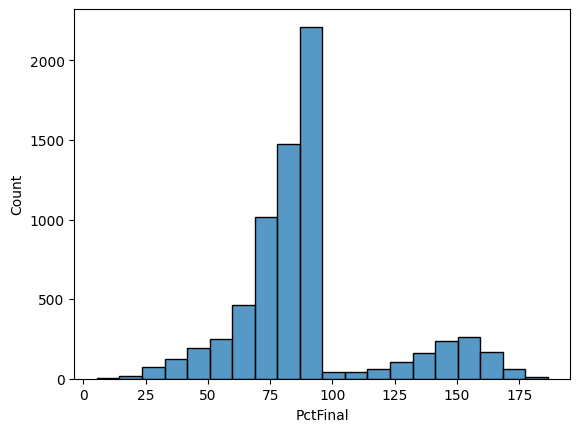

In [ ]:
# create a histogram of the PctFinal column
sns.histplot(data=new_aber, x="PctFinal", bins=20)
# show the histogram
plt.show()

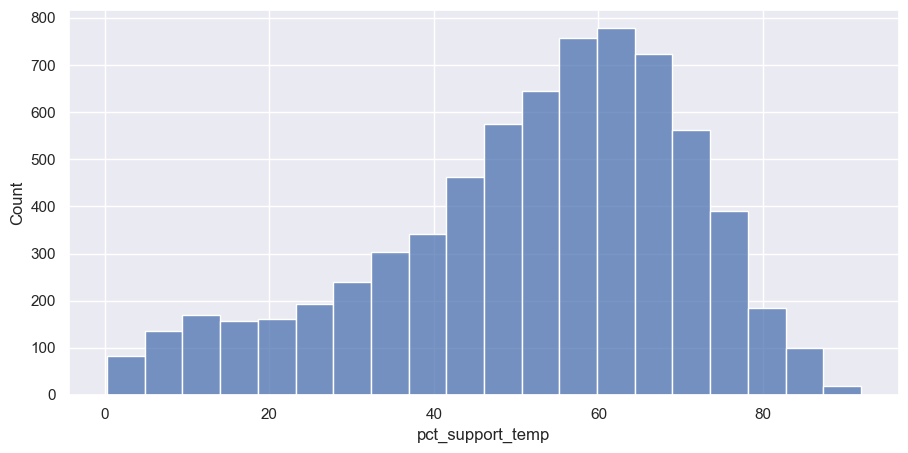

In [ ]:
# make the same graph for pct_support_temp and pctabber
sns.histplot(data=new_aber, x="pct_support_temp", bins=20)
plt.show()


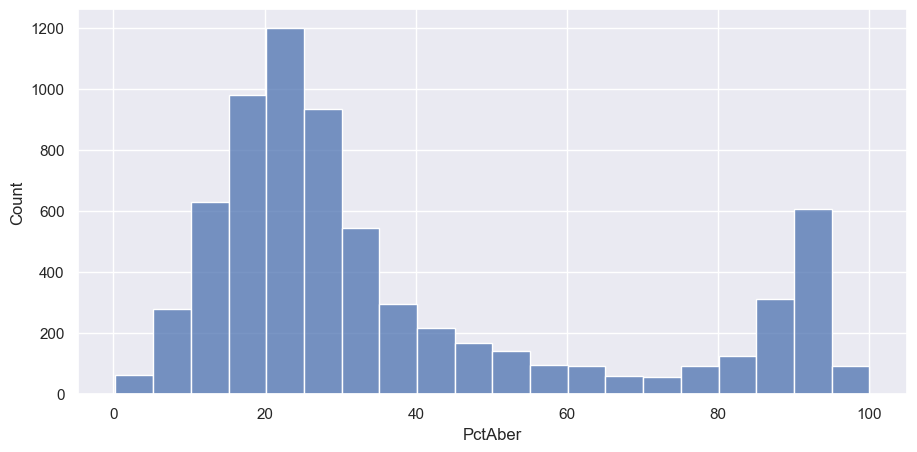

In [ ]:
# make the same graph for pctabber
sns.histplot(data=new_aber, x="PctAber", bins=20)
plt.show()


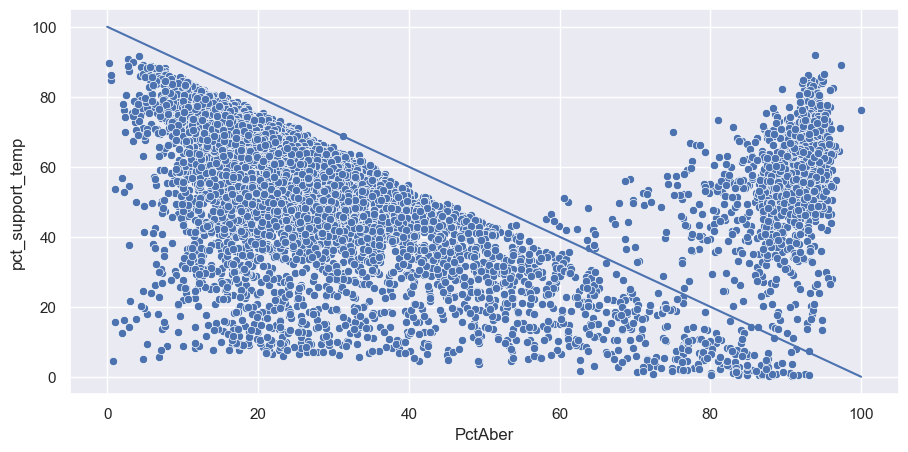

In [ ]:
# make a dot plot with pctabber on the x axis and pct_support_temp on the y axis
sns.scatterplot(data=new_aber, x="PctAber", y="pct_support_temp")
plt.plot([0, 100], [100, 0])
plt.plot([0, 0],[100, 100])
plt.show()

In [ ]:
# filter the ones where PassedAberrantFilter is less than ReadsWithPrimer
new_aber[new_aber["PassedAberrantFilter"] < new_aber["ReadsWithPrimer"]]
#new_aber["pct_support"] = (new_aber["asv_support"])/((new_aber["ReadsWithPrimer"] + abber["Aberrant_LC_reads"]))


,seq,chain,entry__mabid,entry__clonality,entry__category,pk,asv_support,total_reads,domain,plate,SMARTindex,parent,project,Chain,RawReads,ReadsWithPrimer,Ga12HC,Ga3HC,LaLC,KaLC,ReadsToFilter,PassedAberrantFilter,Aberrant_LC_reads,ReadsToOverlap,ShortInsert,MediumInserts,LongInserts,Overlapped,LengthFiltered,PctAber,TOTAL_READS,pct_support,pct_support_temp,PctFinal
79,AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...,Light,L36/12.9,Monoclonal,1.0,177,21.0,23,"D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...",TRIMMER0002_P2,86-SMARTindex,L36/12,L36,L,571113.0,135.0,0.0,0.0,6.0,129.0,134.0,134.0,43.0,134.0,77.0,35.0,22.0,112.0,33.0,31.851852,178.0,15.555556,15.555556,47.407407
88,GAAATACATCAGACCAGCATGGGCTTCAAGATGGAGTCTCATACTC...,Light,N397/19.1.1,Monoclonal,1.0,285,5596.0,5884,"D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,L,S,I,I,C,...",TRIMMER0003_P3,03-SMARTindex,N397/19,N397,L,1684305.0,7978.0,0.0,0.0,2.0,7976.0,7972.0,7972.0,1690.0,7972.0,7.0,7616.0,349.0,7623.0,7481.0,21.183254,9668.0,70.142893,70.142893,91.326147
89,AGCATCAGACAGGCTGGGCAGCAAGATGGAATCACAGACCCAGGTC...,Light,N447/24.8,Monoclonal,1.0,286,3298.0,3434,"D,I,V,M,T,Q,S,P,S,S,L,A,M,S,V,G,Q,K,V,T,M,S,C,...",TRIMMER0003_P3,04-SMARTindex,N447/24,N447,L,1684305.0,5355.0,0.0,0.0,9.0,5346.0,5353.0,5353.0,1741.0,5353.0,9.0,5109.0,235.0,5118.0,5033.0,32.511671,7096.0,61.587302,61.587302,94.098973
90,AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...,Light,N245/36.1,Monoclonal,1.0,287,7795.0,10377,"D,I,V,L,T,Q,S,P,A,S,L,A,V,S,Q,G,Q,R,A,T,I,S,C,...",TRIMMER0003_P3,05-SMARTindex,N245/36,N245,L,1684305.0,13075.0,0.0,0.0,8.0,13067.0,13066.0,13066.0,2647.0,13066.0,17.0,12254.0,795.0,12271.0,11852.0,20.244742,15722.0,59.617591,59.617591,79.862333
91,AGGACAATGGCAGAAAGTCACTCTCAGTGAGGATACACCATCAGCA...,Light,N425/45.4,Monoclonal,1.0,288,3299.0,3400,"D,I,Q,M,N,Q,S,P,S,S,L,S,A,S,L,G,D,T,I,T,I,T,C,...",TRIMMER0003_P3,06-SMARTindex,N425/45,N425,L,1684305.0,6024.0,0.0,0.0,1.0,6023.0,6020.0,6020.0,2400.0,6020.0,14.0,5682.0,324.0,5696.0,5613.0,39.840637,8424.0,54.764276,54.764276,94.604914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6898,ACTTTTGACTCACCATATCAAGTTCGCAGAATGAGGTTCTCTGCTC...,Light,N158/15.4,Monoclonal,2.0,24819,3570.0,3688,"D,I,V,M,T,Q,A,A,F,S,N,P,V,T,L,G,T,S,A,S,I,S,C,...",TRIMMER00112_P100,01-SMARTindex,N158/15,N158,L,2216900.0,8950.0,0.0,0.0,197.0,8753.0,8949.0,8949.0,7599.0,8949.0,1353.0,5193.0,2403.0,6546.0,4964.0,84.905028,17254.0,39.888268,39.888268,124.793296
6904,ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...,Light,N194/17.4,Monoclonal,2.0,24827,5923.0,6159,"D,V,V,M,T,Q,S,P,L,T,L,S,V,T,I,G,Q,T,A,S,-,I,S,...",TRIMMER00112_P100,07-SMARTindex,N194/17,N194,L,2216900.0,13427.0,0.0,0.0,29.0,13398.0,13426.0,13426.0,3427.0,13426.0,1443.0,8457.0,3526.0,9900.0,8360.0,25.523200,17459.0,44.112609,44.112609,69.635808
6929,GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...,Light,N293/73.5,Monoclonal,2.0,24855,4703.0,4771,"Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...",TRIMMER00112_P100,35-SMARTindex,N293/73,N293,L,2216900.0,10934.0,0.0,0.0,9295.0,1639.0,10933.0,10933.0,1451.0,10933.0,490.0,5811.0,4632.0,6301.0,5740.0,13.270532,13075.0,43.012621,43.012621,56.283153
6942,AATTAGCTAGGGACCAAAATTCAAAGACAGAATGGATTTTCAGGTG...,Light,N299/45.3,Monoclonal,2.0,24868,3345.0,3586,"Q,T,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,I,S,C,...",TRIMMER00112_P100,51-SMARTindex,N299/45,N299,L,2216900.0,7565.0,0.0,0.0,64.0,7501.0,7564.0,7564.0,2448.0,7564.0,551.0,5266.0,1747.0,5817.0,5133.0,32.359551,10267.0,44.216788,44.216788,76.576338


In [ ]:
# filter based on PctFinal > 100 and count the occurences from each plate and show the top 10
# increase the number of rows shown
pd.set_option('display.max_rows', 500)
new_aber[(new_aber["PctFinal"] > 100) & (new_aber["plate"] == "TRIMMER0046_P39")]
#print(len(new_aber[new_aber["PctFinal"] > 100].groupby("plate").count().sort_values("PctFinal", ascending=False)))

,seq,chain,entry__mabid,entry__clonality,entry__category,pk,asv_support,total_reads,domain,plate,SMARTindex,parent,project,Chain,RawReads,ReadsWithPrimer,Ga12HC,Ga3HC,LaLC,KaLC,ReadsToFilter,PassedAberrantFilter,Aberrant_LC_reads,ReadsToOverlap,ShortInsert,MediumInserts,LongInserts,Overlapped,LengthFiltered,PctAber,TOTAL_READS,pct_support,pct_support_temp,PctFinal
2966,AATCCACAGAAGCTCAGGGAAAATTTGAAGATGGTGTCCACTTCTC...,Light,K93X/1.6,Monoclonal,2.0,7426,1409.0,2118,"D,I,V,M,T,Q,S,P,A,T,L,S,V,T,P,G,D,R,V,S,L,S,C,...",TRIMMER0046_P39,02-SMARTindex,K93X/1,K93X,L,966125.0,3930.0,0.0,0.0,3.0,3927.0,3930.0,3930.0,3657.0,3930.0,6.0,3679.0,245.0,3685.0,3617.0,93.053435,7587.0,35.852417,35.852417,128.905852
2967,CTGCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGG...,Light,K93X/1.6,Monoclonal,2.0,7427,292.0,2118,"N,I,M,M,T,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...",TRIMMER0046_P39,02-SMARTindex,K93X/1,K93X,L,966125.0,3930.0,0.0,0.0,3.0,3927.0,3930.0,3930.0,3657.0,3930.0,6.0,3679.0,245.0,3685.0,3617.0,93.053435,7587.0,7.430025,7.430025,100.483461
2969,AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...,Light,K50/27.1,Monoclonal,2.0,7430,2795.0,2933,"D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...",TRIMMER0046_P39,04-SMARTindex,K50/27,K50,L,966125.0,4718.0,0.0,0.0,4.0,4714.0,4718.0,4718.0,4453.0,4718.0,8.0,4460.0,250.0,4468.0,4416.0,94.383213,9171.0,59.241204,59.241204,153.624417
2977,AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...,Light,K50/36.1,Monoclonal,2.0,7444,2344.0,2418,"D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...",TRIMMER0046_P39,12-SMARTindex,K50/36,K50,L,966125.0,3762.0,0.0,0.0,2.0,3760.0,3762.0,3762.0,3532.0,3762.0,4.0,3577.0,181.0,3581.0,3534.0,93.886231,7294.0,62.307283,62.307283,156.193514
2980,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...,Light,K92/24.1,Monoclonal,2.0,7447,5322.0,5646,"D,V,L,M,T,Q,T,P,L,S,L,S,V,S,L,G,D,Q,A,S,I,S,C,...",TRIMMER0046_P39,15-SMARTindex,K92/24,K92,L,966125.0,7814.0,0.0,0.0,3.0,7811.0,7814.0,7814.0,7260.0,7814.0,8.0,7359.0,447.0,7367.0,7306.0,92.910161,15074.0,68.108523,68.108523,161.018684
2983,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...,Light,K93X/22.6,Monoclonal,2.0,7451,2991.0,3203,"D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...",TRIMMER0046_P39,18-SMARTindex,K93X/22,K93X,L,966125.0,5206.0,0.0,0.0,0.0,5206.0,5206.0,5206.0,4898.0,5206.0,4.0,4903.0,299.0,4907.0,4848.0,94.083750,10104.0,57.452939,57.452939,151.536688
2987,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...,Light,K92/33.1,Monoclonal,2.0,7455,3716.0,4345,"D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,V,S,I,S,C,...",TRIMMER0046_P39,23-SMARTindex,K92/33,K92,L,966125.0,6510.0,0.0,0.0,8.0,6502.0,6510.0,6510.0,6121.0,6510.0,8.0,6176.0,326.0,6184.0,6127.0,94.024578,12631.0,57.081413,57.081413,151.105991
2988,ATCCTCTCTTCTAGCTCTCAGAGATGGAGACAGACACACTCCTGCT...,Light,K82/38.1,Monoclonal,2.0,7456,3173.0,4760,"D,I,V,L,T,Q,S,P,A,S,L,V,V,S,L,G,Q,R,A,T,I,S,C,...",TRIMMER0046_P39,24-SMARTindex,K82/38,K82,L,966125.0,6996.0,0.0,0.0,11.0,6985.0,6996.0,6996.0,6477.0,6996.0,22.0,6552.0,422.0,6574.0,6428.0,92.581475,13473.0,45.354488,45.354488,137.935963
2992,AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...,Light,K52/1.1,Monoclonal,2.0,7461,1457.0,1669,"D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...",TRIMMER0046_P39,29-SMARTindex,K52/1,K52,L,966125.0,3669.0,0.0,0.0,10.0,3659.0,3669.0,3669.0,3160.0,3669.0,12.0,3450.0,207.0,3462.0,3216.0,86.127010,6829.0,39.711093,39.711093,125.838103
3002,ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...,Light,K77/236.1,Monoclonal,2.0,7472,2481.0,2627,"D,I,V,M,T,Q,A,A,P,S,V,P,V,T,P,G,E,S,V,S,-,I,S,...",TRIMMER0046_P39,40-SMARTindex,K77/236,K77,L,966125.0,5173.0,0.0,0.0,8.0,5165.0,5173.0,5173.0,4767.0,5173.0,14.0,4829.0,330.0,4843.0,4737.0,92.151556,10737.0,47.960564,47.960564,140.112121


In [ ]:
# summarize the plates from the above filter
new_aber[new_aber["PctFinal"] > 100].groupby("entry__category").count()

,seq,chain,entry__mabid,entry__clonality,pk,asv_support,total_reads,domain,plate,SMARTindex,parent,project,Chain,RawReads,ReadsWithPrimer,Ga12HC,Ga3HC,LaLC,KaLC,ReadsToFilter,PassedAberrantFilter,Aberrant_LC_reads,ReadsToOverlap,ShortInsert,MediumInserts,LongInserts,Overlapped,LengthFiltered,PctAber,TOTAL_READS,pct_support,pct_support_temp,PctFinal
entry__category,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1.0,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,124,125,125,125
2.0,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,771,778,778,778
3.0,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,237,238,238,238


In [ ]:
df_lh_bu = new_aber #TODO these are pretty much the same thing just for some reason use one the the other

In [ ]:
# Before change (chemical)
# N1-N377
# All D, all K, L1-L93
# After change (electro)
# N378-present
# L94-present

def fusion_type(df_lh_bu, mabid_column="entry__mabid"):
    # split on the "/" and strip remove all non numeric characters from the entry__mabid column
    df_lh_bu["entry__mabid__project_num"] = df_lh_bu[mabid_column].str.split("/").str[0].str.replace("[^0-9]", "")
    # split on the "/" and strip remove all non alphabet characters from the entry__mabid column first portion
    df_lh_bu["entry__mabid__project_alpha"] = df_lh_bu[mabid_column].str.split("/").str[0].str.replace("[^a-zA-Z]", "")
    # fill the na and "" from the project number column with 0 and same with empty strings
    df_lh_bu["entry__mabid__project_num"] = df_lh_bu["entry__mabid__project_num"].fillna(0).replace("",0)
    # create a new column called fusion_type and where the project number is less then 378 and project alpha is N, set it to chemical
    df_lh_bu["fusion_type"] = np.where((df_lh_bu["entry__mabid__project_num"].astype(int) < 378) & (df_lh_bu["entry__mabid__project_alpha"] == "N"), "chemical", "electro")
    # set fusion type to chemical if the project alpha is D or K
    df_lh_bu["fusion_type"] = np.where((df_lh_bu["entry__mabid__project_alpha"] == "D") | (df_lh_bu["entry__mabid__project_alpha"] == "K"), "chemical", df_lh_bu["fusion_type"])
    # set the fustion type to chemical if the project number is less then 93 and the project alpha is L
    df_lh_bu["fusion_type"] = np.where((df_lh_bu["entry__mabid__project_num"].astype(int) < 93) & (df_lh_bu["entry__mabid__project_alpha"] == "L"), "chemical", df_lh_bu["fusion_type"])

    return df_lh_bu

<ipython-input-236-43f89194cf5d>:11: FutureWarning:

The default value of regex will change from True to False in a future version.

<ipython-input-236-43f89194cf5d>:13: FutureWarning:

The default value of regex will change from True to False in a future version.



In [ ]:
df_lh_bu = fusion_type(df_lh_bu, mabid_column="entry__mabid")

,seq,chain,entry__mabid,entry__clonality,entry__category,pk,asv_support,total_reads,domain,plate,SMARTindex,parent,project,Chain,RawReads,ReadsWithPrimer,Ga12HC,Ga3HC,LaLC,KaLC,ReadsToFilter,PassedAberrantFilter,Aberrant_LC_reads,ReadsToOverlap,ShortInsert,MediumInserts,LongInserts,Overlapped,LengthFiltered,PctAber,TOTAL_READS,pct_support,pct_support_temp,PctFinal,entry__mabid__project_num,entry__mabid__project_alpha,fusion_type
0,GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...,Light,L130/1.1,Monoclonal,1.0,90,4228.0,4353,"E,I,V,L,T,Q,S,P,T,T,L,A,A,S,P,G,E,K,I,T,I,T,C,...",TRIMMER0002_P2,02-SMARTindex,L130/1,L130,L,571113.0,6043.0,0.0,0.0,16.0,6027.0,6043.0,6043.0,1182.0,6043.0,362.0,5452.0,229.0,5814.0,5401.0,19.559821,NaN,69.965249,69.965249,89.525070,130,L,electro
1,AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...,Light,L80/21.1,Monoclonal,1.0,91,3518.0,3631,"Q,I,V,L,T,Q,S,P,A,I,M,S,A,F,P,G,E,R,V,T,M,T,C,...",TRIMMER0002_P2,03-SMARTindex,L80/21,L80,L,571113.0,5064.0,0.0,0.0,12.0,5052.0,5064.0,5064.0,876.0,5064.0,321.0,4491.0,252.0,4812.0,4416.0,17.298578,5940.0,69.470774,69.470774,86.769352,80,L,chemical
2,GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...,Light,L106/83.1,Monoclonal,1.0,93,3153.0,3166,"Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...",TRIMMER0002_P2,04-SMARTindex,L106/83,L106,L,571113.0,4334.0,0.0,0.0,3562.0,772.0,4334.0,4334.0,637.0,4334.0,304.0,3787.0,243.0,4091.0,3763.0,14.697739,4971.0,72.750346,72.750346,87.448085,106,L,electro
3,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...,Light,N486/76.1,Monoclonal,1.0,94,1804.0,1855,"D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...",TRIMMER0002_P2,05-SMARTindex,N486/76,N486,L,571113.0,2462.0,0.0,0.0,17.0,2445.0,2462.0,2462.0,2219.0,2462.0,195.0,2137.0,130.0,2332.0,2115.0,90.129976,4681.0,73.273761,73.273761,163.403737,486,N,electro
4,AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...,Light,N123/48.1,Monoclonal,1.0,95,25.0,42,"Q,L,M,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...",TRIMMER0002_P2,06-SMARTindex,N123/48,N123,L,571113.0,1197.0,0.0,0.0,59.0,1138.0,1197.0,1197.0,973.0,1197.0,217.0,922.0,58.0,1139.0,892.0,81.286550,2170.0,2.088555,2.088555,83.375104,123,N,chemical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6977,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...,Light,N238/24.5,Monoclonal,2.0,24906,2767.0,2974,"D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...",TRIMMER00112_P100,92-SMARTindex,N238/24,N238,L,2216900.0,8008.0,0.0,0.0,75.0,7933.0,8008.0,8008.0,3183.0,8008.0,657.0,5082.0,2269.0,5739.0,4999.0,39.747752,11191.0,34.552947,34.552947,74.300699,238,N,chemical
6978,GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...,Light,N268/33.5,Monoclonal,2.0,24907,3833.0,4127,"E,I,V,L,T,Q,S,P,V,T,M,A,A,S,P,G,E,K,I,T,I,T,C,...",TRIMMER00112_P100,93-SMARTindex,N268/33,N268,L,2216900.0,9317.0,0.0,0.0,47.0,9270.0,9317.0,9317.0,2653.0,9317.0,1275.0,6088.0,1954.0,7363.0,5852.0,28.474831,11970.0,41.139852,41.139852,69.614683,268,N,chemical
6979,AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...,Light,N237/24.3,Monoclonal,2.0,24908,860.0,899,"D,I,V,M,S,Q,S,P,P,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...",TRIMMER00112_P100,94-SMARTindex,N237/24,N237,L,2216900.0,1662.0,0.0,0.0,31.0,1631.0,1662.0,1662.0,227.0,1662.0,159.0,1049.0,454.0,1208.0,1033.0,13.658243,1889.0,51.744886,51.744886,65.403129,237,N,chemical
6980,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...,Light,L87/37.5,Monoclonal,2.0,24909,5857.0,6491,"D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...",TRIMMER00112_P100,95-SMARTindex,L87/37,L87,L,2216900.0,13244.0,0.0,0.0,31.0,13213.0,13244.0,13244.0,2721.0,13244.0,1358.0,8228.0,3658.0,9586.0,8090.0,20.545153,15965.0,44.223799,44.223799,64.768952,87,L,chemical


## Make some graphs for the paper

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


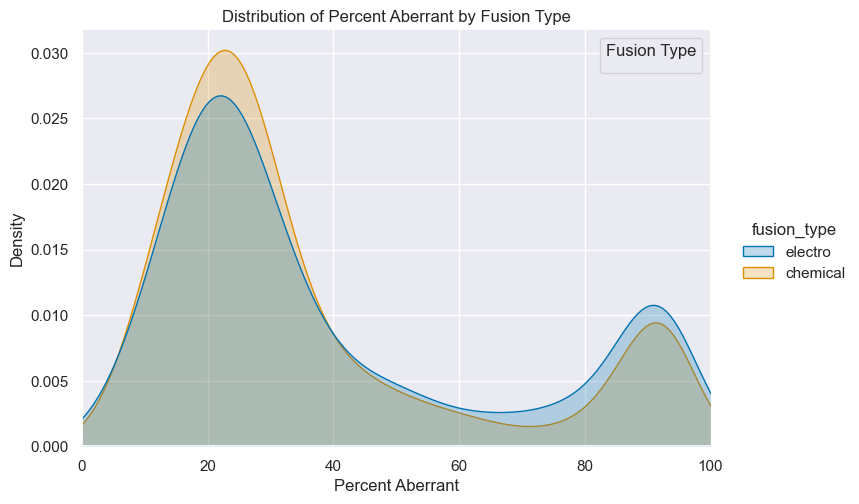

In [ ]:
# graph the distribution of the percent abberant column split by fusion type
sns.displot(df_lh_bu, x="PctAber", hue="fusion_type", kind="kde", fill=True, palette="colorblind", common_norm=False, aspect=1.5, height=5)
plt.xlim(0, 100)
# change the hue legend title
plt.legend(title="Fusion Type")
plt.xlabel("Percent Aberrant")
plt.ylabel("Density")
plt.title("Distribution of Percent Aberrant by Fusion Type")
plt.show()

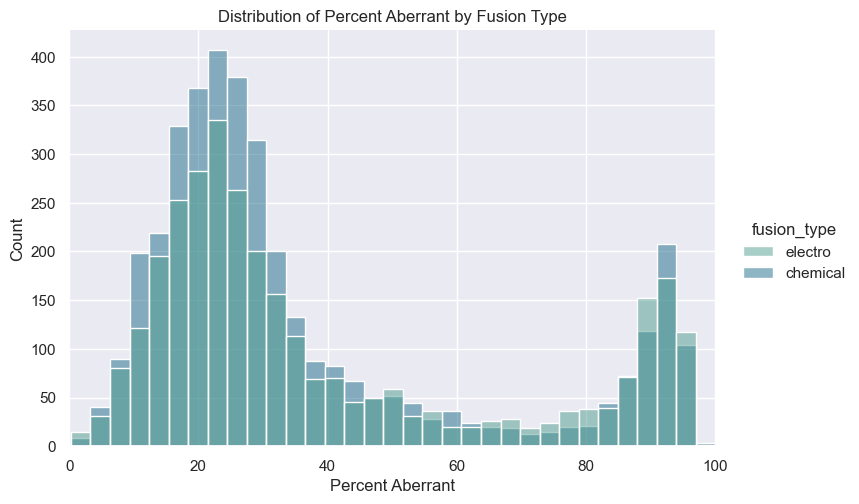

In [ ]:
# graph the histogram of the percent abberant column split by fusion type
sns.displot(df_lh_bu, x="PctAber", hue="fusion_type", kind="hist", fill=True, palette="crest", common_norm=False, aspect=1.5, height=5)
plt.xlim(0, 100)
plt.xlabel("Percent Aberrant")
plt.ylabel("Count")
plt.title("Distribution of Percent Aberrant by Fusion Type")
plt.show()

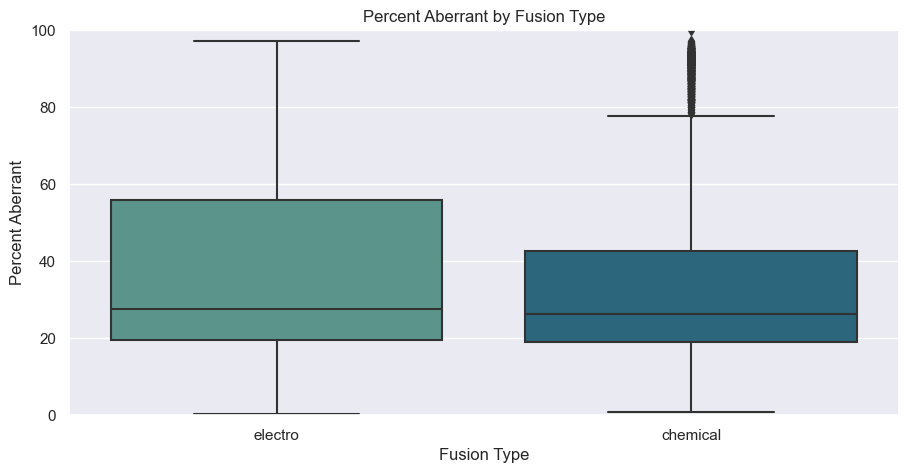

In [ ]:
# plot a box and whisker plot for each fusion type and map the statistical significance as * for p < 0.05 and ** for p < 0.01
sns.boxplot(data=df_lh_bu, x="fusion_type", y="PctAber", palette="crest")
plt.ylim(0, 100)
plt.xlabel("Fusion Type")
plt.ylabel("Percent Aberrant")
plt.title("Percent Aberrant by Fusion Type")
plt.show()


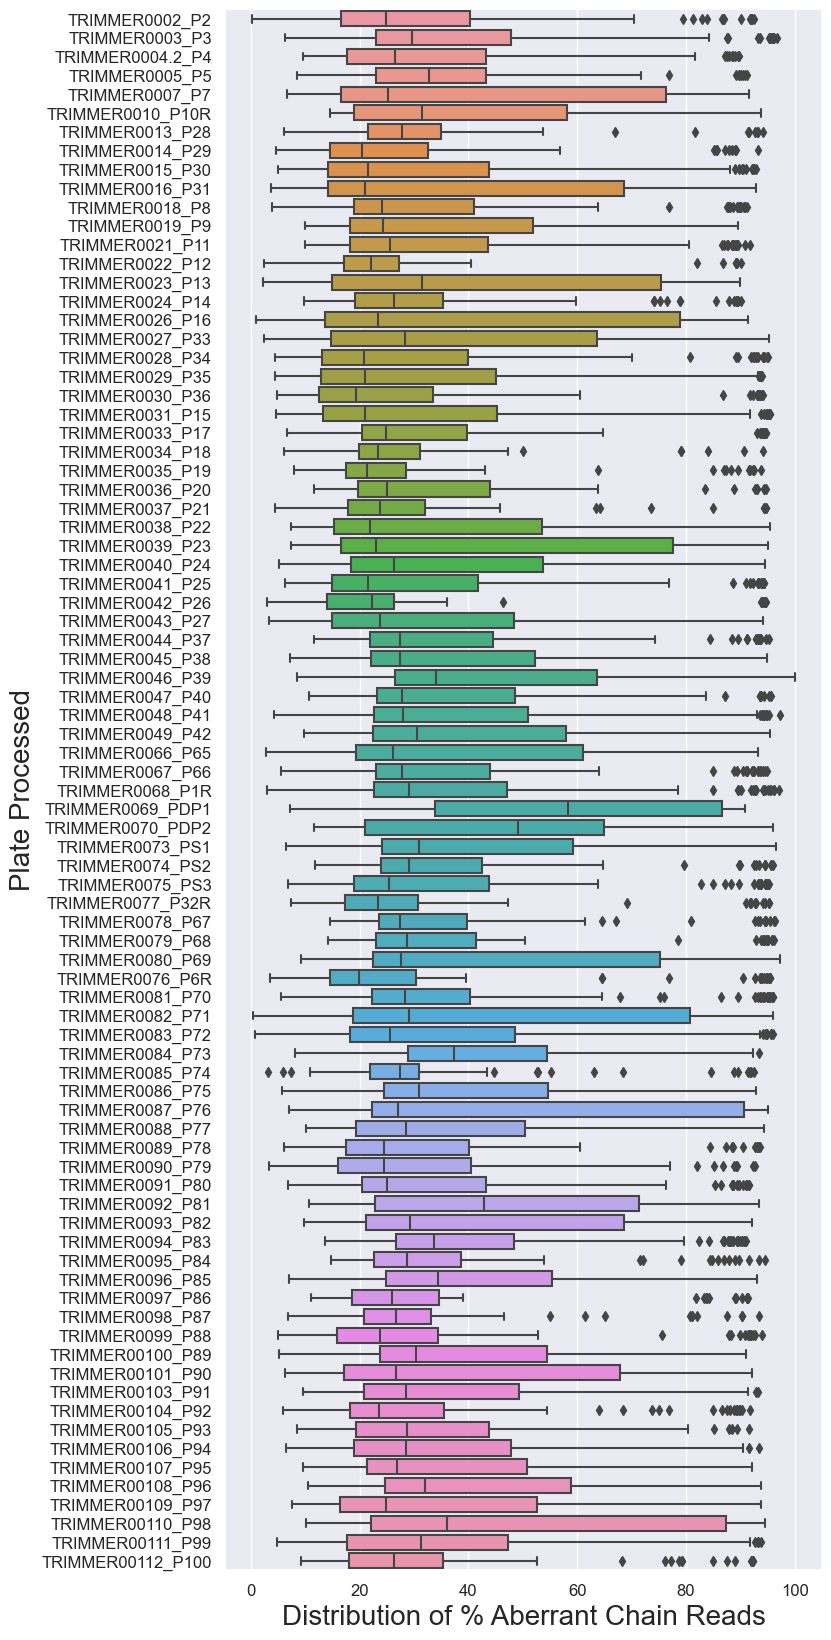

In [ ]:


new_aber = df_lh_bu
sns.set(rc={'figure.figsize':(7.7,20.27)})
ax = sns.boxplot(data=new_aber, x="PctAber", y="plate",)
ax.set_xlabel("Distribution of % Aberrant Chain Reads",fontsize=20)
ax.set_ylabel("Plate Processed",fontsize=20)
ax.tick_params(labelsize=12)
plt.show()


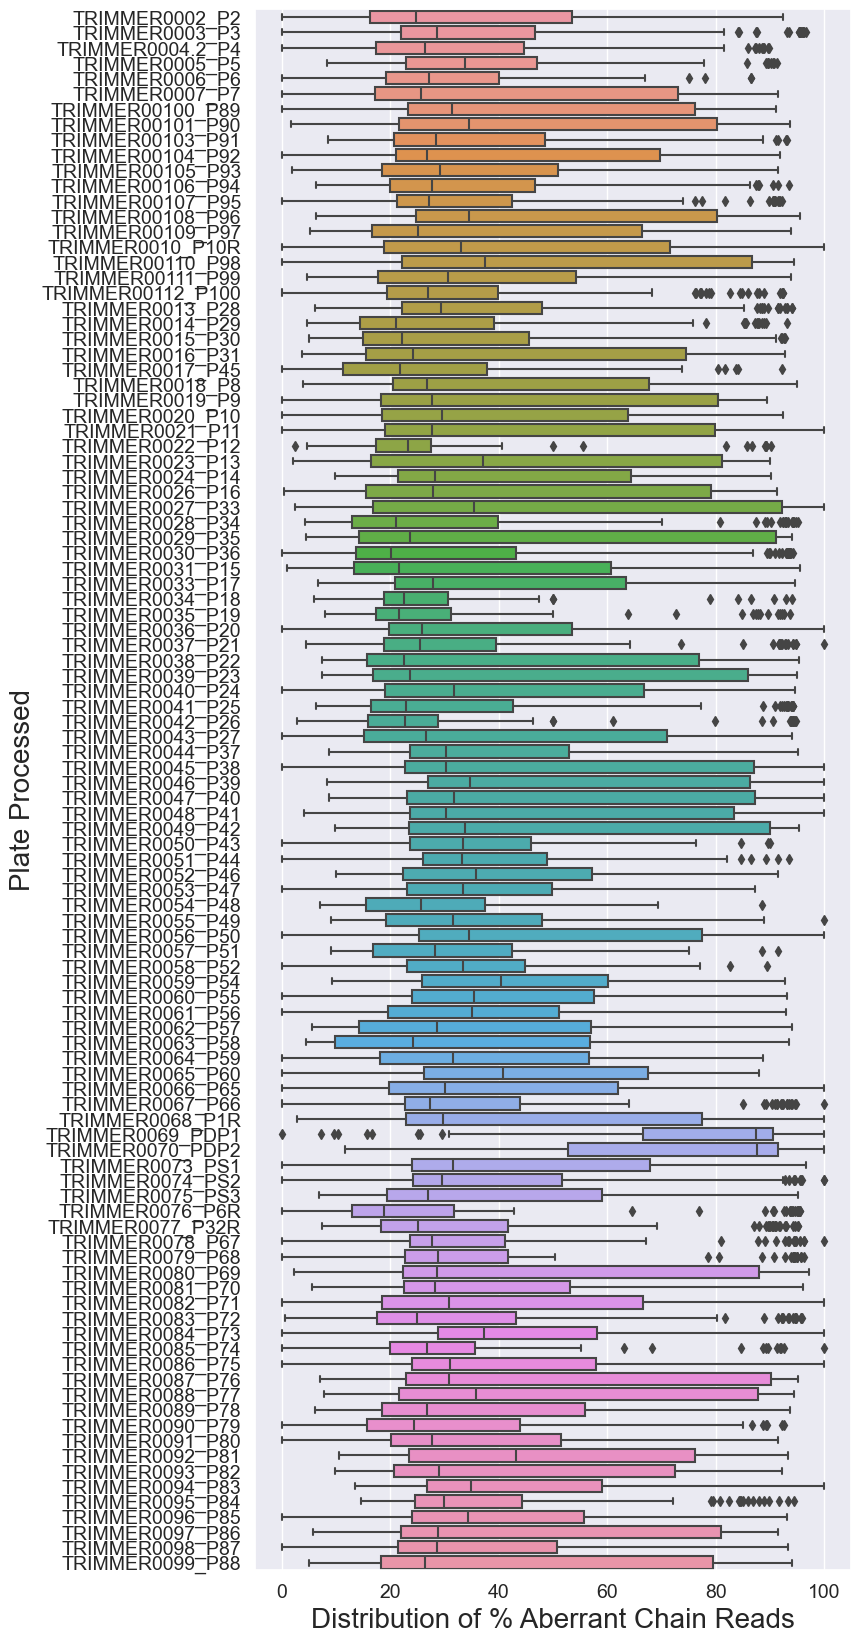

In [ ]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(7.7,20.27)})
ax = sns.boxplot(data=abber[abber["Chain"]=="L"], x="PctAber", y="plate",)
ax.set_xlabel("Distribution of % Aberrant Chain Reads",fontsize=20)
ax.set_ylabel("Plate Processed",fontsize=20)
ax.tick_params(labelsize=14)
plt.show()


In [ ]:
# this is the same as the bradbur table except for this is only LC counts
aber_parent = new_aber.groupby(["parent","fusion_type"]).agg({"PctAber": ["count", "mean"]}).reset_index()#.droplevel(0, axis=1)
aber_parent.columns = aber_parent.columns.droplevel(0)
aber_parent.columns = ["project", "fusion_type", "count", "mean"]
aber_parent

,project,fusion_type,count,mean
0,1D8,chemical,3,28.987620
1,1F1,electro,4,46.806008
2,62-3G1,electro,3,0.415712
3,8G10,electro,1,35.398230
4,A12/18,electro,3,38.035359
...,...,...,...,...
2150,N9C/24,electro,2,19.404690
2151,UNC65,electro,2,87.927517
2152,n152b/11,electro,1,16.633019
2153,n194/17,electro,1,17.505928


In [ ]:
# compare the aber-parent project column unique values to the bradbury entry__pk column unique values using sets
#print(len(set(aber_parent["project"].unique()) - set(bradbur["entry__pk"].unique())))
#print(set(aber_parent["project"].unique()) - set(bradbur["entry__pk"].unique()))

228
{'N414/50', 'N139/27', 'N460/96', 'N45B/46', 'N231B/30', 'N265/18', 'N383/18', 'N55/53', 'N230/17', 'N198/20', 'N429/47', 'L69/45', 'L125/118', 'N463/10', 'N187/7', 'N481/97', 'N231/48', 'N194/13', 'L116/86', 'N402/61', 'N106/48', 'K97/20', 'N435/93', 'N132/15', 'L106/73', 'N165/58', 'N23/31', 'N292/15', 'L107/56', 'N361A/88', 'N481/49', 'N267/5', 'N491/22', 'N291/30', 'N142/17', 'N351/42', 'EMPTY', 'N363/95', 'N285/20', 'N423/23', 'L129/55', 'N267/52', 'K92/33', 'N383/77', 'N300/6', 'L49/20', 'L14/12', 'N382/22', 'N39B/22', 'N383A/24', 'K68/66', 'N387/20', 'N400/28', 'N485/20', 'D4/194', 'N335/19', 'K78/11', 'N450/84', 'N491/13', 'N183/24', 'L126/49', 'L118/65', 'N152B/11', 'N177A/15', 'D4/133', 'N271/28', 'N481/113', 'N458/42', 'L52/29', 'N157/20', 'N451/33', 'N101/23', 'N121/32', 'N270/45', 'N108/27', 'N276/30', 'N430/20', 'N485/87', 'N138A/5', 'N26/10', 'N56/43', 'N277/17', 'N154/37', 'N230/14', '1D8', 'N267/32', 'N466/85', 'N373/71', 'K56/27', 'N428/50', 'L124/81', 'L95A/44', 

In [ ]:
#print(len(set(aber_parent["project"].unique()) - set(bradbur["entry__pk"].unique())))
#print(set(bradbur["entry__pk"].unique()) - set(aber_parent["project"].unique()))

228
{'N147A/34', 'N361/60', 'N97A/30', 'N486/40'}


In [ ]:
df_lh_bu

,seq,chain,entry__mabid,entry__clonality,entry__category,pk,asv_support,total_reads,domain,plate,SMARTindex,parent,project,Chain,RawReads,ReadsWithPrimer,Ga12HC,Ga3HC,LaLC,KaLC,ReadsToFilter,PassedAberrantFilter,Aberrant_LC_reads,ReadsToOverlap,ShortInsert,MediumInserts,LongInserts,Overlapped,LengthFiltered,PctAber,TOTAL_READS,pct_support,pct_support_temp,PctFinal,entry__mabid__project_num,entry__mabid__project_alpha,fusion_type
0,GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...,Light,L130/1.1,Monoclonal,1.0,90,4228.0,4353,"E,I,V,L,T,Q,S,P,T,T,L,A,A,S,P,G,E,K,I,T,I,T,C,...",TRIMMER0002_P2,02-SMARTindex,L130/1,L130,L,571113.0,6043.0,0.0,0.0,16.0,6027.0,6043.0,6043.0,1182.0,6043.0,362.0,5452.0,229.0,5814.0,5401.0,19.559821,NaN,69.965249,69.965249,89.525070,130,L,electro
1,AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...,Light,L80/21.1,Monoclonal,1.0,91,3518.0,3631,"Q,I,V,L,T,Q,S,P,A,I,M,S,A,F,P,G,E,R,V,T,M,T,C,...",TRIMMER0002_P2,03-SMARTindex,L80/21,L80,L,571113.0,5064.0,0.0,0.0,12.0,5052.0,5064.0,5064.0,876.0,5064.0,321.0,4491.0,252.0,4812.0,4416.0,17.298578,5940.0,69.470774,69.470774,86.769352,80,L,chemical
2,GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...,Light,L106/83.1,Monoclonal,1.0,93,3153.0,3166,"Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...",TRIMMER0002_P2,04-SMARTindex,L106/83,L106,L,571113.0,4334.0,0.0,0.0,3562.0,772.0,4334.0,4334.0,637.0,4334.0,304.0,3787.0,243.0,4091.0,3763.0,14.697739,4971.0,72.750346,72.750346,87.448085,106,L,electro
3,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...,Light,N486/76.1,Monoclonal,1.0,94,1804.0,1855,"D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...",TRIMMER0002_P2,05-SMARTindex,N486/76,N486,L,571113.0,2462.0,0.0,0.0,17.0,2445.0,2462.0,2462.0,2219.0,2462.0,195.0,2137.0,130.0,2332.0,2115.0,90.129976,4681.0,73.273761,73.273761,163.403737,486,N,electro
4,AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...,Light,N123/48.1,Monoclonal,1.0,95,25.0,42,"Q,L,M,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...",TRIMMER0002_P2,06-SMARTindex,N123/48,N123,L,571113.0,1197.0,0.0,0.0,59.0,1138.0,1197.0,1197.0,973.0,1197.0,217.0,922.0,58.0,1139.0,892.0,81.286550,2170.0,2.088555,2.088555,83.375104,123,N,chemical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6977,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...,Light,N238/24.5,Monoclonal,2.0,24906,2767.0,2974,"D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...",TRIMMER00112_P100,92-SMARTindex,N238/24,N238,L,2216900.0,8008.0,0.0,0.0,75.0,7933.0,8008.0,8008.0,3183.0,8008.0,657.0,5082.0,2269.0,5739.0,4999.0,39.747752,11191.0,34.552947,34.552947,74.300699,238,N,chemical
6978,GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...,Light,N268/33.5,Monoclonal,2.0,24907,3833.0,4127,"E,I,V,L,T,Q,S,P,V,T,M,A,A,S,P,G,E,K,I,T,I,T,C,...",TRIMMER00112_P100,93-SMARTindex,N268/33,N268,L,2216900.0,9317.0,0.0,0.0,47.0,9270.0,9317.0,9317.0,2653.0,9317.0,1275.0,6088.0,1954.0,7363.0,5852.0,28.474831,11970.0,41.139852,41.139852,69.614683,268,N,chemical
6979,AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...,Light,N237/24.3,Monoclonal,2.0,24908,860.0,899,"D,I,V,M,S,Q,S,P,P,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...",TRIMMER00112_P100,94-SMARTindex,N237/24,N237,L,2216900.0,1662.0,0.0,0.0,31.0,1631.0,1662.0,1662.0,227.0,1662.0,159.0,1049.0,454.0,1208.0,1033.0,13.658243,1889.0,51.744886,51.744886,65.403129,237,N,chemical
6980,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...,Light,L87/37.5,Monoclonal,2.0,24909,5857.0,6491,"D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...",TRIMMER00112_P100,95-SMARTindex,L87/37,L87,L,2216900.0,13244.0,0.0,0.0,31.0,13213.0,13244.0,13244.0,2721.0,13244.0,1358.0,8228.0,3658.0,9586.0,8090.0,20.545153,15965.0,44.223799,44.223799,64.768952,87,L,chemical


In [ ]:
new_aber

,seq,chain,entry__mabid,entry__clonality,entry__category,pk,asv_support,total_reads,domain,plate,SMARTindex,parent,project,Chain,RawReads,ReadsWithPrimer,Ga12HC,Ga3HC,LaLC,KaLC,ReadsToFilter,PassedAberrantFilter,Aberrant_LC_reads,ReadsToOverlap,ShortInsert,MediumInserts,LongInserts,Overlapped,LengthFiltered,PctAber,TOTAL_READS,pct_support,pct_support_temp,PctFinal,entry__mabid__project_num,entry__mabid__project_alpha,fusion_type
0,GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...,Light,L130/1.1,Monoclonal,1.0,90,4228.0,4353,"E,I,V,L,T,Q,S,P,T,T,L,A,A,S,P,G,E,K,I,T,I,T,C,...",TRIMMER0002_P2,02-SMARTindex,L130/1,L130,L,571113.0,6043.0,0.0,0.0,16.0,6027.0,6043.0,6043.0,1182.0,6043.0,362.0,5452.0,229.0,5814.0,5401.0,19.559821,NaN,69.965249,69.965249,89.525070,130,L,electro
1,AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...,Light,L80/21.1,Monoclonal,1.0,91,3518.0,3631,"Q,I,V,L,T,Q,S,P,A,I,M,S,A,F,P,G,E,R,V,T,M,T,C,...",TRIMMER0002_P2,03-SMARTindex,L80/21,L80,L,571113.0,5064.0,0.0,0.0,12.0,5052.0,5064.0,5064.0,876.0,5064.0,321.0,4491.0,252.0,4812.0,4416.0,17.298578,5940.0,69.470774,69.470774,86.769352,80,L,chemical
2,GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...,Light,L106/83.1,Monoclonal,1.0,93,3153.0,3166,"Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...",TRIMMER0002_P2,04-SMARTindex,L106/83,L106,L,571113.0,4334.0,0.0,0.0,3562.0,772.0,4334.0,4334.0,637.0,4334.0,304.0,3787.0,243.0,4091.0,3763.0,14.697739,4971.0,72.750346,72.750346,87.448085,106,L,electro
3,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...,Light,N486/76.1,Monoclonal,1.0,94,1804.0,1855,"D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...",TRIMMER0002_P2,05-SMARTindex,N486/76,N486,L,571113.0,2462.0,0.0,0.0,17.0,2445.0,2462.0,2462.0,2219.0,2462.0,195.0,2137.0,130.0,2332.0,2115.0,90.129976,4681.0,73.273761,73.273761,163.403737,486,N,electro
4,AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...,Light,N123/48.1,Monoclonal,1.0,95,25.0,42,"Q,L,M,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...",TRIMMER0002_P2,06-SMARTindex,N123/48,N123,L,571113.0,1197.0,0.0,0.0,59.0,1138.0,1197.0,1197.0,973.0,1197.0,217.0,922.0,58.0,1139.0,892.0,81.286550,2170.0,2.088555,2.088555,83.375104,123,N,chemical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6977,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...,Light,N238/24.5,Monoclonal,2.0,24906,2767.0,2974,"D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...",TRIMMER00112_P100,92-SMARTindex,N238/24,N238,L,2216900.0,8008.0,0.0,0.0,75.0,7933.0,8008.0,8008.0,3183.0,8008.0,657.0,5082.0,2269.0,5739.0,4999.0,39.747752,11191.0,34.552947,34.552947,74.300699,238,N,chemical
6978,GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...,Light,N268/33.5,Monoclonal,2.0,24907,3833.0,4127,"E,I,V,L,T,Q,S,P,V,T,M,A,A,S,P,G,E,K,I,T,I,T,C,...",TRIMMER00112_P100,93-SMARTindex,N268/33,N268,L,2216900.0,9317.0,0.0,0.0,47.0,9270.0,9317.0,9317.0,2653.0,9317.0,1275.0,6088.0,1954.0,7363.0,5852.0,28.474831,11970.0,41.139852,41.139852,69.614683,268,N,chemical
6979,AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...,Light,N237/24.3,Monoclonal,2.0,24908,860.0,899,"D,I,V,M,S,Q,S,P,P,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...",TRIMMER00112_P100,94-SMARTindex,N237/24,N237,L,2216900.0,1662.0,0.0,0.0,31.0,1631.0,1662.0,1662.0,227.0,1662.0,159.0,1049.0,454.0,1208.0,1033.0,13.658243,1889.0,51.744886,51.744886,65.403129,237,N,chemical
6980,ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...,Light,L87/37.5,Monoclonal,2.0,24909,5857.0,6491,"D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...",TRIMMER00112_P100,95-SMARTindex,L87/37,L87,L,2216900.0,13244.0,0.0,0.0,31.0,13213.0,13244.0,13244.0,2721.0,13244.0,1358.0,8228.0,3658.0,9586.0,8090.0,20.545153,15965.0,44.223799,44.223799,64.768952,87,L,chemical


In [ ]:
aber_project = new_aber.groupby(["project","fusion_type"]).agg({"PctAber": ["count", "mean"]}).reset_index()#.droplevel(0, axis=1)
aber_project.columns = aber_project.columns.droplevel(0)
aber_project.columns = ["project", "fusion_type", "count", "mean"]
aber_project

,project,fusion_type,count,mean
0,1D8.1,chemical,1,32.976946
1,1D8.4,chemical,1,31.867306
2,1D8.5,chemical,1,22.118609
3,1F1.1.1.15,electro,1,51.144214
4,1F1.1.1.18,electro,2,49.278846
...,...,...,...,...
692,N9C,electro,3,21.411036
693,UNC65.56.18.11,electro,2,87.927517
694,n152b,electro,1,16.633019
695,n194,electro,1,17.505928


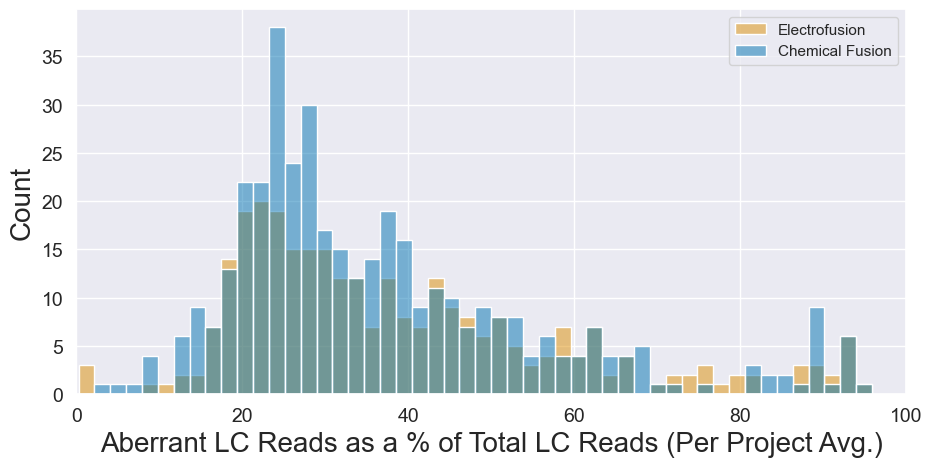

In [ ]:
# createa distribution plot of the aber_parent based on the mean
ax = sns.histplot(
    data=aber_project,
    x="mean",
    hue="fusion_type",
    bins=50,
    palette="colorblind",
)
# set the hue legend title
# set the hue legend colors
ax.legend(title=None, loc='upper right', labels=['Electrofusion', 'Chemical Fusion'])
sns.set(rc={'figure.figsize':(10.7,5)})
# add padding to the x axis
plt.xlim(0, 100)
#increase and x and y tick size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.axes.set_xlabel("Aberrant LC Reads as a % of Total LC Reads (Per Project Avg.)",fontsize=20)
ax.axes.set_ylabel("Count",fontsize=20)
# output as a png
plt.savefig("jupyter/paper_figures/4b.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# generate a text description for the figure above
print("The average % aberrant LC expression is " + str(round(aber_project["mean"].mean(), 2)) + " with a standard deviation of " + str(round(aber_project["mean"].std(), 2)) + " and a median of " + str(round(aber_project["mean"].median(), 2)) + ".")


The average % aberrant LC expression is 37.95 with a standard deviation of 19.56 and a median of 32.43.


In [ ]:
# perform a mann whitney u test between the percent abberant column split by fusion type and pretty print the results as text
mwresult = stats.mannwhitneyu(aber_project[aber_project["fusion_type"]=="chemical"]["mean"], aber_project[aber_project["fusion_type"]=="electro"]["mean"])
print("The Mann-Whitney U test between the chemical and electrofusion groups at the project level produced a p-value of " + str(round(mwresult[1], 3)) + ".")
print(mwresult)

The Mann-Whitney U test between the chemical and electrofusion groups at the project level produced a p-value of 0.149.
MannwhitneyuResult(statistic=56713.0, pvalue=0.14895349882403008)


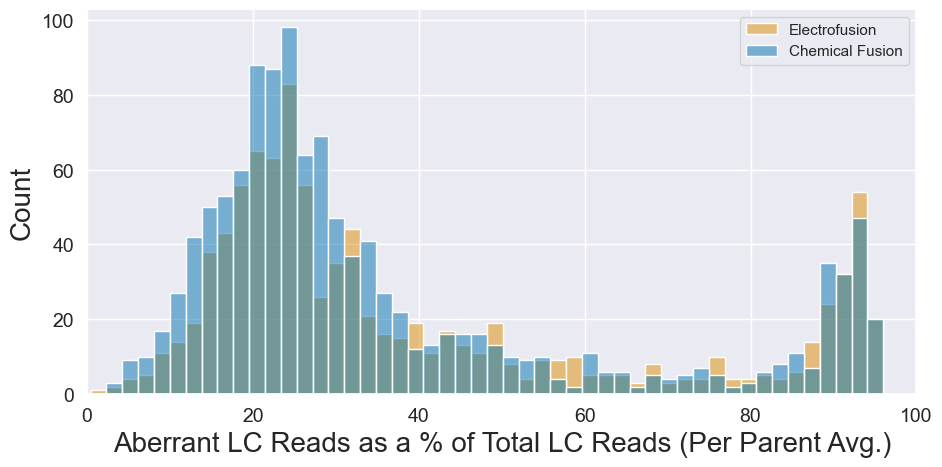

In [ ]:
ax = sns.histplot(
    data=aber_parent,
    x="mean",
    hue="fusion_type",
    bins=50,
    palette="colorblind",
)
# set the hue legend title
# set the hue legend colors
ax.legend(title=None, loc='upper right', labels=['Electrofusion', 'Chemical Fusion'])
sns.set(rc={'figure.figsize':(10.7,5)})
# add padding to the x axis
plt.xlim(0, 100)
#increase and x and y tick size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


ax.axes.set_xlabel("Aberrant LC Reads as a % of Total LC Reads (Per Parent Avg.)",fontsize=20)
ax.axes.set_ylabel("Count",fontsize=20)
# output as a png
plt.savefig("jupyter/paper_figures/4a.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# generate different colors for the figure above
# statistical test per parent as well (bradbury big difference between rat and mouse)
# all rat ones were from one lab and mouse was from many labs
# bradbury only obvious from supplementary data

# generate a text description for the summary numbers of the figure above
print("The average % aberrant LC expression is " + str(round(aber_project["mean"].mean(), 2)) + " with a standard deviation of " + str(round(aber_project["mean"].std(), 2)) + " and a median of " + str(round(aber_project["mean"].median(), 2)) + ".")


# perform a mann whitney u test between the percent abberant column split by fusion type and pretty print the results as text
mwresult = stats.mannwhitneyu(aber_parent[aber_parent["fusion_type"]=="chemical"]["mean"], aber_parent[aber_parent["fusion_type"]=="electro"]["mean"])
print("The Mann-Whitney U test between the chemical and electrofusion groups at the parent level produced a p-value of " + str(round(mwresult[1], 5)) + ".")
print(mwresult)


The average % aberrant LC expression is 37.95 with a standard deviation of 19.56 and a median of 32.43.
The Mann-Whitney U test between the chemical and electrofusion groups at the parent level produced a p-value of 0.00188.
MannwhitneyuResult(statistic=532109.0, pvalue=0.0018787268353177957)


In [ ]:
# generate the summary text for the new_aber dataframe for the mann whitney u test
print("The average % aberrant LC expression is " + str(round(new_aber["PctAber"].mean(), 2)) + " with a standard deviation of " + str(round(new_aber["PctAber"].std(), 2)) + " and a median of " + str(round(new_aber["PctAber"].median(), 2)) + ".")
# perform a mann whitney u test between the percent abberant column split by fusion type and pretty print the results as text
mwresult = stats.mannwhitneyu(new_aber[new_aber["fusion_type"]=="chemical"]["PctAber"], new_aber[new_aber["fusion_type"]=="electro"]["PctAber"])
print("The Mann-Whitney U test between the chemical and electrofusion groups at the per sequence level is " + str(round(mwresult[1], 5)) + ".")
print(mwresult)


The average % aberrant LC expression is 37.79 with a standard deviation of 27.01 and a median of 26.79.
The Mann-Whitney U test between the chemical and electrofusion groups at the per sequence level is 3e-05.
MannwhitneyuResult(statistic=5703968.5, pvalue=2.8177054806277353e-05)


In [ ]:
# generate a text description for the figure above
print("The average % aberrant LC expression is " + str(round(aber_parent["mean"].mean(), 2)) + " with a standard deviation of " + str(round(aber_parent["mean"].std(), 2)) + " and a median of " + str(round(aber_parent["mean"].median(), 2)) + ".")

The average % aberrant LC expression is 38.38 with a standard deviation of 26.12 and a median of 27.42.


# Create a new query to the database in order to create some analysis about the targets
- output the number of entries per each target
- identify the problematic targets that should be merged and fix (TODO)
- output the number of entries per each target after the merge

In [ ]:
sankey = pd.DataFrame(list(TrimmerSequence.objects.filter(entry__clonality="Monoclonal", entry__show_on_web=True, ).values('seq','chain', 'entry__mabid', 'entry__pk', 'entry__clonality', 'entry__category', 'pk', 'asv_support', 'total_reads', 'domain', 'plate', "entry__protein_target", "anarci_duplicate", "anarci_bad", "bad_support")))
df_check = pd.DataFrame(list(TrimmerSequence.objects.filter(entry__clonality="Monoclonal", entry__show_on_web=True, anarci_duplicate=False, anarci_bad=False, bad_support=False).values('seq','chain', 'entry__mabid', 'entry__pk', 'entry__clonality', 'entry__category', 'pk', 'asv_support', 'total_reads', 'domain', 'plate', "entry__protein_target")))
targs = TrimmerEntry.objects.filter(clonality="Monoclonal").values()#, anarci_duplicate=False, anarci_bad=False, bad_support=False)#.values('seq','chain', 'entry__mabid','entry__clonality', 'entry__category', 'pk', 'asv_support', 'total_reads', 'domain', 'plate')
pd.DataFrame(list(targs))

,sample_name,id,mabid,show_on_web,category,protein_target,light_count,heavy_count,clonality,max_lcstars,max_hcstars,maxavgstars
0,P2_A1,1,positivecontrol1_N263/31.1,False,NaN,nan,1,1,Monoclonal,None,None,None
1,P2_B1,2,L130/1.1,True,1.0,Tiam1,1,1,Monoclonal,4.64,4.68,4.66
2,P2_C1,3,L80/21.1,True,1.0,Kv2.1 K+ channel,1,1,Monoclonal,4.94,4.99,4.96
3,P2_D1,4,L106/83.1,True,1.0,Gephyrin,1,1,Monoclonal,3.15,3.83,3.49
4,P2_E1,5,N486/76.1,True,1.0,cFos,1,1,Monoclonal,4.95,5.00,4.98
...,...,...,...,...,...,...,...,...,...,...,...,...
7129,PRnD_N26,8631,N144/17.2,True,1.0,Gamma-protocadherin-A3,1,1,Monoclonal,4.03,2.42,3.22
7130,PRnD_N27,8632,K28/43.2,True,1.0,PSD-95,0,1,Monoclonal,0.00,3.16,None
7131,PRnD_N28,8633,K39/25.3,True,1.0,Kv2.1 K+ channel,1,1,Monoclonal,4.52,3.15,3.84
7132,PRnD_N29,8634,K58/35.4,True,2.0,Pan-Nav1 Na+ channel,1,1,Monoclonal,4.17,3.16,3.66


In [ ]:
# create a dataframe of the target counts and output to csv
pd.DataFrame(list(targs)).groupby("protein_target").count().to_csv("jupyter/target_counts.csv")
# print the number of unique targets
print(len((set([i["protein_target"].replace(" ", "") for i in targs]))))

574


In [ ]:
df_check[['parent', 'clone']] = df_check["entry__mabid"].str.split('.', 1, expand=True)


<ipython-input-530-a71aaa77c7cb>:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df_check[['parent', 'clone']] = df_check["entry__mabid"].str.split('.', 1, expand=True)


In [ ]:
crosstab = pd.crosstab(df_check["parent"], df_check["entry__protein_target"], dropna=False)

In [ ]:
import numpy
for index, row in crosstab.iterrows():
    if row.astype(bool).sum(axis=0) > 1:
        print(index, row.astype(bool).sum(axis=0))
        print(row.iloc[row.to_numpy().nonzero()])
        print("-----")


K13/31 2
entry__protein_target
Kv1.4 K+ channel       4
anti-Kv1.4N peptide    3
Name: K13/31, dtype: int64
-----
K14/39 2
entry__protein_target
Kv1.2               10
Kv1.2 K+ channel     3
Name: K14/39, dtype: int64
-----
K25/73 2
entry__protein_target
Kvbeta K+ channel        6
Pan-Kvbeta K+ channel    2
Name: K25/73, dtype: int64
-----
K55/7 2
entry__protein_target
KChIP1 K+ channel       20
Pan-KChIP K+ channel     5
Name: K55/7, dtype: int64
-----
K57/1 2
entry__protein_target
Kv4.2 K+ channel    12
Kv4.2e peptide       2
Name: K57/1, dtype: int64
-----
K68/9 2
entry__protein_target
Nav1.6 Na+ channel     10
Nav1.6 Na+ channel      2
Name: K68/9, dtype: int64
-----
K87A/10 2
entry__protein_target
Nav1.6 Na+ channel    22
Nav1.6 peptide         2
Name: K87A/10, dtype: int64
-----
K88/26 2
entry__protein_target
ZINEDIN    6
Zinedin    2
Name: K88/26, dtype: int64
-----
K88/70 2
entry__protein_target
ZINEDIN    6
Zinedin    2
Name: K88/70, dtype: int64
-----
L100/1 2
entry__protein_

# Create the ASV support graph for the paper

In [ ]:
df_lh = pd.DataFrame(list(TrimmerSequence.objects.filter(entry__clonality="Monoclonal", entry__show_on_web=True).values('seq','chain', 'entry__mabid', 'entry__pk', 'entry__clonality', 'entry__category', 'pk', 'asv_support', 'total_reads', 'domain', 'plate')))

df_lh["pct"] = df_lh["asv_support"]/df_lh["total_reads"]

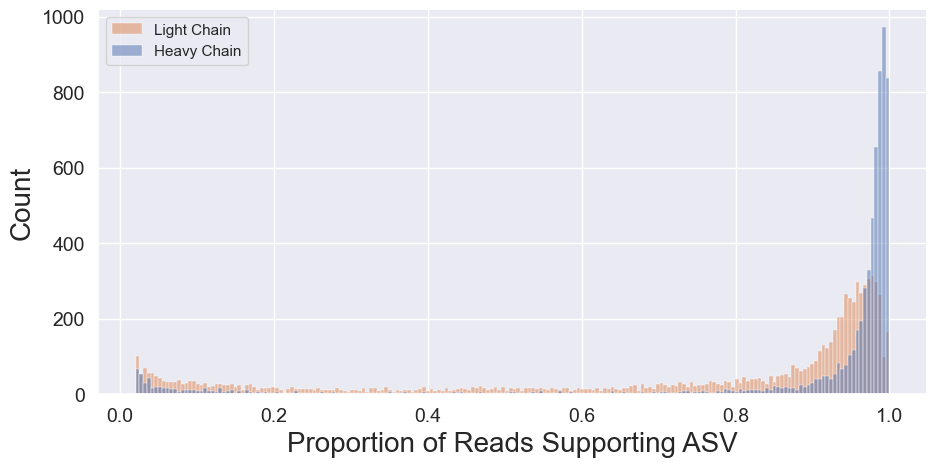

In [ ]:
ax = sns.histplot(df_lh[df_lh["pct"]<=1], x="pct", hue="chain", bins=200)
# label the axes
# ax.update_layout(
#     title="Distribution of Percent of Reads Supporting ASV",
#     xaxis_title="Proportion of Reads Supporting ASV",
#     yaxis_title="Count",
# )
# update the legend title
ax.legend(loc='upper left', labels=['Light Chain', 'Heavy Chain'])
# update x axis label
ax.axes.set_xlabel("Proportion of Reads Supporting ASV",fontsize=20)
# update y axis label
ax.axes.set_ylabel("Count",fontsize=20)
# incease x tick size
ax.tick_params(labelsize=14)
# incease y tick size
ax.tick_params(labelsize=14)
# move the legend to the upper left
#ax.legend(loc='upper left')

#fig.xlabel("Sequences Reported")

plt.savefig("jupyter/paper_figures/5.png", dpi=300, bbox_inches="tight")
plt.show()# TODO check o

In [ ]:
# generate a description of the data for the figure above and convert all values to float
#print("The average % of reads supporting the ASV is " + str(round(df_lh["pct"].mean(), 2)) + " with a standard deviation of " + str(round(df_lh["pct"].std(), 2)) + " and a median of " + str(round(df_lh["pct"].median(), 2)) + ".")

# Make the bradburry table
- the old version brings int he metadata in order to see how many dropouts there are
- make some preliminary graphs for the paper
- make the tables (old method)
- make the tables (new method)

In [ ]:
df_e = pd.DataFrame(list(TrimmerEntry.objects.filter(clonality="Monoclonal", show_on_web=True).values()))
meta = pd.read_csv("../static_data/2022-12-20.tsv", sep="\t")
meta

In [ ]:
drop_out_count = len(list(set(meta[(meta["Category"]==4) | (meta["Category"]==5)]["sample_name"].unique()) - set(df_e["sample_name"])))
print(drop_out_count/len(df_e))
print(drop_out_count)

1598

In [ ]:
bradbur = df_lh.groupby(["entry__pk", "entry__mabid", "chain"]).count().reset_index().pivot(index="entry__pk", values="seq", columns="chain").fillna(0)
bradbur_o = bradbur.reset_index().melt(id_vars='entry__pk', value_vars=['Heavy', 'Light'])
bradbur = bradbur.reset_index()
bradbur

chain,entry__pk,Heavy,Light
0,2,1.0,1.0
1,3,1.0,2.0
2,4,1.0,1.0
3,5,1.0,1.0
4,6,1.0,1.0
...,...,...,...
6734,8631,1.0,1.0
6735,8632,1.0,0.0
6736,8633,1.0,1.0
6737,8634,1.0,1.0


## Make some preliminary figures describing the bradburry table
- number of LCs per sample distribution



In [ ]:
fig = px.histogram(bradbur_o, x="value", color="chain")
#fig.xlabel("Sequences Reported")
fig.show()
# TODO check on the ones above, some seem to be fine?

In [ ]:
bradbur

chain,entry__pk,Heavy,Light
0,2,1.0,1.0
1,3,1.0,2.0
2,4,1.0,1.0
3,5,1.0,1.0
4,6,1.0,1.0
...,...,...,...
6734,8631,1.0,1.0
6735,8632,1.0,0.0
6736,8633,1.0,1.0
6737,8634,1.0,1.0


## Old bradburry method

In [ ]:
from math import log10, floor
def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)


# bradt = {}
# # ssubset the table at the start

# # this only works for the the other dataframe because not really comparable to an individual dropout
# drop_out_count = len(list(set(meta[(meta["Category"]==4) | (meta["Category"]==5)]["sample_name"].unique()) - set(df_e["sample_name"])))
# bradt["Complete Dropouts (0 VH and 0 VL)"] = drop_out_count
# bradbur = bradbur[(bradbur["Light"]>=1) & (bradbur["Heavy"]>=1)]

# bradt["VL or VH as 0"] =  len(bradbur) - len(bradbur["entry__pk"].unique())
# bradt["Total (VL>=1 and VH>=1)"] = len(bradbur["entry__pk"].unique())
# bradt["No additional chain"] = len(bradbur[(bradbur["Light"]==1) & (bradbur["Heavy"]==1)]["entry__pk"].unique())
# bradt["Additional chains of some sort"] = len(bradbur[((bradbur["Light"]>=2) | (bradbur["Heavy"]>=2))]["entry__pk"].unique())

# bradt["One additional chain of some sort"] = len(bradbur[(((bradbur["Light"]==2) & (bradbur["Heavy"]==1)) | ((bradbur["Light"]==1) & (bradbur["Heavy"]==2)) | (((bradbur["Light"]==2) & (bradbur["Heavy"]==2))))]["entry__pk"].unique())
# bradt["One additional VL only"] = len(bradbur[(bradbur["Light"]==2) & (bradbur["Heavy"]==1)]["entry__pk"].unique())
# bradt["One additional VH only"] = len(bradbur[(bradbur["Light"]==1) & (bradbur["Heavy"]==2)]["entry__pk"].unique())
# bradt["One additional VL and VH"] = len(bradbur[(bradbur["Light"]==2) & (bradbur["Heavy"]==2)]["entry__pk"].unique())

# print(bradt)
# # TODO would need to fix this too in the future
# total = bradt["Total (VL>=1 and VH>=1)"] + bradt["VL or VH as 0"] #+ bradt["Complete Dropouts (0 VH and 0 VL)"]
# bradt["Total Attempted"] = total
# # df = pd.DataFrame.from_dict(bradt.items())
# # df[[1,2]] = df[1].str.rsplit(",", n=2, expand=True)
# for key in bradt.keys():
#     # change the key column to float
#     print(key)
#     print(bradt[key])
#     bradt[key] = str(bradt[key]) + "," + str(round_sig(100*(float(bradt[key])/total))) + "%"
    
    

# df = pd.DataFrame.from_dict(bradt.items())
# df[[1,2]] = df[1].str.rsplit(",", n=2, expand=True)
      
# # print the dataframe as text output
# print(df.to_markdown(index=False, header=False))

In [ ]:
bradbur = pd.read_csv("jupyter/bradburry_pre.csv").fillna(0)
bradbur = fusion_type(bradbur, "entry__pk")
bradbur

<ipython-input-236-43f89194cf5d>:26: FutureWarning:

The default value of regex will change from True to False in a future version.

<ipython-input-236-43f89194cf5d>:28: FutureWarning:

The default value of regex will change from True to False in a future version.



,Unnamed: 0,entry__pk,Heavy,Light,entry__mabid__project_num,entry__mabid__project_alpha,fusion_type
0,0,A12/18,2.0,2.0,12,A,electro
1,1,D3/71,1.0,1.0,3,D,chemical
2,2,D4/11,1.0,1.0,4,D,chemical
3,3,D4/112,1.0,0.0,4,D,chemical
4,4,D4/152,1.0,1.0,4,D,chemical
...,...,...,...,...,...,...,...
1926,1926,N97A/32,1.0,1.0,97,NA,electro
1927,1927,N98/47,1.0,1.0,98,N,chemical
1928,1928,N98/7,1.0,1.0,98,N,chemical
1929,1929,N9C/18,1.0,1.0,9,NC,electro


## Define the function to make the bradburry table

In [ ]:
from math import log10, floor
def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)

def generate_table(bradbur):
    bradt = {}
    # ssubset the table at the start

    # this only works for the the other dataframe because not really comparable to an individual dropout
    #drop_out_count = len(list(set(meta[(meta["Category"]==4) | (meta["Category"]==5)]["sample_name"].unique()) - set(df_e["sample_name"])))
    #bradt["Complete Dropouts (0 VH and 0 VL)"] = drop_out_count
    bradbur_bu = bradbur
    bradbur = bradbur[(bradbur["Light"]>=1) & (bradbur["Heavy"]>=1)]

    bradt["VL or VH as 0"] =  len(bradbur_bu) - len(bradbur["entry__pk"].unique())
    bradt["Total (VL>=1 and VH>=1)"] = len(bradbur["entry__pk"].unique())
    bradt["No additional chain"] = len(bradbur[(bradbur["Light"]==1) & (bradbur["Heavy"]==1)]["entry__pk"].unique())
    bradt["Additional chains of some sort"] = len(bradbur[((bradbur["Light"]>=2) | (bradbur["Heavy"]>=2))]["entry__pk"].unique())

    bradt["One additional chain of some sort"] = len(bradbur[(((bradbur["Light"]==2) & (bradbur["Heavy"]==1)) | ((bradbur["Light"]==1) & (bradbur["Heavy"]==2)) | (((bradbur["Light"]==2) & (bradbur["Heavy"]==2))))]["entry__pk"].unique())
    bradt["One additional VL only"] = len(bradbur[(bradbur["Light"]==2) & (bradbur["Heavy"]==1)]["entry__pk"].unique())
    bradt["One additional VH only"] = len(bradbur[(bradbur["Light"]==1) & (bradbur["Heavy"]==2)]["entry__pk"].unique())
    bradt["One additional VL and VH"] = len(bradbur[(bradbur["Light"]==2) & (bradbur["Heavy"]==2)]["entry__pk"].unique())

    print(bradt)
    # TODO would need to fix this too in the future
    total = bradt["Total (VL>=1 and VH>=1)"] + bradt["VL or VH as 0"] #+ bradt["Complete Dropouts (0 VH and 0 VL)"]
    bradt["Total Attempted"] = total
    for key in bradt.keys():
        bradt[key] = str(bradt[key]) + "," + str(round_sig(100*(float(bradt[key])/total))) + "%"
        
        

    df = pd.DataFrame.from_dict(bradt.items())
    df[[1,2]] = df[1].str.rsplit(",", n=2, expand=True)
        
    return df

In [ ]:
total = generate_table(bradbur)
total.columns = ["Category", "Total Count", "Total Percent"]
total


{'VL or VH as 0': 341, 'Total (VL>=1 and VH>=1)': 1590, 'No additional chain': 1553, 'Additional chains of some sort': 37, 'One additional chain of some sort': 37, 'One additional VL only': 23, 'One additional VH only': 4, 'One additional VL and VH': 10}


,Category,Total Count,Total Percent
0,VL or VH as 0,341,18.0%
1,Total (VL>=1 and VH>=1),1590,82.0%
2,No additional chain,1553,80.0%
3,Additional chains of some sort,37,1.9%
4,One additional chain of some sort,37,1.9%
5,One additional VL only,23,1.2%
6,One additional VH only,4,0.21%
7,One additional VL and VH,10,0.52%
8,Total Attempted,1931,100.0%


In [ ]:
chem = generate_table(bradbur[bradbur["fusion_type"]=="chemical"])
chem.columns = ["Category", "Chemical Fusion Count", "Chemical Fusion Percent"]
chem

{'VL or VH as 0': 186, 'Total (VL>=1 and VH>=1)': 896, 'No additional chain': 874, 'Additional chains of some sort': 22, 'One additional chain of some sort': 22, 'One additional VL only': 14, 'One additional VH only': 2, 'One additional VL and VH': 6}


,Category,Chemical Fusion Count,Chemical Fusion Percent
0,VL or VH as 0,186,17.0%
1,Total (VL>=1 and VH>=1),896,83.0%
2,No additional chain,874,81.0%
3,Additional chains of some sort,22,2.0%
4,One additional chain of some sort,22,2.0%
5,One additional VL only,14,1.3%
6,One additional VH only,2,0.18%
7,One additional VL and VH,6,0.55%
8,Total Attempted,1082,100.0%


In [ ]:
electro = generate_table(bradbur[bradbur["fusion_type"]=="electro"])
electro.columns = ["Category", "Electrofusion Count", "Electrofusion Percent"]
electro


{'VL or VH as 0': 155, 'Total (VL>=1 and VH>=1)': 694, 'No additional chain': 679, 'Additional chains of some sort': 15, 'One additional chain of some sort': 15, 'One additional VL only': 9, 'One additional VH only': 2, 'One additional VL and VH': 4}


,Category,Electrofusion Count,Electrofusion Percent
0,VL or VH as 0,155,18.0%
1,Total (VL>=1 and VH>=1),694,82.0%
2,No additional chain,679,80.0%
3,Additional chains of some sort,15,1.8%
4,One additional chain of some sort,15,1.8%
5,One additional VL only,9,1.1%
6,One additional VH only,2,0.24%
7,One additional VL and VH,4,0.47%
8,Total Attempted,849,100.0%


In [ ]:
# merge the three dataframes together with chem on the far left followed by electro and then total
chem.merge(electro, how="left", on="Category").merge(total, how="left", on="Category").to_csv("jupyter/paper_figures/Table1.csv", index=False)

In [ ]:
chem.merge(electro, how="left", on="Category").merge(total, how="left", on="Category")

,Category,Chemical Fusion Count,Chemical Fusion Percent,Electrofusion Count,Electrofusion Percent,Total Count,Total Percent
0,VL or VH as 0,186,17.0%,155,18.0%,341,18.0%
1,Total (VL>=1 and VH>=1),896,83.0%,694,82.0%,1590,82.0%
2,No additional chain,874,81.0%,679,80.0%,1553,80.0%
3,Additional chains of some sort,22,2.0%,15,1.8%,37,1.9%
4,One additional chain of some sort,22,2.0%,15,1.8%,37,1.9%
5,One additional VL only,14,1.3%,9,1.1%,23,1.2%
6,One additional VH only,2,0.18%,2,0.24%,4,0.21%
7,One additional VL and VH,6,0.55%,4,0.47%,10,0.52%
8,Total Attempted,1082,100.0%,849,100.0%,1931,100.0%


In [ ]:
# DONE combine this with the immortality list from freezer for the ones that havent been sequenced
# DONE make sure to get the freezer location in this output as well for Phillip
# DONE success counts in the file above as well in the future
# DONE add the stars and ranked Neuromabs as well so we know which ones to likely isolate (the ones further down on the list)
# DONE which have been successfully expressed (year successful from rmab sheet (year 2,3,4 and NA and make sure passed in column and add that column))
# DONE subtract tubes vs entry mabid full from list
# DONE filter immortality for this as well
# DONE /n on join
# DONE just location and date and get that to phillip
# DONE priortize ones with more than one tubes (have a column of ones with multiple) add another column for that
# DONE add the date columns from the immortality sheet
# DONE add location for phillip
# DONE highest score combo for light and heavy and rank by these


# delete replicate rows
# clean up IM ? ones ( strip IM from freezer list )
# change column ordering so light and stars are next to each other

# TODO for Karl
# successful vs unsuccessful for g blocks can we trace it back to the star 
# fix the complete vs done
# only 6 sets or so
# rmab column not year completed (Year complete for phillip and rmab column for karl) (block does not mean success)


# RANDOM
# get the true positive gblocks which subclones were used, get all g block sequences
# do we have exactyly which tube was used for each
# write up some more notes
# set up some more meetings
# VL1 and VL2 filter out
# add the rest that do not have any sequencing (do an outer join)
# filter out the Rs (not included in the scoring anyways thought)


In [363]:
star_gb.groupby(["chain", "entry__mabid"])["stars"].apply(lambda x: ','.join(str(x)))

chain  entry__mabid
Heavy  1D8             3,0,0,6, , , , ,1,.,9,5,9,8,8,7,\n,3,0,1,1, , ...
       1F1             9,5,1, , , , , ,1,.,9,2,3,8,1,0,\n,3,3,2,5, , ...
       62-3G1          3,0,1,7, , , , ,1,.,9,6,6,1,0,9,\n,3,0,2,2, , ...
       8G10            3,3,7,7, , , , ,1,.,9,6,9,2,3,1,\n,N,a,m,e,:, ...
       A12/18          9,8,8, , , , , ,3,.,9,7,3,4,6,0,\n,3,3,3,5, , ...
                                             ...                        
Light  N9C/24          3,1,4,8, , , , ,3,.,8,2,7,6,8,4,\n,4,1,1,4, , ...
       UNC65           3,8,2,0, , , , , ,1,.,8,8,3,7,2,1,\n,1,1,0,3,8...
       n152b/11        7,6,8,2, , , , ,2,.,3,1,0,3,6,3,\n,N,a,m,e,:, ...
       n194/17         7,8,2,1, , , , ,2,.,4,2,0,9,0,9,\n,N,a,m,e,:, ...
       n299/45         7,8,5,6, , , , ,2,.,2,2,1,8,7,3,\n,N,a,m,e,:, ...
Name: stars, Length: 4354, dtype: object

# Play with some miscellanious things

In [362]:
#data = urlreq.urlopen('https://git.io/alignment_viewer_p53.fasta').read().decode('utf-8')
df_lh = pd.DataFrame(list(TrimmerSequence.objects.filter(entry__clonality="Monoclonal").values('seq','chain', 'entry__mabid','entry__clonality', 'entry__category',"aa", "domain", "plate")))
df_lh["domain"] = df_lh.domain.str.replace(",","")
df_lh["dl"] = df_lh.domain.str.len()
df_lh.sort_values("dl")

,seq,chain,entry__mabid,entry__clonality,entry__category,aa,domain,plate,dl
8065,GACAGAGGAGGCCAGTCCTGGATTTGAGTTCCTCACATTCAGTGAT...,Heavy,N388A/60.3,Monoclonal,1.0,QRRPVLDLSSSHSVMSTEHRHLTMNFGFSLIFLVLVLKGVQC`EVM...,EVMLVESGG-GLVKPGGSLKLSCAASGFTF----SSFVMAWIHQTP...,TRIMMER0067_P66,117
13303,ACATCTCTCTCATTAGAGGTTGATCTTTGAGGAAAACAGGGTGTTG...,Heavy,N164/11.7,Monoclonal,2.0,TSLSLEVDL*GKQGVA*RMKVLSLLYLLTAIPGILS`DVQLQESGP...,DVQLQESGP-GLVKPSQSLSLTCSVTGYSIT---SGYYWNWIRQFP...,TRIMMER0097_P86,117
4719,AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...,Light,L83/81.5,Monoclonal,2.0,KHPLI*FSEMETDTILLWVLLLWVPGSTG`DIVLTQSPASLAVSLG...,DIVLTQSPASLAVSLGQRATISCKASQSVDY--DGDSYMNWYQQKP...,TRIMMER0034_P18,117
8456,AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...,Light,N93/6.2,Monoclonal,2.0,SHSWSGDVVEMRPSIQFLGLLLFWLHGAQC`DIQMTQSPSSLSASL...,DIQMTQSPSSLSASLGGKVTITCKASQDI------NKYIAWYQHRP...,TRIMMER0070_PDP2,117
4732,AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...,Light,L83/81.6,Monoclonal,2.0,KHPLI*FSEMETDTILLWVLLLWVPGSTG`DIVLTQSPASLAVSLG...,DIVLTQSPASLAVSLGQRATISCKASQSVDY--DGDSYMNWYQQKP...,TRIMMER0034_P18,117
...,...,...,...,...,...,...,...,...,...
4135,AACCGACGATCAGTGTCCTCTCCAAAGTCCCTGAACACACTGACTC...,Heavy,N227A/31.1,Monoclonal,2.0,NRRSVSSPKSLNTLTLTMEWSWIFLFLLSGTAGVHS`EVQLQQSGP...,EVQLQQSGP-ELVKPGASVKMSCKASGYTF----TSYVLHWVKQKP...,TRIMMER0030_P36,135
5928,ATAAGTCTCTGCCCAGACAAGACTGGTGTCTCTGGGGAAGGCAGCA...,Heavy,N361/12.2,Monoclonal,2.0,ISLCPDKTGVSGEGSIVI*KMRLLGFLLCLAAALKSVLS`QIQLKE...,QIQLKESGP-AVIKPSQSLSLTCIVSGFSIT--SSSYCWHWIRQPP...,TRIMMER0040_P24,136
1732,AACCGACGATCAGTGTCCTCTCCAAAGTCCCTGAACACACTGACTC...,Heavy,N375/40.2,Monoclonal,2.0,NRRSVSSPKSLNTLTLTMEWSWIFLFLLSGTAGVHS`EVQLQQSGP...,EVQLQQSGP-VLVKPGASVKMSCKASGYTF----TNYIMHWVKQKP...,TRIMMER0015_P30,136
11748,AACCGACGATCAGTGTCCTCTCCAAAGTCCCTGAACACACTGACTC...,Heavy,N375/40.3,Monoclonal,2.0,NRRSVSSPKSLNTLTLTMEWSWIFLFLLSGTAGVHS`EVQLQQSGP...,EVQLQQSGP-VLVKPGASVKMSCKASGYTF----TNYIMHWVKQKP...,TRIMMER0089_P78,136


In [ ]:
new_data = '\n'.join([">" + str(i) + "\n" + df_lh.groupby("seq").count().index[:500][i] for i in range(0, len(df_lh.groupby("seq").count().index[:500]))])

In [286]:
# import urllib.request as urlreq
# from dash import Dash, html
# import dash_bio as dashbio

# app = Dash(__name__)


# app.layout = html.Div([
#     dashbio.AlignmentChart(
#         id='alignment-viewer',
#         data=new_data
#     ),
# ])


# if __name__ == '__main__':
#     app.server.run(port=8000, host='127.0.0.1')